# Salários do Executivo Federal Brasileiro

Esse notebook tem com objetivo demonstrar o acesso aos dados referentes a folha salárial dos servidores do executivo, disponibilizados pelo [Portal da Transparência do Governo Brasileiro][portal1].

**UPDATE** (13/01/16) -  Agora vamos incluir também as diárias solicitadas por esses servidores nesse mesmo mês.

Para a aquisição e análise dos dados, será utilizada a linguagem de programação Python e as bibliotecas Pandas, Numpy e Matplotlib. Uma forma conveniente de instalar tudo o que é necessário para executar esse notebook é baixar o [Anaconda][anaconda1] da Continuum Analytics.

[portal1]: <http://www.portaldatransparencia.gov.br> 
[anaconda1]: <https://www.continuum.io/downloads>

O arquivo mensal referente aos salários do executivo é disponibilizado no formato *.zip*, dentro desse arquivo dois são de nosso interesse:

 - yyyymmdd_Cadastro.csv
 - yyyymmdd_Remuneracao.csv

As diárias também são disponibilizadas em um arquivo *.zip*, com o nome de *yyyymm_Diarias.csv*

As variáveis a seguir servem para facilitar a utilização desses arquivos e estão configuradas para os dados do mês de Novembro de 2015.

In [97]:
RECORDS = "20151130_Cadastro.csv"
SALARIES = "20151130_Remuneracao.csv"
DIARIES = "201511_Diarias.csv"

O primeiro passo é obter o arquivo *.zip* que contém os dados referentes aos salários. Para isso, vamos fazer uma requisição do tipo **GET** para http://arquivos.portaldatransparencia.gov.br/downloads.asp?a=2015&m=11&d=C&consulta=Servidores , onde ficam os dados relativos ao mês de Novembro de 2015.

O arquivo com as diárias de Novembro de 2015 pode ser obtido enviando uma requisição **GET** para http://arquivos.portaldatransparencia.gov.br/downloads.asp?a=2015&m=11&consulta=Diarias

Foi utilizada a biblioteca urllib para fazer o download do arquivo, e a biblioteca zipfile para extrair os arquivos referentes ao cadastro de funcionários e aos salários.

In [98]:
import urllib
import zipfile

#downloading our dataset
urllib.urlretrieve("http://arquivos.portaldatransparencia.gov.br/downloads.asp?a=2015&m=11&d=C&consulta=Servidores", "nov15.zip")
urllib.urlretrieve("http://arquivos.portaldatransparencia.gov.br/downloads.asp?a=2015&m=11&consulta=Diarias", "diarias_nov15.zip")

# extracting our files
with zipfile.ZipFile("nov15.zip", "r") as zip_contents:
    #zip_contents.printdir()
    zip_contents.extract( RECORDS )
    zip_contents.extract( SALARIES )
    
with zipfile.ZipFile("diarias_nov15.zip") as zip_contents:
    zip_contents.extract( DIARIES )


Antes de começar a trabalhar com os arquivos, vamos importar as bibliotecas que serão utilizadas, bem como inicializar configurações de ambiente.

In [99]:
import pandas as pd
import locale
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)


%matplotlib inline
matplotlib.style.use('ggplot')

locale.setlocale(locale.LC_NUMERIC, 'Portuguese_Brazil.1252')

'Portuguese_Brazil.1252'

Depois de configurado o ambiente, é necessário carregar nosso *dataset*. A biblioteca Pandas possuí o método **read_csv** que permite a leitura de um arquivo CSV estruturado, de forma rápida e flexível.

Embora o Portal da Transparência indique que o cabeçalho/formato do arquivo CSV é o seguinte:

    ANO; MES; ID_SERVIDOR_PORTAL; CPF; NOME; REMUNERAÇÃO BÁSICA BRUTA (R$); REMUNERAÇÃO BÁSICA BRUTA (U$); ABATE-TETO (R$); ABATE-TETO (U$); GRATIFICAÇÃO NATALINA (R$); GRATIFICAÇÃO NATALINA (U$); ABATE-TETO DA GRATIFICAÇÃO NATALINA (R$); ABATE-TETO DA GRATIFICAÇÃO NATALINA (U$); FÉRIAS (R$); FÉRIAS (U$); OUTRAS REMUNERAÇÕES EVENTUAIS (R$); OUTRAS REMUNERAÇÕES EVENTUAIS (U$); IRRF (R$); IRRF (U$); PSS/RPGS (R$); PSS/RPGS (U$); PENSÃO MILITAR (R$); PENSÃO MILITAR (U$); FUNDO DE SAÚDE (R$); FUNDO DE SAÚDE (U$); DEMAIS DEDUÇÕES (R$); DEMAIS DEDUÇÕES (U$); REMUNERAÇÃO APÓS DEDUÇÕES OBRIGATÓRIAS (R$); REMUNERAÇÃO APÓS DEDUÇÕES OBRIGATÓRIAS (U$); VERBAS INDENIZATÓRIAS REGISTRADAS EM SISTEMAS DE PESSOAL - CIVIL (R$); VERBAS INDENIZATÓRIAS REGISTRADAS EM SISTEMAS DE PESSOAL - CIVIL (U$); VERBAS INDENIZATÓRIAS REGISTRADAS EM SISTEMAS DE PESSOAL - MILITAR (R$); VERBAS INDENIZATÓRIAS REGISTRADAS EM SISTEMAS DE PESSOAL - MILITAR (U$); TOTAL DE VERBAS INDENIZATÓRIAS (R$); TOTAL DE VERBAS INDENIZATÓRIAS (U$); TOTAL DE HONORÁRIOS (JETONS)

Na verdade, o arquivo dos salários é um arquivo CSV separado por tabulações (**\t**) e codificado em *latin-1*. Passaremos esses parâmetros para a função read_csv, bem como um conversor de valores para transformar os salários do formato DDD **,** DD para o formato DDD **.** DD.

Como desejamos analizar apenas a remuneração básica bruta dos servidores, não levando em consideração descontos, outras remunerações eventuais, férias, 13º (gratificação natalina), bônus de produtividade, e etc., iremos importar apenas dois campos desse arquivo. O campo **NOME** e o campo **REMUNERAÇÃO BÁSICA BRUTA (R$)**

In [118]:
#importing only usefull columns for us (NOME and REMUNERAÇÃO BÁSICA BRUTA)
salaries = pd.read_csv( SALARIES , sep="\t", encoding='latin1', quoting=3, na_filter=True, 
                        keep_default_na=False, error_bad_lines=False, na_values=[""],
                        converters={ u"REMUNERAÇÃO BÁSICA BRUTA (R$)": lambda x: float(x.replace(',','.')) },
                        usecols = [u'NOME',u'REMUNERAÇÃO BÁSICA BRUTA (R$)', 'CPF'],
                      )


salaries[:10]

CPF                                NOME  \
0  ***.862.457-**         ANA REGINA E SOUZA CAMPELLO   
1  ***.405.551-**             ANA MARIA ALMEIDA BRITO   
2  ***.098.480-**                        CARLOS THOME   
3  ***.432.448-**                 SERGIO GEBARA RAMOS   
4  ***.905.864-**             MARCIO REZENDE FERREIRA   
5  ***.497.675-**  DANILO MEDEIROS DE SANTANA COLLADO   
6  ***.289.984-**                RITA LIMA DE ALMEIDA   
7  ***.662.587-**                ADEMIR ALVES FONSECA   
8  ***.837.600-**                    JANE DALLA CORTE   
9  ***.556.127-**               BARBARA ALVES MARTINS   

   REMUNERAÇÃO BÁSICA BRUTA (R$)  
0                        8639.50  
1                       29060.91  
2                        3536.88  
3                        2173.85  
4                        4348.75  
5                        4292.58  
6                        8650.81  
7                        4980.03  
8                       20174.08  
9                        7928.28

Utilizaremos a mesma função para fazer a leitura do cadastro de funcionários.

Dessa vez importaremos quatro campos para a nossa análise: NOME, CARGO, DATA_INGRESSO_SERVIÇO_PUBLICO e ORGSUP_EXERCICIO e ORG_LOTACAO.

In [120]:
#importing only usefull columns for us (NOME, CARGO, DATA INGRESSO SERVICOPUBLICO and ORGSUP_EXERCICIO)
records = pd.read_csv( RECORDS , sep="\t+", engine='python', encoding='latin1',
                       usecols=[u'NOME', u'CPF', u'DESCRICAO_CARGO',u'DATA_DIPLOMA_INGRESSO_SERVICOPUBLICO','ORGSUP_EXERCICIO', 'ORG_LOTACAO'],
                      )

records[:10]

NOME             CPF  \
0  THACIZO AUGUSTHO EUGENIO DOURADO MEIRA MACHADO  ***.267.515-**   
1        CARLOS ALBERTO LIMONGI DAS CHAGAS JUNIOR  ***.123.182-**   
2                GUSTAVO GALVAO DE OLIVEIRA AVILA  ***.983.711-**   
3                GUSTAVO GALVAO DE OLIVEIRA AVILA  ***.983.711-**   
4             JOSE CLAUDIO EPAMINONDAS DOS SANTOS  ***.528.404-**   
5                           JOSE PEREIRA DA SILVA  ***.591.773-**   
6                     ANA REGINA E SOUZA CAMPELLO  ***.862.457-**   
7                   WIRIAM WONDER OLIVEIRA MACEDO  ***.090.825-**   
8                           SIMONE PORTO DA SILVA  ***.662.977-**   
9                         ANA MARIA ALMEIDA BRITO  ***.405.551-**   

                         DESCRICAO_CARGO  \
0                                          
1                                          
2                                          
3  ANALISTA DE TI-PROCESSO E DESENVOLVIM   
4   ANALISTA EM DESENVOLVIMENTO REGIONAL   
5  ARTIF DE ESTRUT DE OBRAS E METALURGIA   
6       PROFESSOR DO MAGISTERIO SUPERIOR   
7                                          
8          AGENTE DE COMBATE AS ENDEMIAS   
9   ANALISTA DE PLANEJAMENTO E ORCAMENTO   

                                ORG_LOTACAO  \
0                       MINISTERIO DA SAUDE   
1    SUPERINTENDENCIA ZONA FRANCA DE MANAUS   
2    EMPRESA BRAS. DE SERVICOS HOSPITALARES   
3    EMPRESA BRAS. DE SERVICOS HOSPITALARES   
4   COMPANHIA DESENV. DO VALE SAO FRANCISCO   
5                       COMANDO DO EXERCITO   
6  INSTITUTO NACIONAL DE EDUCACAO DE SURDOS   
7  INSTITUTO CHICO MENDES CONSERV.BIODIVER.   
8                       MINISTERIO DA SAUDE   
9  MINISTERIO DO PLANEJ.,ORCAMENTO E GESTAO   

                           ORGSUP_EXERCICIO  \
0                       MINISTERIO DA SAUDE   
1  MINIST.DO DESENV.INDUST.E COMER.EXTERIOR   
2                    MINISTERIO DA EDUCACAO   
3                    MINISTERIO DA EDUCACAO   
4         MINISTERIO DA INTEGRACAO NACIONAL   
5                      MINISTERIO DA DEFESA   
6                    MINISTERIO DA EDUCACAO   
7               MINISTERIO DO MEIO AMBIENTE   
8                       MINISTERIO DA SAUDE   
9  MINISTERIO DO PLANEJ.,ORCAMENTO E GESTAO   

  DATA_DIPLOMA_INGRESSO_SERVICOPUBLICO  
0                           14/03/2014  
1                           21/10/2014  
2                        N�o informada  
3                        N�o informada  
4                        N�o informada  
5                           01/06/1984  
6                           17/02/2010  
7                           01/08/2015  
8                           28/06/2006  
9                           10/05/1988

Importaremos três colunas do arquivo de diárias: o Nome da pessoa favorecida, o Valor que ela foi paga pela diária e o CPF dessa pesso.

In [121]:
diaries = pd.read_csv( DIARIES , sep="\t+", engine='python', encoding='latin1',
                      converters={ u"Valor Pagamento": lambda x: float(x.replace(',','.')) },
                       usecols=[u'Nome Favorecido', u'Valor Pagamento', u'CPF Favorecido'],
                      )

diaries [:10]

CPF Favorecido                   Nome Favorecido  Valor Pagamento
0  ***.064.21*-**         RENATO SERGIO JAMIL MALUF           397.40
1  ***.602.77*-**  MARCELO SILVA OLIVEIRA GONCALVES         10483.20
2  ***.007.30*-**      MANOEL ALVES DE SOUZA JUNIOR           614.55
3  ***.008.30*-**           HUMBERTO GUEDES CAMPELO          1688.00
4  ***.017.59*-**           DOUGLAS BORGES DE SOUSA           528.69
5  ***.024.75*-**     JOSE MEDEIROS DE LUCENA FILHO           182.00
6  ***.024.75*-**     JOSE MEDEIROS DE LUCENA FILHO           579.54
7  ***.024.75*-**     JOSE MEDEIROS DE LUCENA FILHO           546.00
8  ***.035.37*-**               RONALDO JOSE JUNIOR           460.57
9  ***.035.37*-**               RONALDO JOSE JUNIOR           439.22

Uma pessoa pode receber múltiplas diárias em um único mês. Para isso, geraremos um novo dataset contendo o valor total das diárias recebidas pela pessoa naquele mês.

In [103]:
diaries_by_name = diaries.groupby(["Nome Favorecido", "CPF Favorecido"], as_index=False)

diaries_by_name.sum()

Nome Favorecido  CPF Favorecido  Valor Pagamento
0               ABADIA DE FATIMA ROSA MACEDO  ***.391.96*-**          1130.50
1                   ABADIA GILDA BUSO MATOSO  ***.945.41*-**           845.80
2                          ABADIO ALVES LIMA  ***.494.47*-**           834.90
3                       ABADIO HERMES VIEIRA  ***.425.70*-**          1164.00
4                ABADIO JOSE DA CUNHA JUNIOR  ***.369.43*-**           714.50
5               ABDALLA ANTONIOS KAYED ELIAS  ***.890.69*-**          1522.15
6                ABDIAS VIEIRA DA COSTA NETO  ***.752.80*-**          2077.65
7      ABDINARDO MOREIRA BARRETO DE OLIVEIRA  ***.297.00*-**           676.30
8                       ABDON BANDEIRA ANDRE  ***.529.50*-**          2926.45
9                 ABDON JUAREZ DA SILVA DIAS  ***.243.05*-**           854.25
10                  ABDORAL DE ANDRADE LUCAS  ***.306.36*-**           391.65
11            ABEL AHBID AHMED DELGADO ORTIZ  ***.585.62*-**           391.65
12                            ABEL BEMVENUTI  ***.780.20*-**           391.65
13                               ABEL CAFURE  ***.438.63*-**           694.80
14                 ABEL COELHO DA SILVA NETO  ***.939.42*-**          1314.15
15                         ABEL EDUARDO AUTH  ***.081.69*-**          1389.60
16                     ABEL FERREIRA DE LIMA  ***.074.94*-**          1615.20
17                        ABEL LEMOS PEREIRA  ***.461.04*-**           384.75
18                    ABEL LUIZ DE SENA NETO  ***.505.24*-**            50.57
19             ABEL TAVEIRA DE MORAES JUNIOR  ***.017.16*-**           694.80
20             ABELARDO AIRES DE ALBUQUERQUE  ***.124.54*-**            71.55
21                ABELARDO DE ANDRADE BORGES  ***.051.24*-**           661.50
22                   ABELARDO DE JESUS FILHO  ***.566.79*-**          1570.60
23         ABELARDO DE QUEIROZ CAMPOS ARAUJO  ***.454.46*-**           592.10
24         ABELARDO GAUTAMA MOREIRA PAMPOLHA  ***.640.97*-**           265.50
25                    ABELARDO MATIAS SOARES  ***.359.32*-**          7145.90
26             ABELARDO PRISCO DE SOUZA NETO  ***.688.71*-**          1469.75
27                     ABELARDO SILVA JUNIOR  ***.129.25*-**          1035.50
28                  ABELARDO VIEIRA CARVALHO  ***.812.04*-**          2296.90
29                ABELITA MIRANDA DOS SANTOS  ***.813.33*-**            95.00
...                                      ...             ...              ...
63915               ZILFRAN VARELA FONTENELE  ***.088.74*-**           599.64
63916              ZILMA APARECIDA GONCALVES  ***.550.11*-**           557.90
63917                    ZILMA ISABEL PEIXER  ***.628.04*-**           467.60
63918        ZILMAR AIRES DE CARVALHO JUNIOR  ***.109.50*-**           888.75
63919              ZILMAR RODRIGUES DE SOUZA  ***.213.84*-**           740.25
63920            ZILTON JOSE MACIEL CORDEIRO  ***.373.02*-**           108.51
63921               ZINALDO FIRMINO DA SILVA  ***.953.81*-**           681.80
63922              ZIUMAR NAZARENO RODRIGUES  ***.195.37*-**           987.50
63923                          ZIVALDO GOMES  ***.934.18*-**           370.80
63924                    ZOE SERGIO BALBINOT  ***.294.00*-**           231.60
63925              ZOELIA CAMILA MOURA BESSA  ***.944.40*-**          1033.72
63926                           ZORAIA MELLO  ***.218.38*-**          2934.50
63927      ZORAIDA ALMEIDA DE ANDRADE ARRUDA  ***.996.63*-**           915.50
63928                 ZORANO SERGIO DE SOUZA  ***.031.80*-**           694.80
63929                ZORILDA GOMES DE ARAUJO  ***.977.94*-**           713.90
63930       ZOROASTRO PEREIRA DE ARAUJO NETO  ***.088.38*-**           606.80
63931                 ZOROASTRO TORRES VILAR  ***.172.46*-**           905.70
63932            ZOUEILER CARDOSO DOS SANTOS  ***.620.26*-**           133.00
63933            ZUINARA PEREIRA GUSMAO MAIA  ***.685.22*-**           431.30
63934             ZULEICA DE OLIVEIRA BORGES  ***.3

Os dois datasets carregados (*salaries* e *records*) contém informação que se complementa. Porém eles ainda não estão relacionados. É necessário "colar" os datasets. Usaremos a função **merge** da biblioteca pandas para formar o novo dataset e definiremos que essa união se dará pelo campo **NOME** em conjunto com o campo **CPF**.

Como resultado, teremos uma nova tabela, agora com 5 campos (Nome, Cargo, Orgão, Data de Ingresso, Remuneração).

**UPDATE**: Adicionaremos ao resultado dessa união o valor das diárias que cada servidor obteve em Novembro de 2015. Para fazer isso será necessário "normalizar" o CPF nos dois datasets, já que eles possuem formatos diferentes (6 digitos significativos nos salários e 5 digitos significativos nas diárias). Para isso vamos criar a função convert_to_cpf que retorna só os 10 digitos iniciais do CPF (\*\*\*.DDD.DD)

In [104]:
def convert_to_cpf(cpf):
    new_cpf = cpf[0:10]
    return new_cpf



In [105]:
#merging both our records and salaries entries

merge_left = pd.merge(salaries, records, on=["NOME", "CPF"])

merge_left["CPF"] = merge_left["CPF"].apply(convert_to_cpf)
diaries["CPF Favorecido"] = diaries["CPF Favorecido"].apply(convert_to_cpf)

#merging our new dataset with the diaries dataset
merge_left = pd.merge(merge_left, diaries.groupby(["Nome Favorecido","CPF Favorecido"], as_index=False).sum(), left_on=["NOME","CPF"], right_on=["Nome Favorecido", "CPF Favorecido"])

merge_left[:10]

CPF                             NOME  REMUNERAÇÃO BÁSICA BRUTA (R$)  \
0  ***.098.48                     CARLOS THOME                        3536.88   
1  ***.837.60                 JANE DALLA CORTE                       20174.08   
2  ***.837.60                 JANE DALLA CORTE                       20174.08   
3  ***.033.69        LEONOR FERREIRA NETA TORO                       13513.21   
4  ***.033.69        LEONOR FERREIRA NETA TORO                       13513.21   
5  ***.962.80  JOSEMAR OLIVEIRA LOPES DE JESUS                        2689.07   
6  ***.907.56           MARCIO FANTINI MIRANDA                       18964.48   
7  ***.907.56           MARCIO FANTINI MIRANDA                       18964.48   
8  ***.939.11         LUIZ FERNANDO REINHEIMER                        9843.78   
9  ***.939.11         LUIZ FERNANDO REINHEIMER                        9843.78   

                         DESCRICAO_CARGO  \
0            ASSISTENTE EM ADMINISTRACAO   
1                                          
2       TECNICO EM ASSUNTOS EDUCACIONAIS   
3                                          
4  PROFESSOR ENS BASICO TECN TECNOLOGICO   
5       PROFESSOR DO MAGISTERIO SUPERIOR   
6                                          
7  PROFESSOR ENS BASICO TECN TECNOLOGICO   
8                                          
9    TEC INFOR GEOGRAFICAS E ESTATISTICA   

                               ORG_LOTACAO  \
0            INSTITUTO FEDERAL FARROUPILHA   
1      UNIVERSIDADE FEDERAL DE SANTA MARIA   
2      UNIVERSIDADE FEDERAL DE SANTA MARIA   
3            INSTITUTO FEDERAL DO AMAZONAS   
4            INSTITUTO FEDERAL DO AMAZONAS   
5            UNIVERSIDADE FEDERAL DA BAHIA   
6     UNIVERSIDADE FEDERAL DE MINAS GERAIS   
7     UNIVERSIDADE FEDERAL DE MINAS GERAIS   
8  FUND. INST. BRASIL. GEOG. E ESTATISTICA   
9  FUND. INST. BRASIL. GEOG. E ESTATISTICA   

                           ORGSUP_EXERCICIO  \
0                    MINISTERIO DA EDUCACAO   
1                    MINISTERIO DA EDUCACAO   
2                    MINISTERIO DA EDUCACAO   
3                    MINISTERIO DA EDUCACAO   
4                    MINISTERIO DA EDUCACAO   
5                    MINISTERIO DA EDUCACAO   
6                    MINISTERIO DA EDUCACAO   
7                    MINISTERIO DA EDUCACAO   
8  MINISTERIO DO PLANEJ.,ORCAMENTO E GESTAO   
9  MINISTERIO DO PLANEJ.,ORCAMENTO E GESTAO   

  DATA_DIPLOMA_INGRESSO_SERVICOPUBLICO                  Nome Favorecido  \
0                           31/12/2009                     CARLOS THOME   
1                           24/07/1985                 JANE DALLA CORTE   
2                           24/07/1985                 JANE DALLA CORTE   
3                           07/11/1995        LEONOR FERREIRA NETA TORO   
4                           07/11/1995        LEONOR FERREIRA NETA TORO   
5                           18/03/2009  JOSEMAR OLIVEIRA LOPES DE JESUS   
6                           29/11/1993           MARCIO FANTINI MIRANDA   
7                           29/11/1993           MARCIO FANTINI MIRANDA   
8                           01/06/1977         LUIZ FERNANDO REINHEIMER   
9                           01/06/1977         LUIZ FERNANDO REINHEIMER   

  CPF Favorecido  Valor Pagamento  
0     ***.098.48           493.87  
1     ***.837.60            88.80  
2     ***.837.60            88.80  
3     ***.033.69          2253.50  
4     ***.033.69          2253.50  
5     ***.962.80          1348.25  
6     ***.907.56          9684.16  
7     ***.907.56          9684.16  
8     ***.939.11            71.55  
9     ***.939.11            71.55

**UPDATE**: Conforme pode ser observado na pequena amostra do dataset anterior, podemos verificar que algumas pessoas aparecem de forma repetida. Isso ocorre pois uma pessoa pode ter múltiplas matrículas no setor público federal (ou pode simplesmente ter se aposentado e passado em um novo concurso). 

Sempre que quisermos filtrar as pessoas únicas, vamos utilizar o método **drop_duplicates** passando como parâmetro uma lista com 'NOME' e 'CPF'.

Como exemplo, vamos listar todas as pessoas lotadas na Universidade Federal de Santa Maria que ganharam diárias em Novembro de 2015.

In [106]:
merge_left[merge_left['ORG_LOTACAO'] == 'UNIVERSIDADE FEDERAL DE SANTA MARIA'].drop_duplicates(['NOME','CPF']).sort_values("Valor Pagamento", ascending=False)

CPF                               NOME  \
23066  ***.437.26        OSVALDO LUIZ LEAL DE MORAES   
45248  ***.915.90               ALMIR MARTINS TORRES   
58042  ***.971.90             AMARILDO LUIZ TREVISAN   
56066  ***.535.10                VALMIR JOAO CARGNIN   
46257  ***.129.13        SABRINA FERNANDES DE CASTRO   
34690  ***.486.81    ISABELLA MARTINS DE ALBUQUERQUE   
10205  ***.356.59                SOEL ERNANI WIETHAN   
45105  ***.665.07             SIDINEI AMARAL BATISTA   
15901  ***.925.38              FELIPE MARTINS MULLER   
59683  ***.072.40          NILTON ISAIAS DE OLIVEIRA   
28615  ***.403.19       JOSE CLAUDIO ARRUDA VITORINO   
17078  ***.620.05           JAIME EDUARDO DOTTO PAIM   
12932  ***.857.86  GILBERTO FLADIMAR RODRIGUES VIANA   
1281   ***.438.25               SERGIO BOTELHO ROCHA   
41797  ***.567.84                LUCIUS BATISTA MOTA   
9723   ***.250.03       DIEGO RAMIRES DA SILVA LEITE   
6244   ***.390.62             VOLNEI AMADOR DA SILVA   
10252  ***.904.79   MAURO EDUARDO MACHADO DOS SANTOS   
6538   ***.219.66           MARIO REGIS BADIA CASSEL   
43748  ***.585.32                       ARI FERIGOLO   
1963   ***.708.39                  PEDRO BRUM SANTOS   
27861  ***.946.18              BENJAMIM PIENIS FILHO   
478    ***.086.00               EVERTON SANTOS SILVA   
60753  ***.492.12         JANIA MARIA LOPES SALDANHA   
32575  ***.859.17              RODENEI BELLO PEDROSO   
24189  ***.554.65              GUSTAVO ORIONE PUNTEL   
50387  ***.640.82                ANDREA VALLI NUMMER   
51091  ***.142.49              GILMAR FERNANDO VOGEL   
40668  ***.531.86               JOAO KAMINSKI JUNIOR   
11913  ***.305.75     CARYL EDUARDO JOVANOVICH LOPES   
...           ...                                ...   
62085  ***.717.25            CLAUDIA DAS NEVES COSTA   
49971  ***.567.39               FABIANE MARCIA DREWS   
62573  ***.375.31               ADRIANO RUDI MAIXNER   
28026  ***.823.00                      CAMILA SEHNEM   
28067  ***.314.95      JUAN GALVARINO CERDA BALCAZAR   
29483  ***.226.82            NORBERTO MEDEIROS HECHT   
37949  ***.203.80                   MARIELI MULINARI   
40247  ***.596.51                ELAINE LUCIA JURACK   
39191  ***.330.90              GIOVANA CRISTINA CENI   
59326  ***.409.11              GILVAN ACCOSTA PETERS   
53045  ***.213.12    MIGUEL AUGUSTO BAUERMANN BRASIL   
10240  ***.792.20                   TANICE ANDREATTA   
47217  ***.891.96            CARLOS ROBERTO GRESSLER   
47182  ***.058.21         DIEGO FABIAN PANO PIMENTEL   
11916  ***.963.55                   GUSTAVO BRUNETTO   
55671  ***.925.62                    SERGIO LUIS MAY   
45656  ***.726.00                       JAISER TAPIA   
56767  ***.810.85          LEILA MARIA ARAUJO SANTOS   
12756  ***.627.15               SERGIO DIAS DA SILVA   
49328  ***.076.74             JOSE OLIVEIRA SILVEIRA   
44999  ***.774.07         FABIO TEIXEIRA FRANCISCATO   
44382  ***.518.22              PAULO HENRIQUE VIANNA   
57990  ***.601.97          DOUGLAS FLORES DE ALMEIDA   
43313  ***.374.76                       RENATA ZACHI   
42990  ***.347.20                 MANUELA LANG MOTTA   
9128   ***.899.30          MARIA SILVIA PARDI LACRUZ   
40992  ***.360.44     SIBELE VASCONCELOS DE OLIVEIRA   
4349   ***.996.84       LOIVA ISABEL MARQUES CHANSIS   
3647   ***.401.58  ISABEL CRISTINA DOS SANTOS COLOME   
44015  ***.509.34     CLANDIO SOARES BANDEIRA JUNIOR   

       REMUNERAÇÃO BÁSICA BRUTA (R$)                          DESCRICAO_CARGO  \
23066                       21828.46                                            
45248                        3014.24                                MOTORISTA   
58042                       15658.08         PROFESSOR DO MAGISTERIO SUPERIOR   
56066                        4253.81                                MOTORISTA   
46257                        8818.30         PROFESSOR DO MAGISTERIO SUPERIOR   
34690                       11209.18         PROFESSOR 

**UPDATE**: Aproveitando, também é possível agrupar esse conjunto de dados. Vamos agrupar por CARGO e observar quantas pessoas de cada cargo receberam diárias, qual a média dessas diárias e qual o valor total para o cargo dentro da Universidade Federal de Santa Maria.

In [107]:
merge_left[merge_left['ORG_LOTACAO'] == 'UNIVERSIDADE FEDERAL DE SANTA MARIA'].drop_duplicates(['NOME','CPF']).groupby("DESCRICAO_CARGO")["Valor Pagamento"].agg([np.count_nonzero, np.mean, np.sum])

count_nonzero         mean  \
DESCRICAO_CARGO                                                        
                                                    136   651.644338   
ADMINISTRADOR                                         6   504.050000   
ALMOXARIFE                                            1  1176.450000   
ANALISTA DE TEC DA INFORMACAO                         1    71.550000   
ARQUIVISTA                                            1  2734.890000   
ASSISTENTE DE LABORATORIO                             1   386.370000   
ASSISTENTE EM ADMINISTRACAO                           3   195.950000   
ASSISTENTE SOCIAL                                     3   119.250000   
AUDITOR                                               1   621.600000   
AUXILIAR DE AGROPECUARIA                              1   248.400000   
AUXILIAR DE ENFERMAGEM                                1    88.500000   
BIBLIOTECARIO-DOCUMENTALISTA                          2   477.425000   
CONTADOR                                              3   180.166667   
DIRETOR DE PRODUCAO                                   1    71.550000   
ENFERMEIRO-AREA                                       2  1145.625000   
ENGENHEIRO-AREA                                       3   273.650000   
FARMACEUTICO BIOQUIMICO                               1   575.150000   
JARDINEIRO                                            1    71.550000   
JORNALISTA                                            2   266.625000   
MEDICO VETERINARIO                                    1   946.850000   
MEDICO-AREA                                           2   686.575000   
MOTORISTA                                            19  2173.981579   
OPERADOR DE CAMERA DE CINEMA E TV                     2    71.550000   
PEDAGOGO-AREA                                         1    71.550000   
PROF ENS BAS TEC TECNOLOGICO-SUBSTITUTO               3   290.600000   
PROFESSOR DO MAGISTERIO SUPERIOR                    146   739.349589   
PROFESSOR ENS BASICO TECN TECNOLOGICO                15   400.033333   
PROFESSOR MAGISTERIO SUPERIOR-SUBSTITUTO              7   388.834286   
PSICOLOGO-AREA                                        1  1016.900000   
SONOPLASTA                                            1   231.600000   
TEC DE TECNOLOGIA DA INFORMACAO                       1    71.550000   
TECNICO DE LABORATORIO AREA                           2   383.175000   
TECNICO EM CONTABILIDADE                              1   373.950000   
TECNICO EM ELETROTECNICA                              1   231.600000   
TECNICO EM MECANICA                                   1    71.550000   

                                                sum  
DESCRICAO_CARGO                                      
                                           88623.63  
ADMINISTRADOR                               3024.30  
ALMOXARIFE                                  1176.45  
ANALISTA DE TEC DA INFORMACAO                 71.55  
ARQUIVISTA                                  2734.89  
ASSISTENTE DE LABORATORIO                    386.37  
ASSISTENTE EM ADMINISTRACAO                  587.85  
ASSISTENTE SOCIAL                            357.75  
AUDITOR                                      621.60  
AUXILIAR DE AGROPECUARIA                     248.40  
AUXILIAR DE ENFERMAGEM                        88.50  
BIBLIOTECARIO-DOCUMENTALISTA                 954.85  
CONTADOR                                     540.50  
DIRETOR DE PRODUCAO                           71.55  
ENFERMEIRO-AREA                             2291.25  
ENGENHEIRO-AREA                              820.95  
FARMACEUTICO BIOQUIMICO                      575.15  
JARDINEIRO                                    71.55  
JORNALISTA                                   533.25  
MEDICO VETERINARIO                           946.85  
MEDICO-AREA                                 1373.15  
MOTORISTA                                  41305.65  
OPERADOR DE CAMERA DE CINEMA E TV            143.10  
PEDAGOGO-AREA              

Podemos ter essa mesma informação a nivel nacional removendo o filtro ['ORG_LOTACAO'] == 'UNIVERSIDADE FEDERAL DE SANTA MARIA']

In [108]:
merge_left.drop_duplicates(['NOME','CPF']).groupby("DESCRICAO_CARGO")["Valor Pagamento"].agg([np.count_nonzero, np.mean, np.sum]).sort_values("sum", ascending=False)

count_nonzero         mean  \
DESCRICAO_CARGO                                                        
                                                  16743  1151.612712   
POLICIAL RODOVIARIO FEDERAL                        2383  1925.660323   
PROFESSOR DO MAGISTERIO SUPERIOR                   5144   878.880402   
PROFESSOR ENS BASICO TECN TECNOLOGICO              2640   729.170182   
TECNICO DO SEGURO SOCIAL                           1106  1560.358047   
MOTORISTA                                           657  1711.572283   
FISCAL FEDERAL AGROPECUARIO                         836  1022.556531   
MOTORISTA OFICIAL                                   664  1184.920136   
AGENTE ADMINISTRATIVO                               609  1277.878801   
CONTRATADO LEI 8745-93 - NI                         858   906.386399   
ANALISTA DO SEGURO SOCIAL                           815   914.245669   
ANALISTA AMBIENTAL                                  598  1163.132676   
ESP EM REGULACAO E VIGILANCIA SANITARIA             135  4250.373926   
ENGENHEIRO AGRONOMO                                 376  1506.948617   
ASSISTENTE DE ADMINISTRACAO                         271  1833.288745   
ASSISTENTE EM ADMINISTRACAO                         778   632.273290   
TECNICO ADMINISTRATIVO                              277  1740.667942   
AUDITOR FISCAL DO TRABALHO                          496   868.211734   
AUDITOR-FISCAL DA RECEITA FEDERAL BRASIL            404   865.270198   
ANALISTA REFORMA DESENV AGRARIO                     212  1407.308208   
TECNICO AGRICOLA                                    167  1725.904910   
TEC INFOR GEOGRAFICAS E ESTATISTICA                 203  1386.478424   
ADMINISTRADOR                                       289   961.976644   
ANALISTA TRIBUTARIO REC FEDERAL BRASIL              264   976.679735   
DEFENSOR PUBLICO DA UNIAO                            87  2927.337931   
TECNOLOGISTA                                        197  1183.692183   
DATILOGRAFO                                         130  1616.385462   
TECNICO AMBIENTAL                                   127  1646.322992   
AUXILIAR DE ADMINISTRACAO                           113  1714.157965   
AGENTE PENITENCIARIO FEDERAL                        195   991.950462   
...                                                 ...          ...   
TECNICO ASSUNTOS EDUCACIONAIS                         1   231.600000   
AUXILIAR DE VIG REPRESSAO - DE                        1   231.600000   
APONTADOR                                             1   231.600000   
ASTRONOMO                                             1   231.600000   
ASSESSOR ADMINISTRATIVO                               1   231.600000   
SONOPLASTA                                            1   231.600000   
PROGRAMADOR EDUCACIONAL                               1   225.140000   
TEC DE PLANEJ E PESQUISA-QUADRO SUPLEMEN              1   212.000000   
ARTIFICE DE CARPINT E MARCENARIA                      1   207.800000   
TEC COMUNICACAO SOCIAL                                1   196.650000   
ANALISTA DE O E M                                     1   189.920000   
TECNICO EM DOCUMENTACAO I                             1   165.100000   
PILOTO DE LANCHA                                      1   160.050000   
ARTIF DE MANUTENCAO                                   2    70.600000   
TECNICO NIVEL MEDIO                                   1   140.280000   
RECREADOR                                             1   139.860000   
TECNICO EM EDUCACAO FISICA                            1   100.300000   
TEC EM ANATOMIA E NECROPSIA                           1    83.350000   
ECONOMISTA DOMESTICO                                  1    71.550000   
ARTIF DE EST DE OBRAS E METALURGIA                    1    71.550000   
DESENHISTA-PROJETISTA                                 1    71.550000   
TEC EM REABILIT OU FISIOTERAPIA                       1    71.550000   
HISTORIADOR                                           1    71.550000   
RESTAURADO

**UPDATE**: Os dados acima representam apenas os valores das pessoas que receberam diárias. Para realizar o estudo sobre os salários federais, necessitamos todos os registros, incluindo os que não receberam diárias. Vamos utilizar denovo o método **merge**, porém passaremos o parametro how='outer' para um 'outer join'.

In [109]:
#merging both our records and salaries entries

merge_left = pd.merge(salaries, records, on=["NOME", "CPF"])

merge_left["CPF"] = merge_left["CPF"].apply(convert_to_cpf)
diaries["CPF Favorecido"] = diaries["CPF Favorecido"].apply(convert_to_cpf)

#merging our new dataset with the diaries dataset
merge_left = pd.merge(merge_left, diaries.groupby(["Nome Favorecido","CPF Favorecido"], as_index=False).sum(), left_on=["NOME","CPF"], right_on=["Nome Favorecido", "CPF Favorecido"], how='left')

merge_left[:10]

CPF                                NOME  \
0  ***.862.45         ANA REGINA E SOUZA CAMPELLO   
1  ***.405.55             ANA MARIA ALMEIDA BRITO   
2  ***.405.55             ANA MARIA ALMEIDA BRITO   
3  ***.098.48                        CARLOS THOME   
4  ***.432.44                 SERGIO GEBARA RAMOS   
5  ***.905.86             MARCIO REZENDE FERREIRA   
6  ***.905.86             MARCIO REZENDE FERREIRA   
7  ***.497.67  DANILO MEDEIROS DE SANTANA COLLADO   
8  ***.289.98                RITA LIMA DE ALMEIDA   
9  ***.662.58                ADEMIR ALVES FONSECA   

   REMUNERAÇÃO BÁSICA BRUTA (R$)                           DESCRICAO_CARGO  \
0                        8639.50          PROFESSOR DO MAGISTERIO SUPERIOR   
1                       29060.91      ANALISTA DE PLANEJAMENTO E ORCAMENTO   
2                       29060.91                                             
3                        3536.88               ASSISTENTE EM ADMINISTRACAO   
4                        2173.85  PROFESSOR MAGISTERIO SUPERIOR-SUBSTITUTO   
5                        4348.75                                             
6                        4348.75                     AGENTE ADMINISTRATIVO   
7                        4292.58               ASSISTENTE EM ADMINISTRACAO   
8                        8650.81                        ANALISTA AMBIENTAL   
9                        4980.03               ASSISTENTE EM ADMINISTRACAO   

                                ORG_LOTACAO  \
0  INSTITUTO NACIONAL DE EDUCACAO DE SURDOS   
1  MINISTERIO DO PLANEJ.,ORCAMENTO E GESTAO   
2                MINISTERIO DOS TRANSPORTES   
3             INSTITUTO FEDERAL FARROUPILHA   
4             UNIVERSIDADE FEDERAL DE GOIAS   
5          MINISTERIO DO TRABALHO E EMPREGO   
6          MINISTERIO DO TRABALHO E EMPREGO   
7      UNIVERSIDADE FEDERAL DE MINAS GERAIS   
8               MINISTERIO DO MEIO AMBIENTE   
9    UNIVERSIDADE FEDERAL DO ESPIRITO SANTO   

                           ORGSUP_EXERCICIO  \
0                    MINISTERIO DA EDUCACAO   
1  MINISTERIO DO PLANEJ.,ORCAMENTO E GESTAO   
2                MINISTERIO DOS TRANSPORTES   
3                    MINISTERIO DA EDUCACAO   
4                    MINISTERIO DA EDUCACAO   
5          MINISTERIO DO TRABALHO E EMPREGO   
6          MINISTERIO DO TRABALHO E EMPREGO   
7                    MINISTERIO DA EDUCACAO   
8               MINISTERIO DO MEIO AMBIENTE   
9                    MINISTERIO DA EDUCACAO   

  DATA_DIPLOMA_INGRESSO_SERVICOPUBLICO Nome Favorecido CPF Favorecido  \
0                           17/02/2010             NaN            NaN   
1                           10/05/1988             NaN            NaN   
2                           19/05/2010             NaN            NaN   
3                           31/12/2009    CARLOS THOME     ***.098.48   
4                           30/04/2015             NaN            NaN   
5                           06/05/2009             NaN            NaN   
6                           06/05/2009             NaN            NaN   
7                           30/09/2009             NaN            NaN   
8                           23/06/2014             NaN            NaN   
9                           01/01/1982             NaN            NaN   

   Valor Pagamento  
0              NaN  
1              NaN  
2              NaN  
3           493.87  
4              NaN  
5              NaN  
6              NaN  
7              NaN  
8              NaN  
9              NaN

Agora que já brincamos com as diárias, vamos trabalhar um pouco com os dados salariais.

O primeiro gráfico que vamos gerar é sobre a média da distribuição salárial em função da data de ingresso no serviço público. Isso permitirá a observação do comportamento salarial ao longo da carreira pública.

A expectativa ideal é de que quanto mais tempo de serviço um funcionário possui, maior o salário dele (em termos de progressões dentro do serviço público).

Para plotar o gráfico, agruparemos os dados de acordo com o Ano de ingresso no serviço público. Também removeremos todos os grupos que tiverem menos do que 100 pessoas.

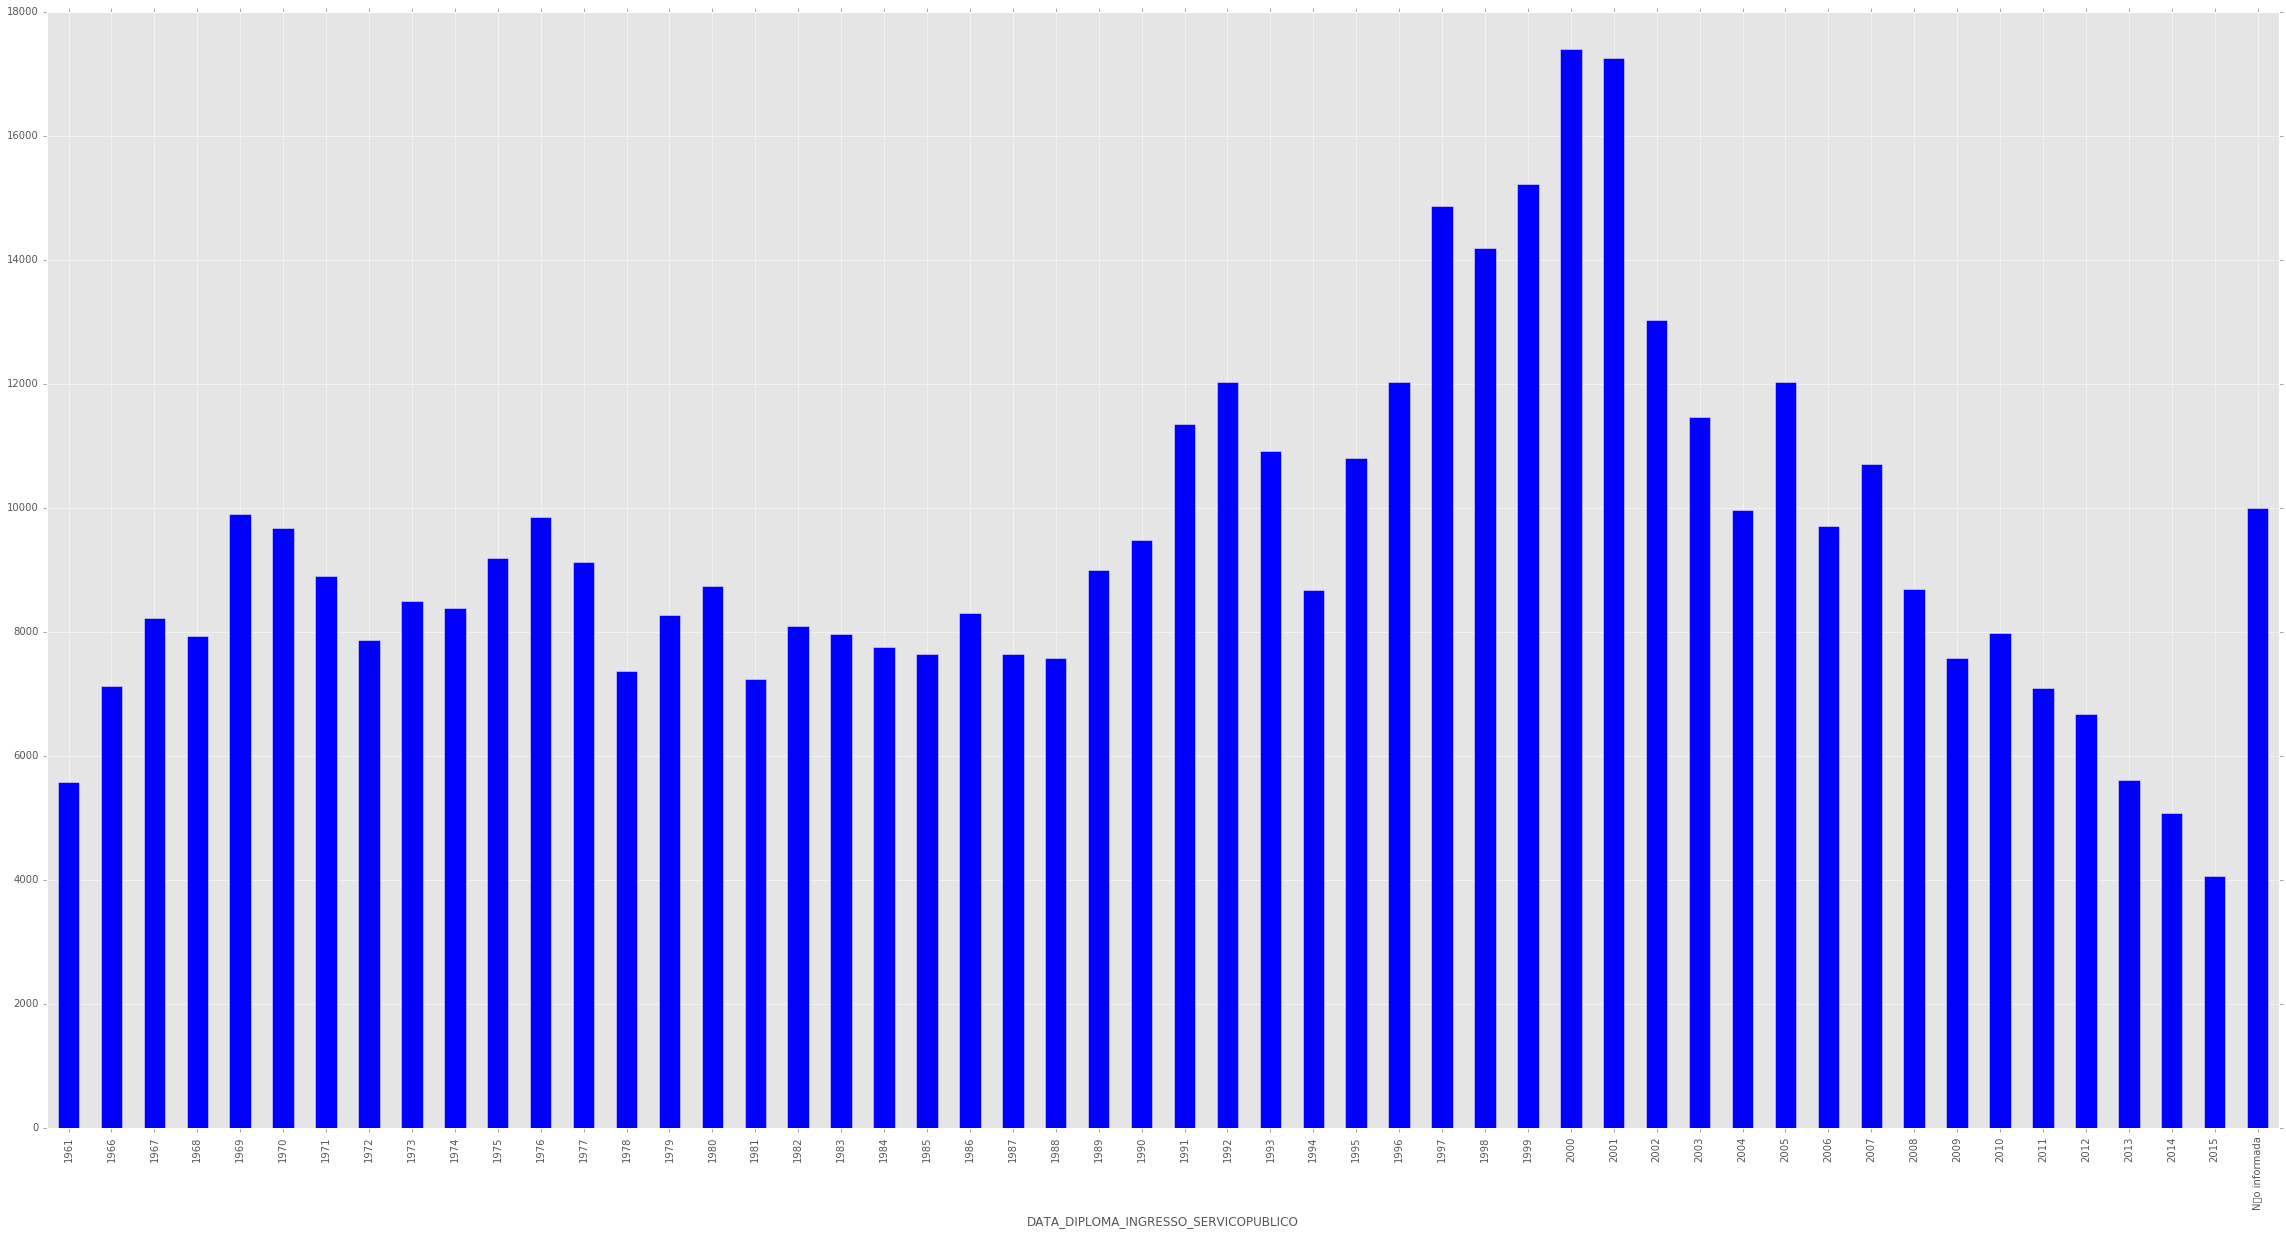

In [110]:
#grouping by the year this person joined the public service, removing groups with less than 100 members
x = merge_left.drop_duplicates(['NOME','CPF']).groupby(merge_left[u'DATA_DIPLOMA_INGRESSO_SERVICOPUBLICO'].map(lambda x: x.split(r"/")[-1])).filter(lambda k: len(k) > 100)
x = x.groupby(merge_left[u'DATA_DIPLOMA_INGRESSO_SERVICOPUBLICO'].map(lambda x: x.split(r"/")[-1]))

#removing Data Não Informada
#merge_left.drop( x.get_group('N\xe3o informada').index )

#ploting a bar graph containing the mean of all salaries from people who joined each yearh
x[u'REMUNERAÇÃO BÁSICA BRUTA (R$)'].mean().plot(kind='bar', figsize=(40,20))

Conforme pode ser observado na figura anterior, o comportamento do gráfico é diferente do esperado. É possível notar uma razoável estabilidade no salário mediano dos que ingressaram no serviço público federal nos anos 1960, 1970 e 1980. Porém a curva cresce com a chegada dos anos 1990 e atinge o pico no início dos anos 2000.

O salário médio dos servidores que ingressam a partir de 2002 começa uma curva decrescente.

Para auxiliar na análise, vamos observar o número de contratações de novos servidores públicos no mesmo período.

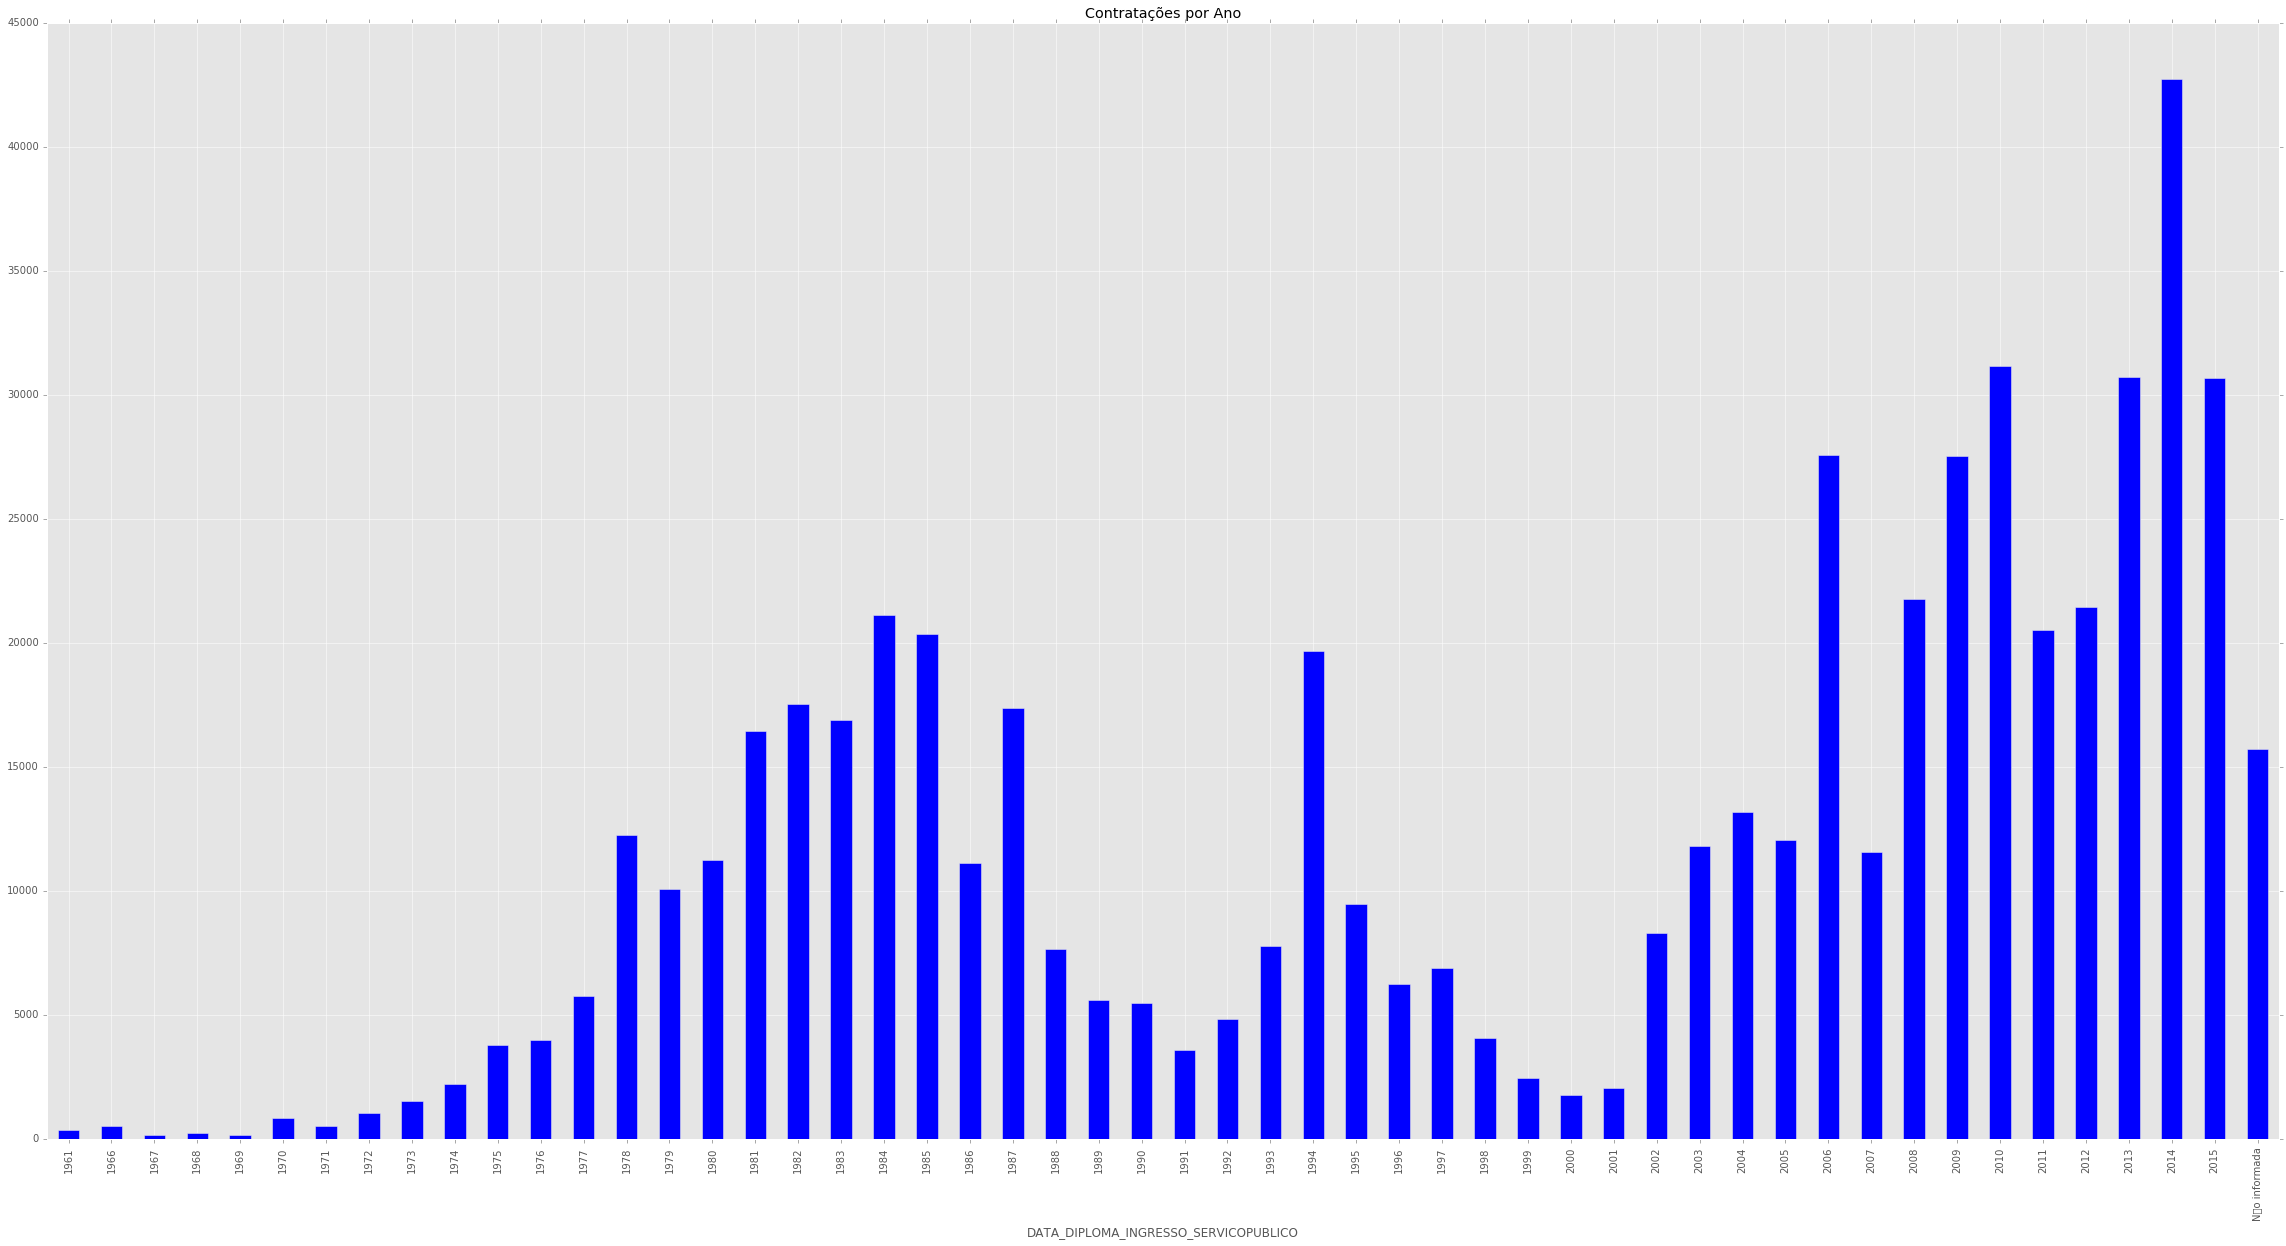

In [111]:
x[u'REMUNERAÇÃO BÁSICA BRUTA (R$)'].count().plot(kind='bar', figsize=(40,20), title=u'Contratações por Ano')

Vamos analizar isso de forma mais profunda, gerando um histograma de cada um dos anos plotados no gráfico superior.

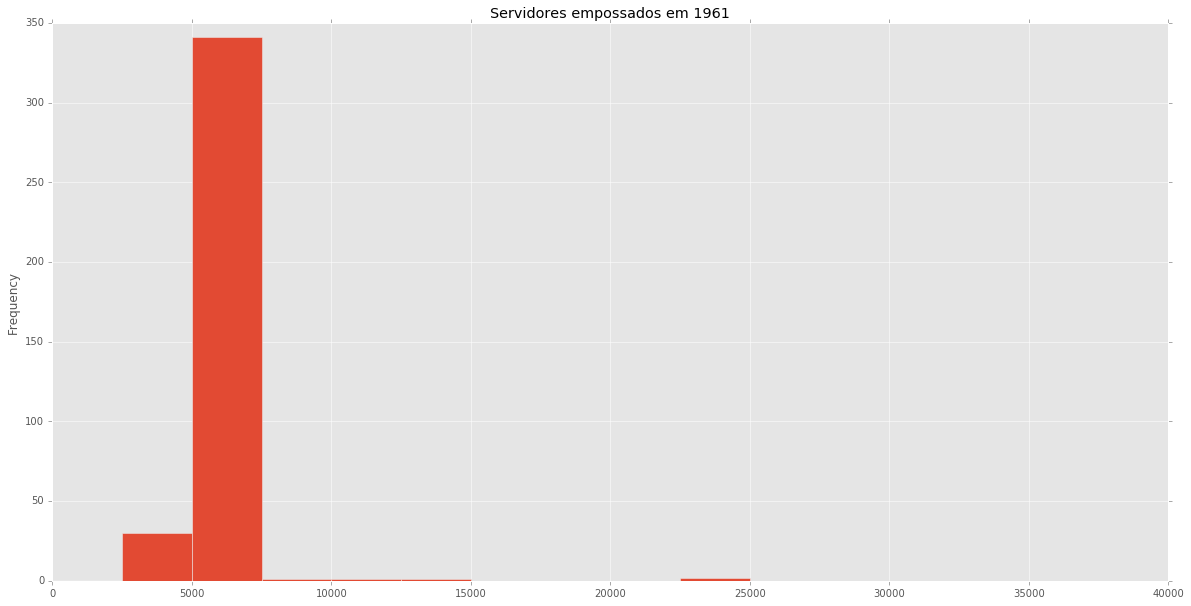

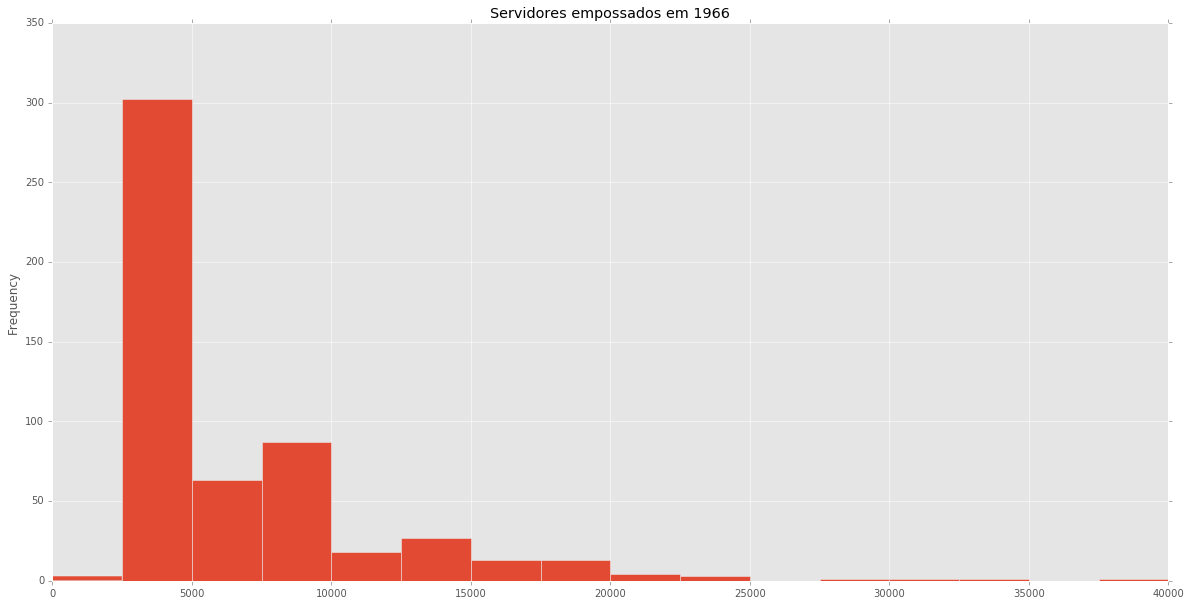

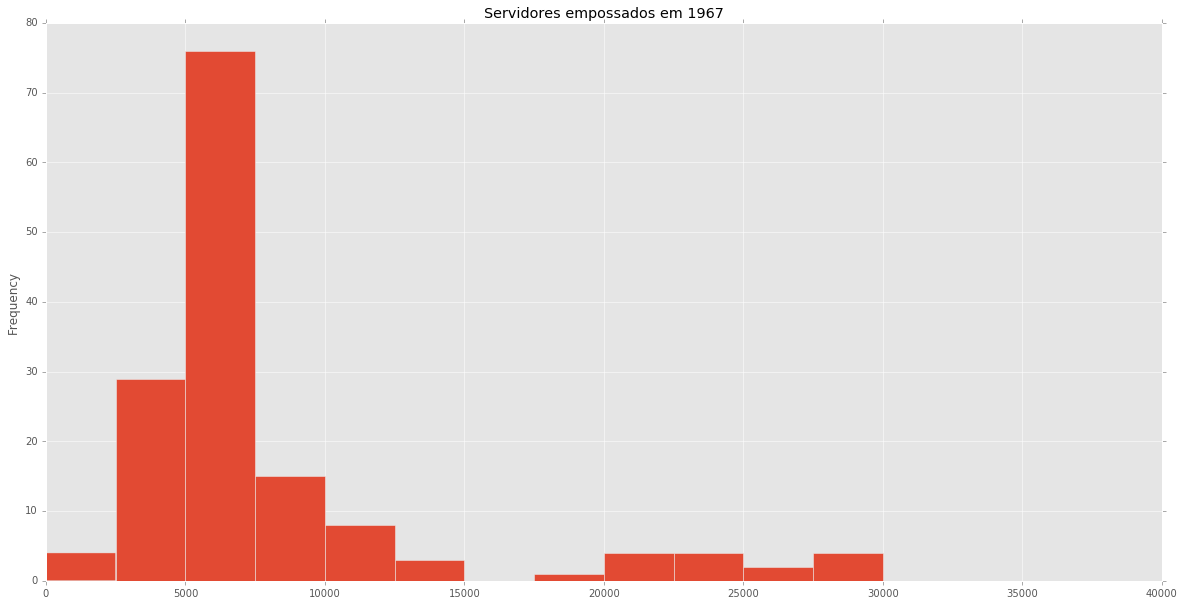

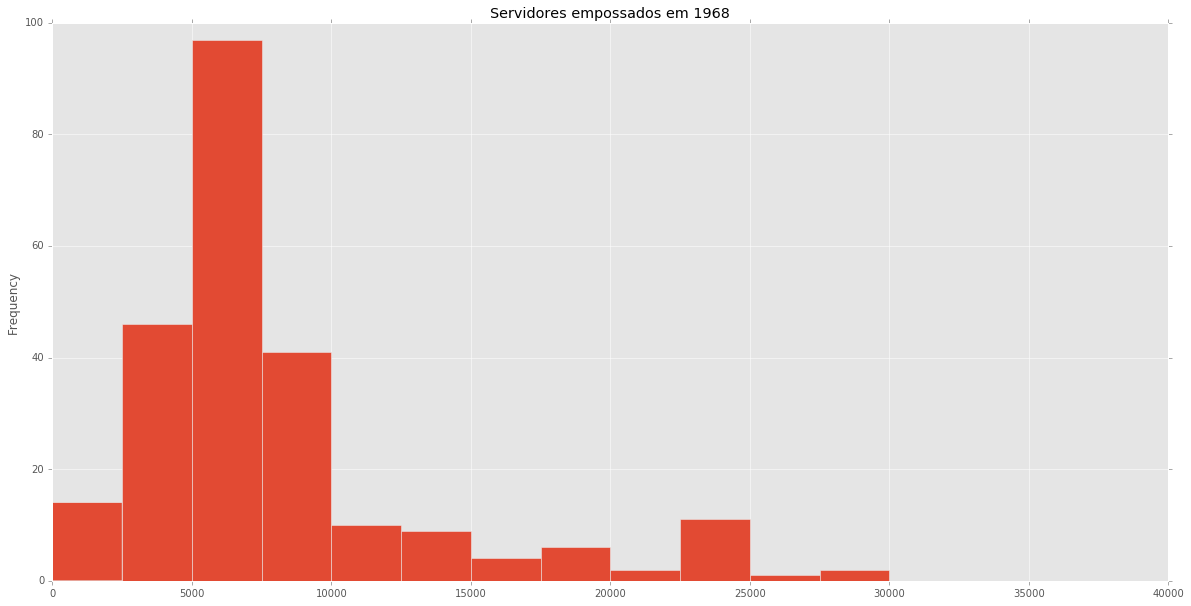

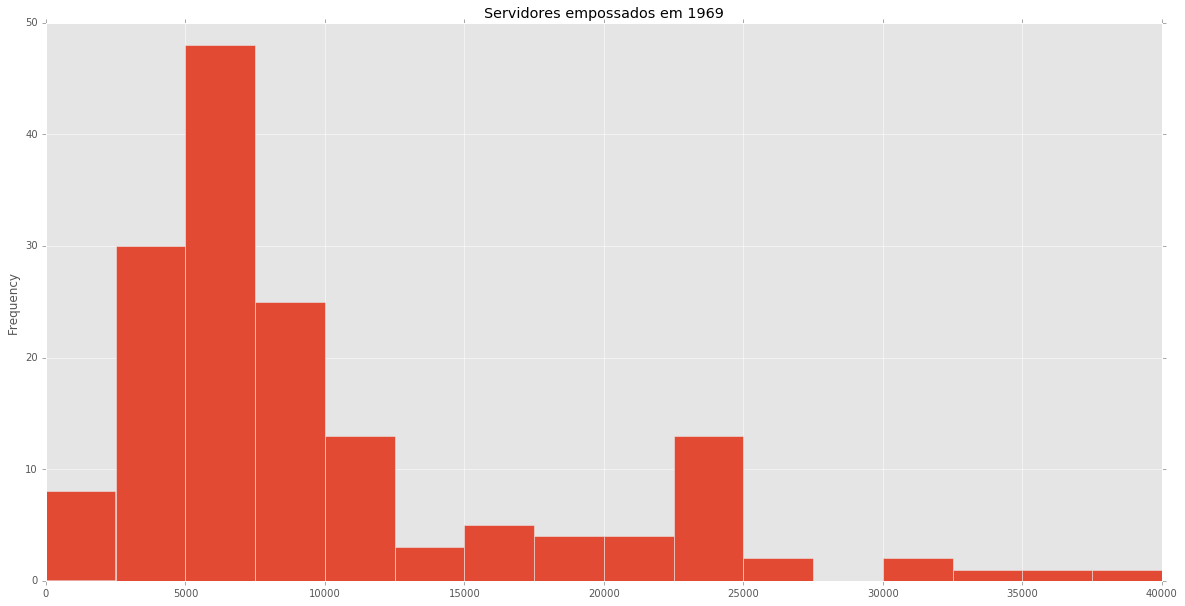

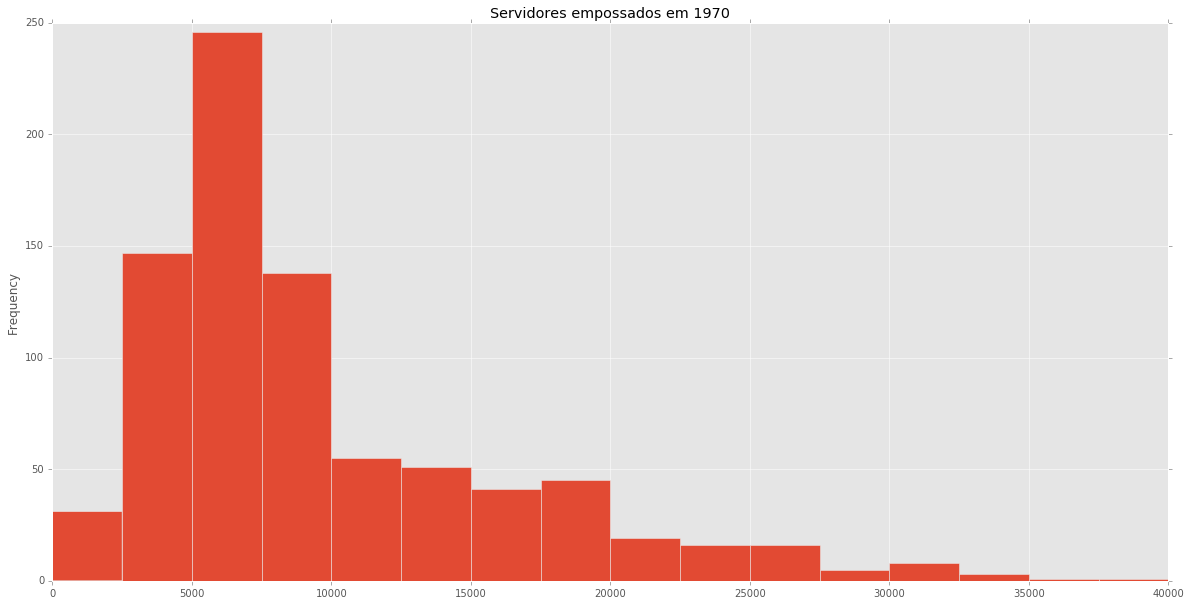

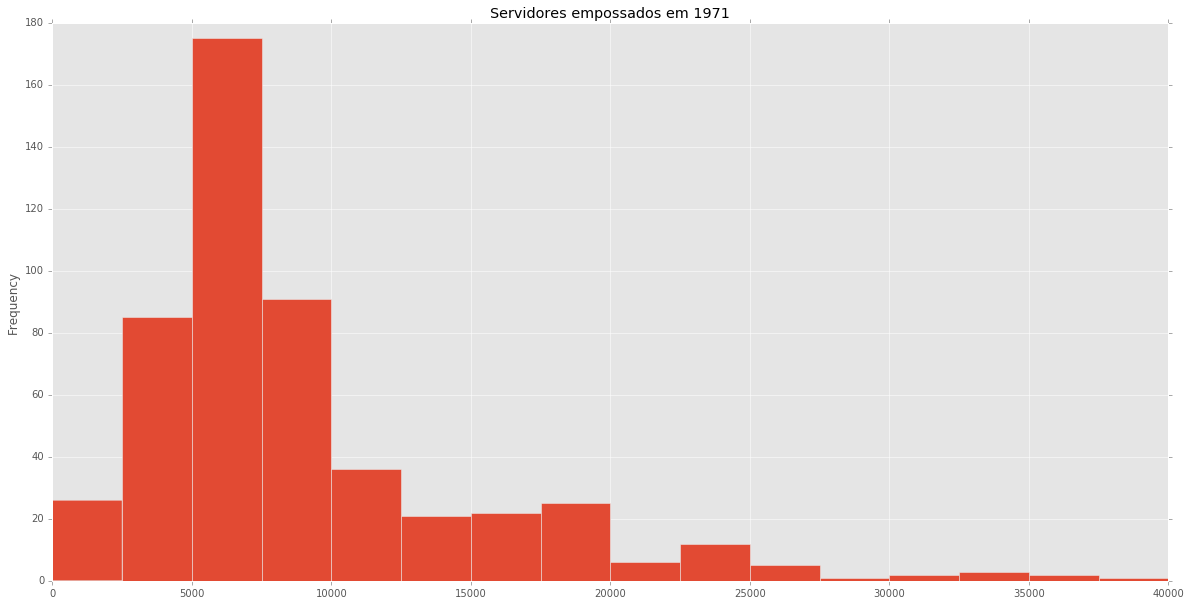

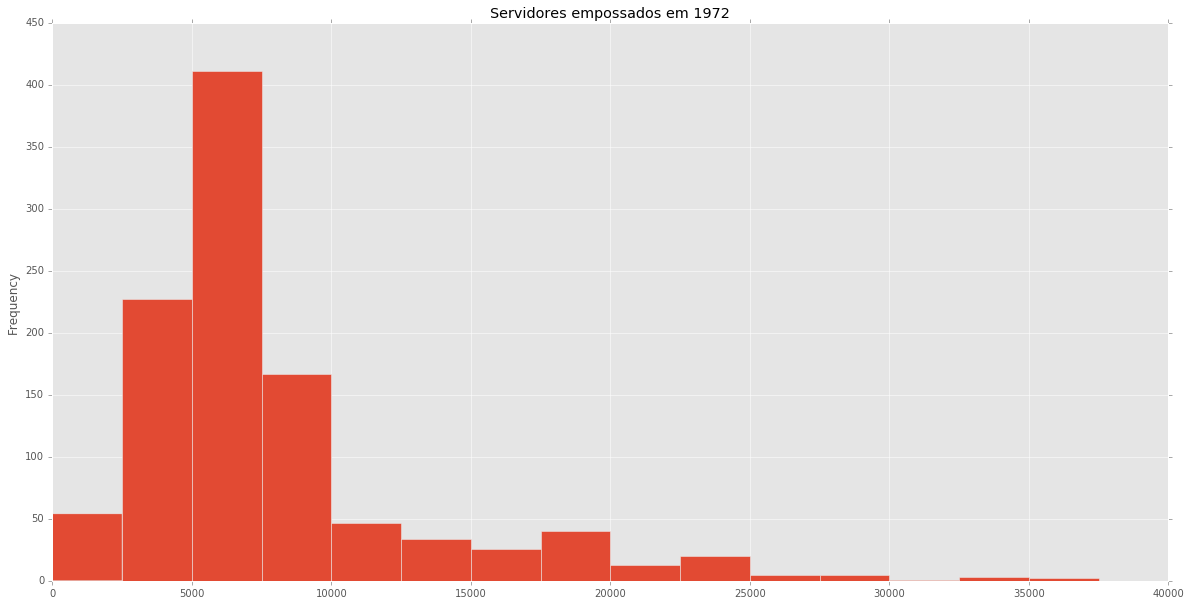

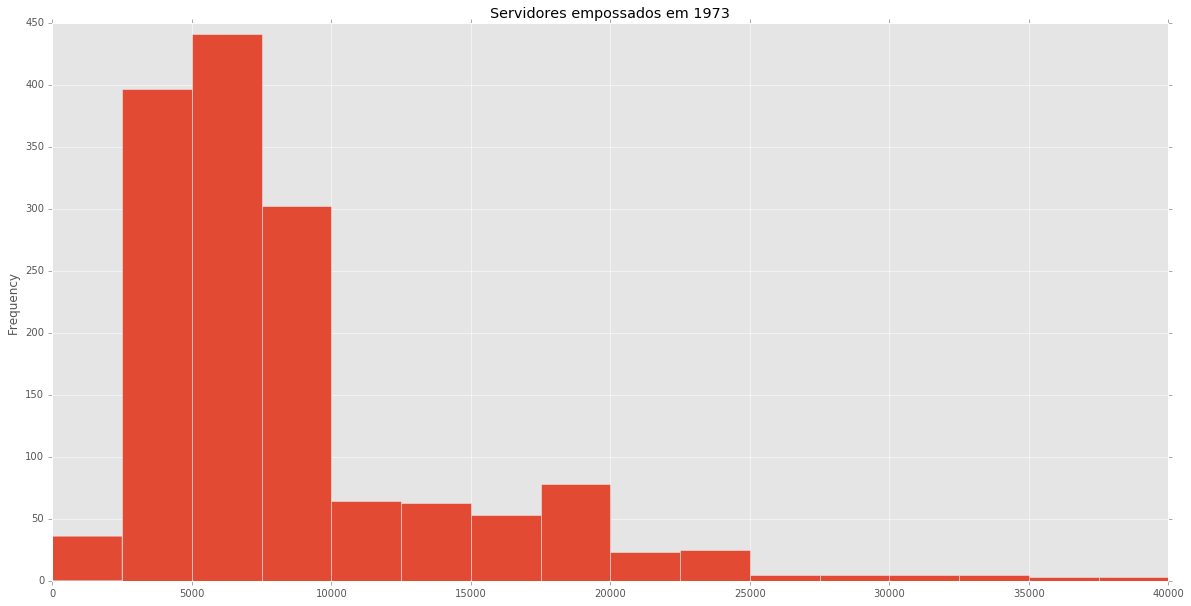

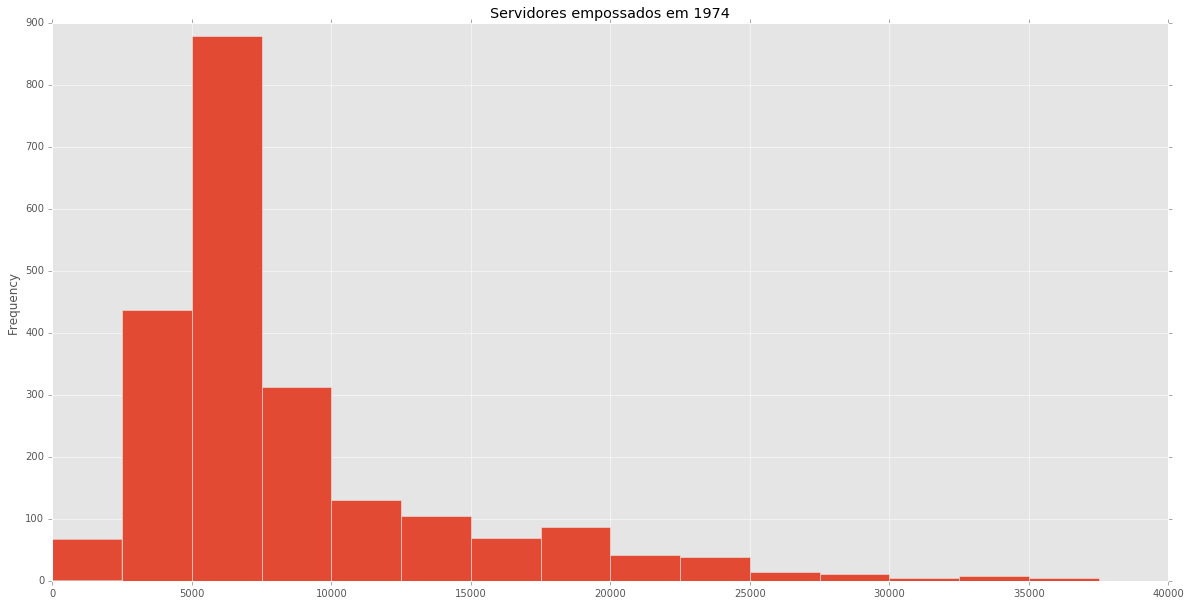

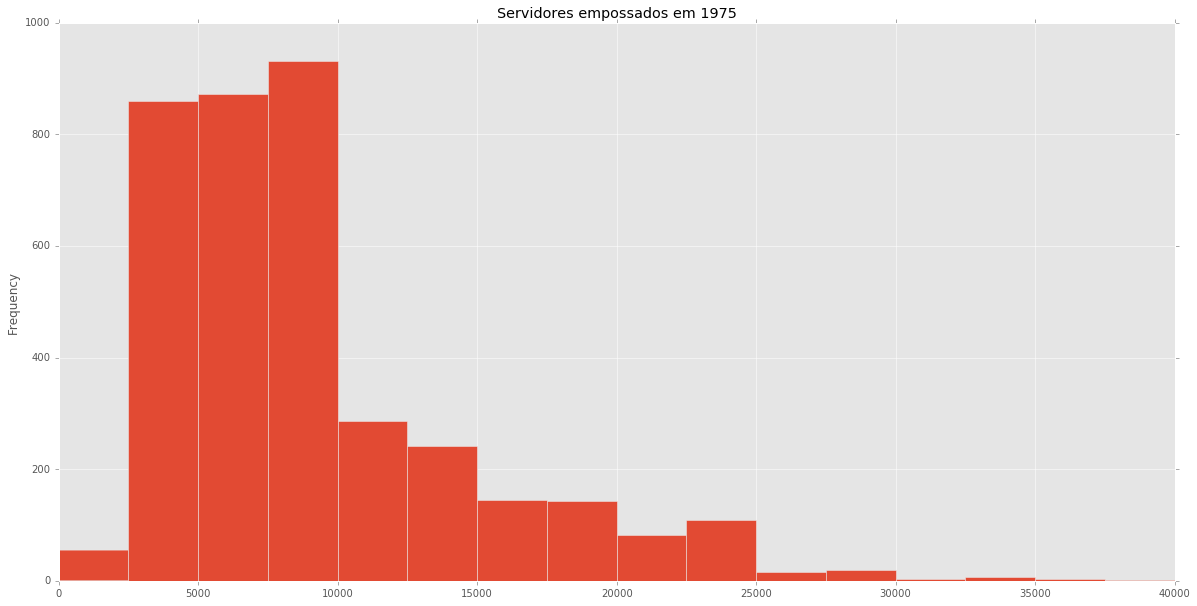

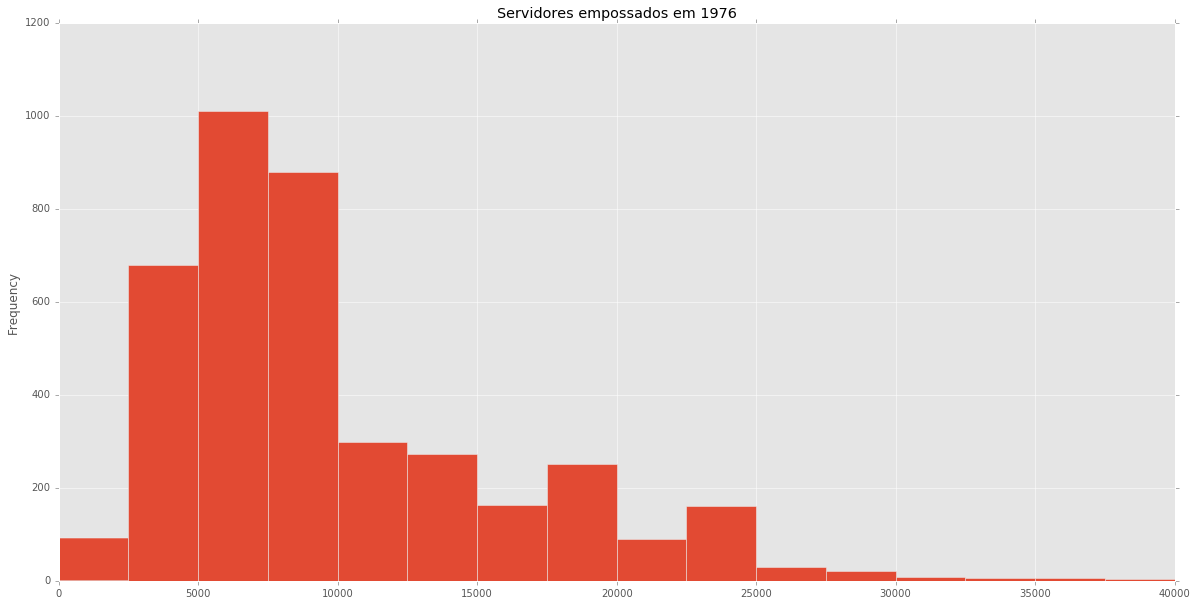

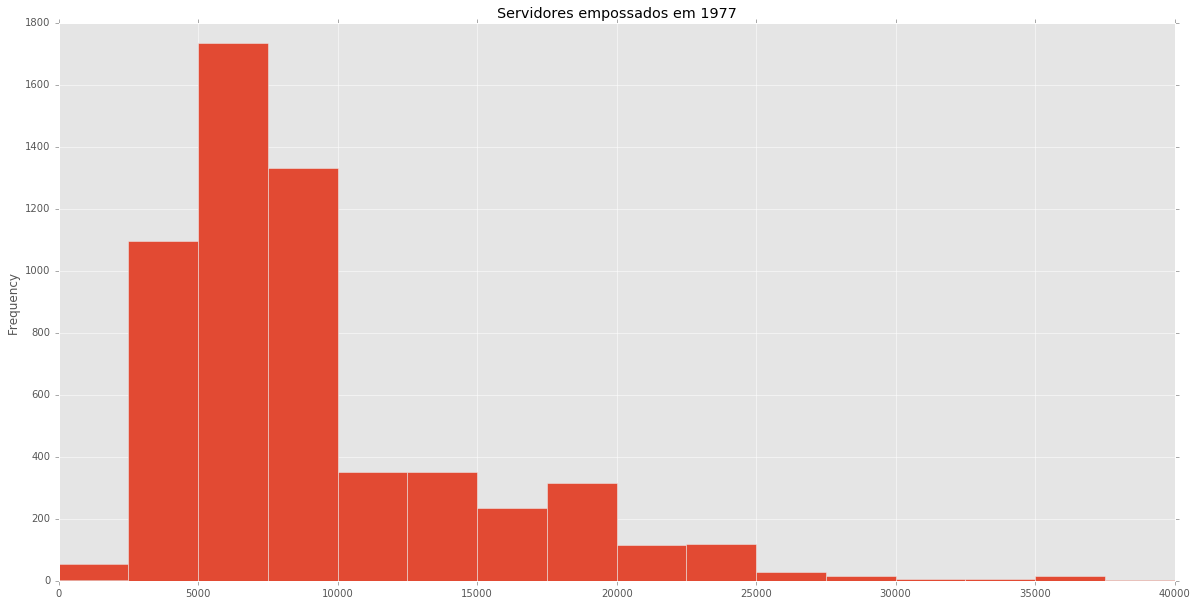

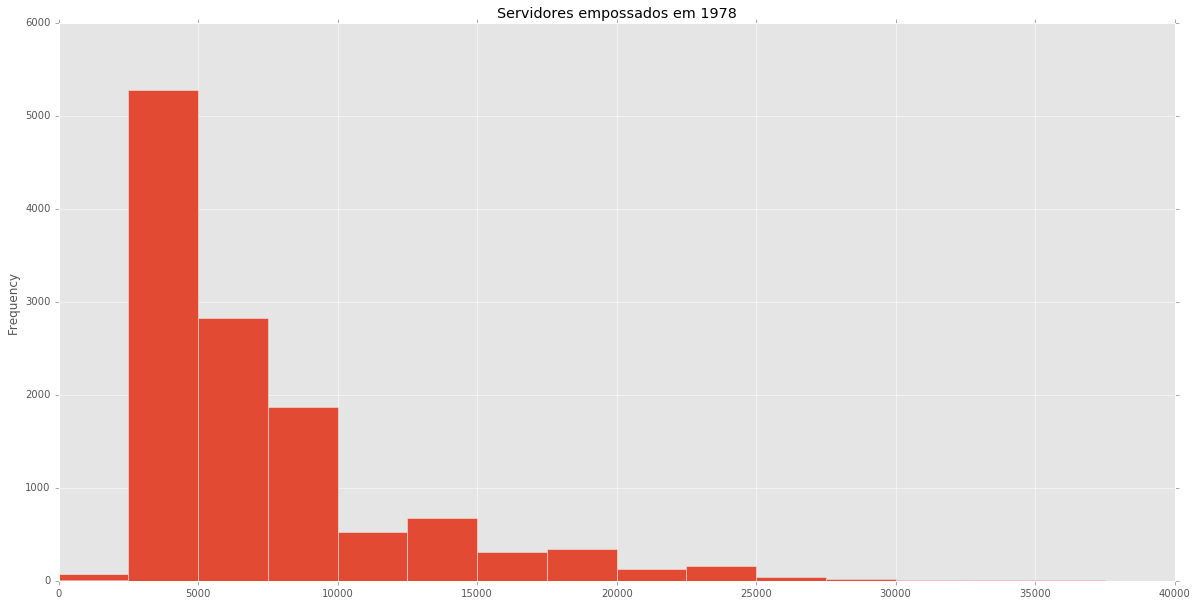

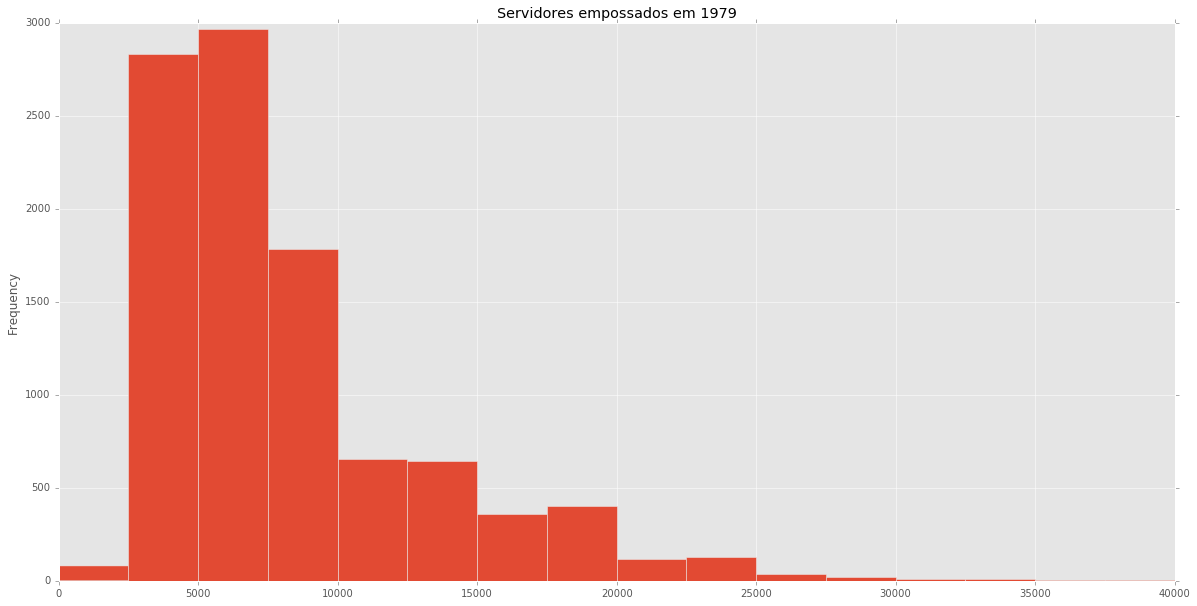

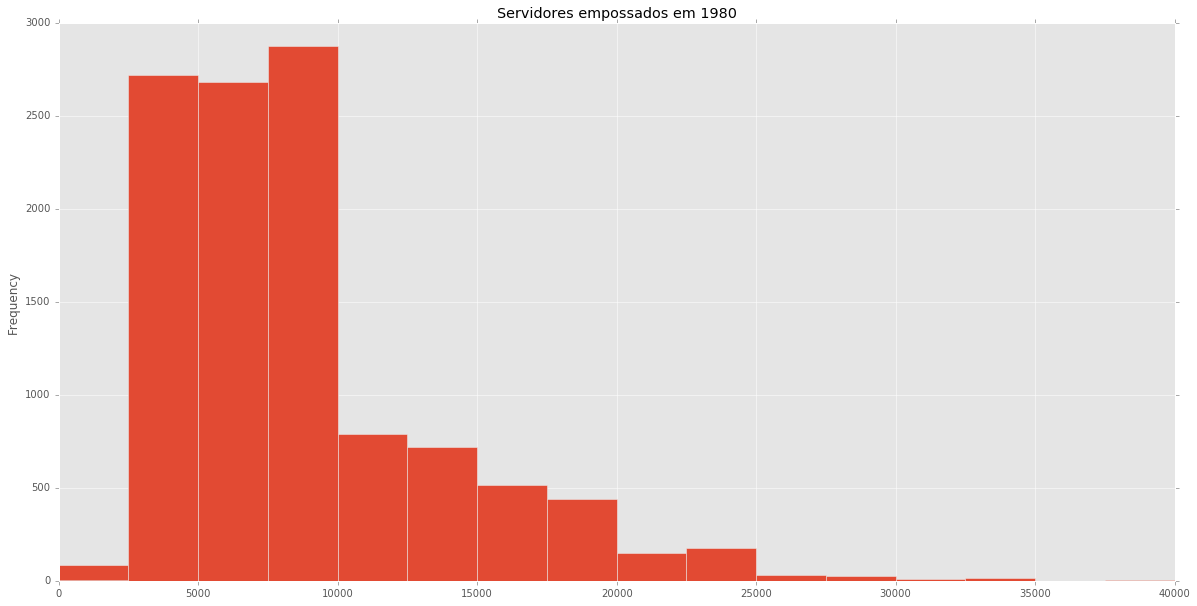

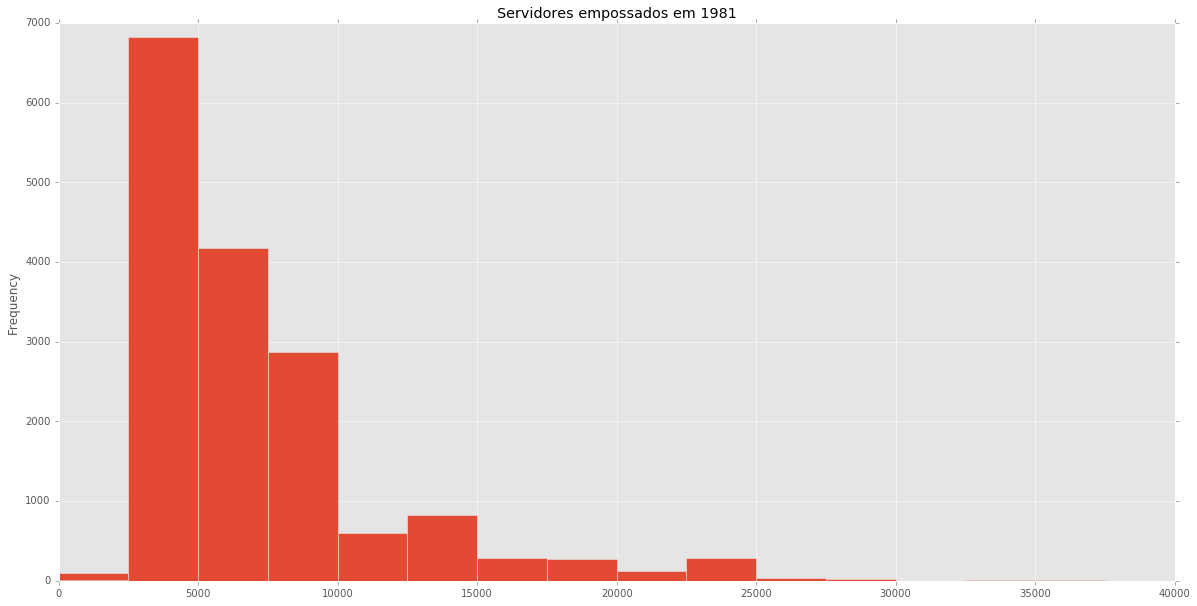

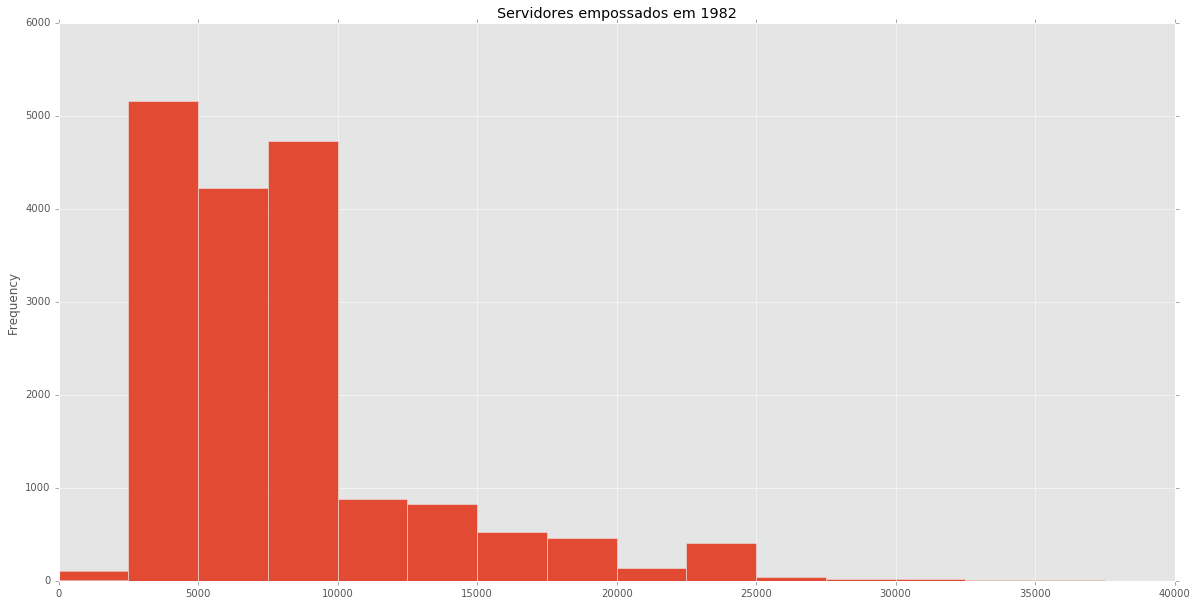

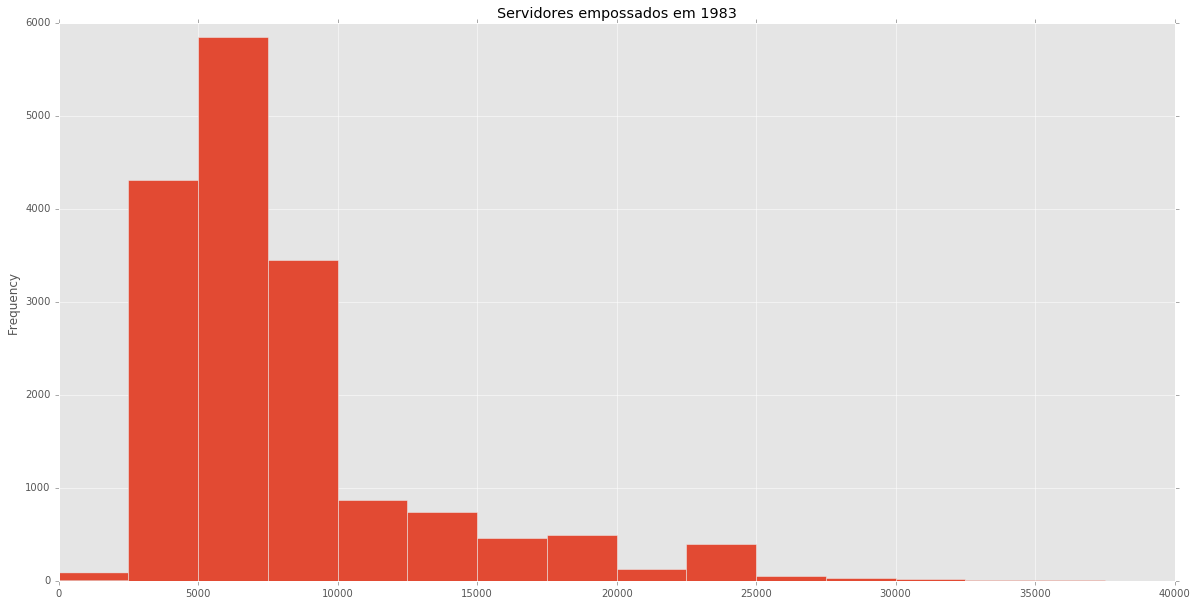

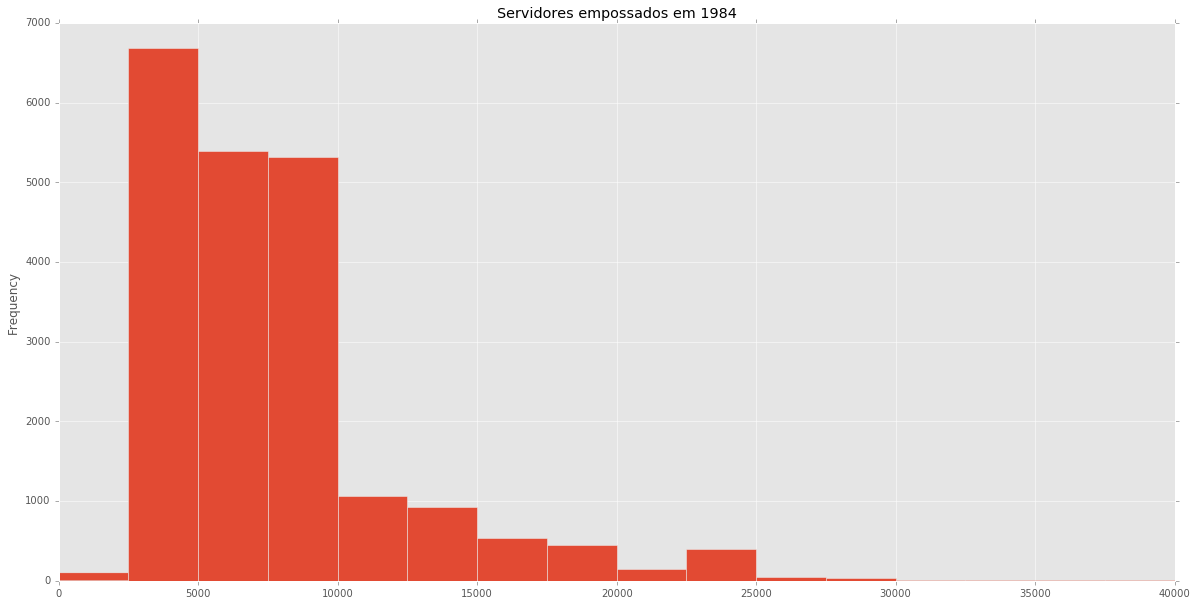

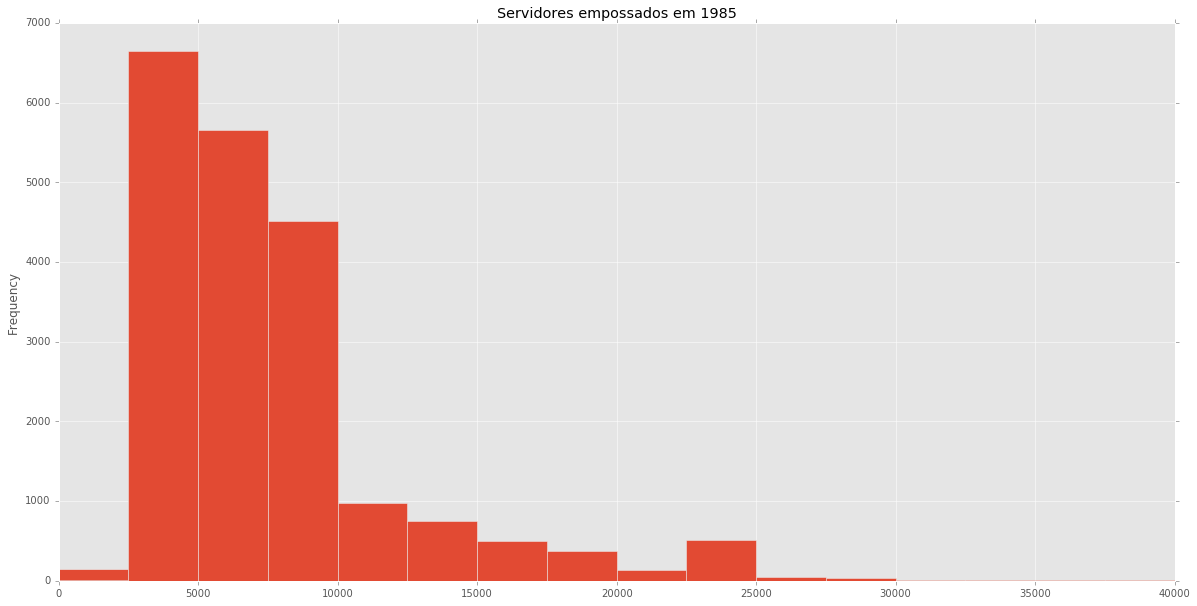

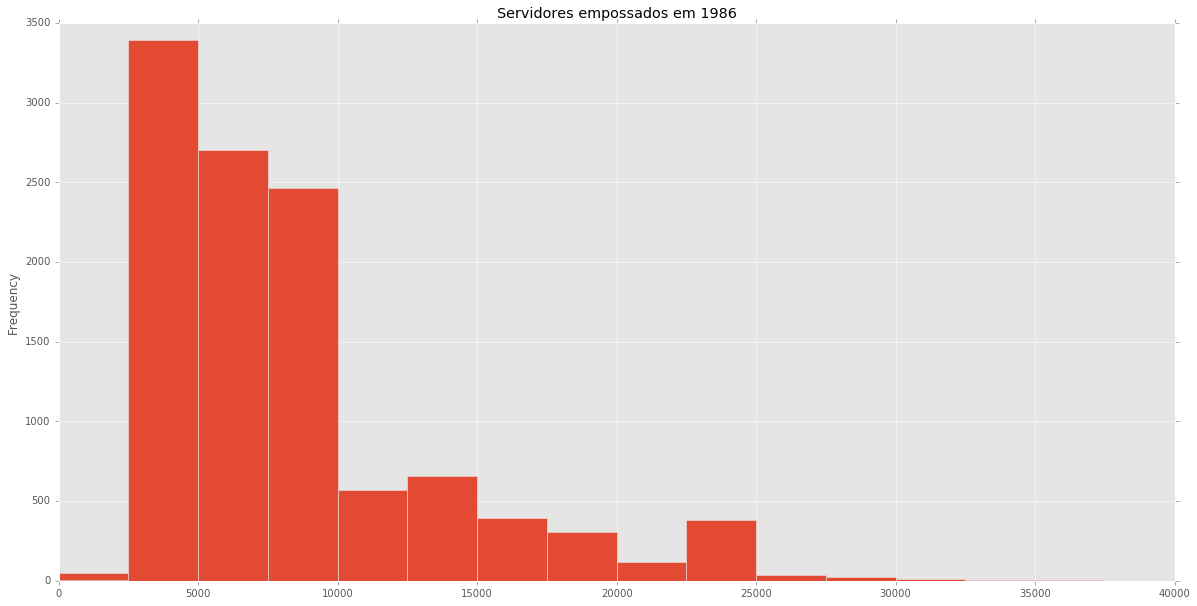

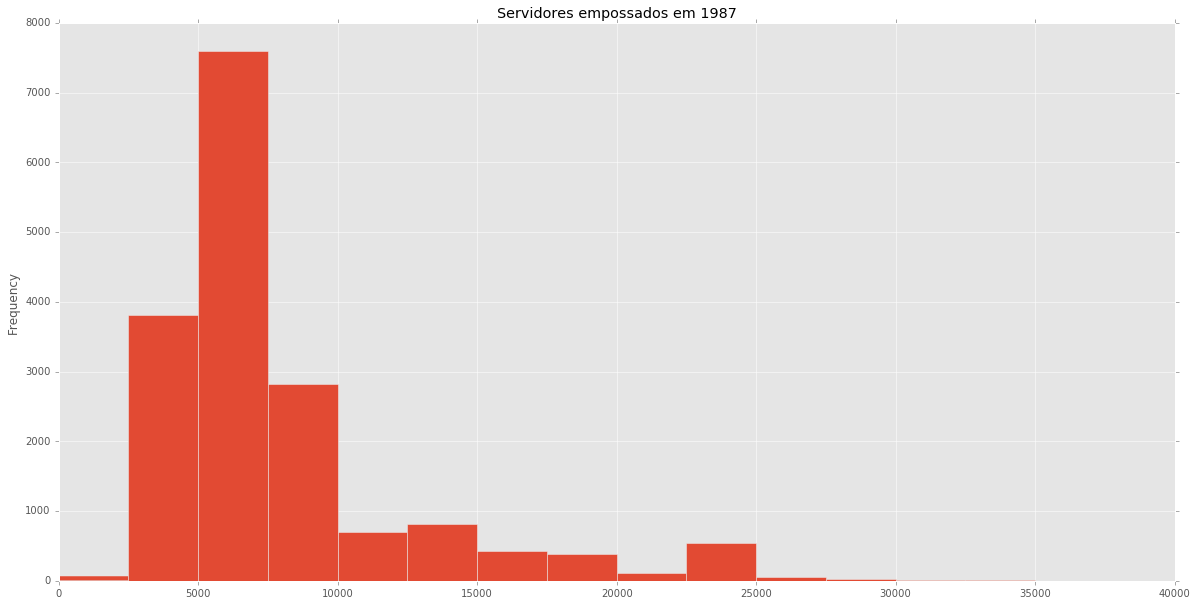

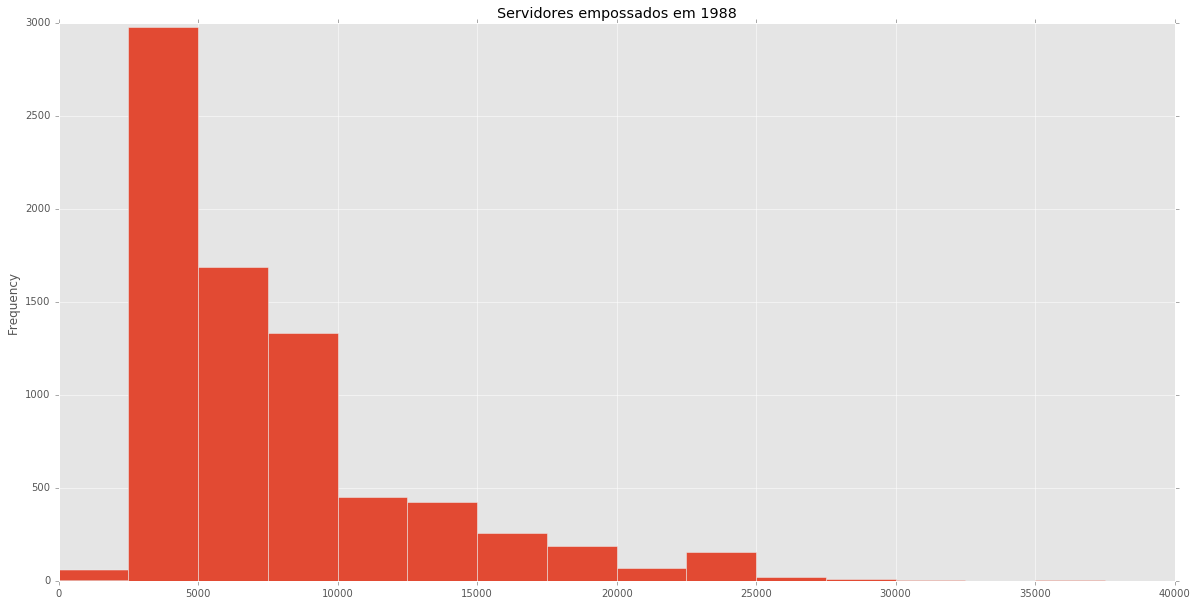

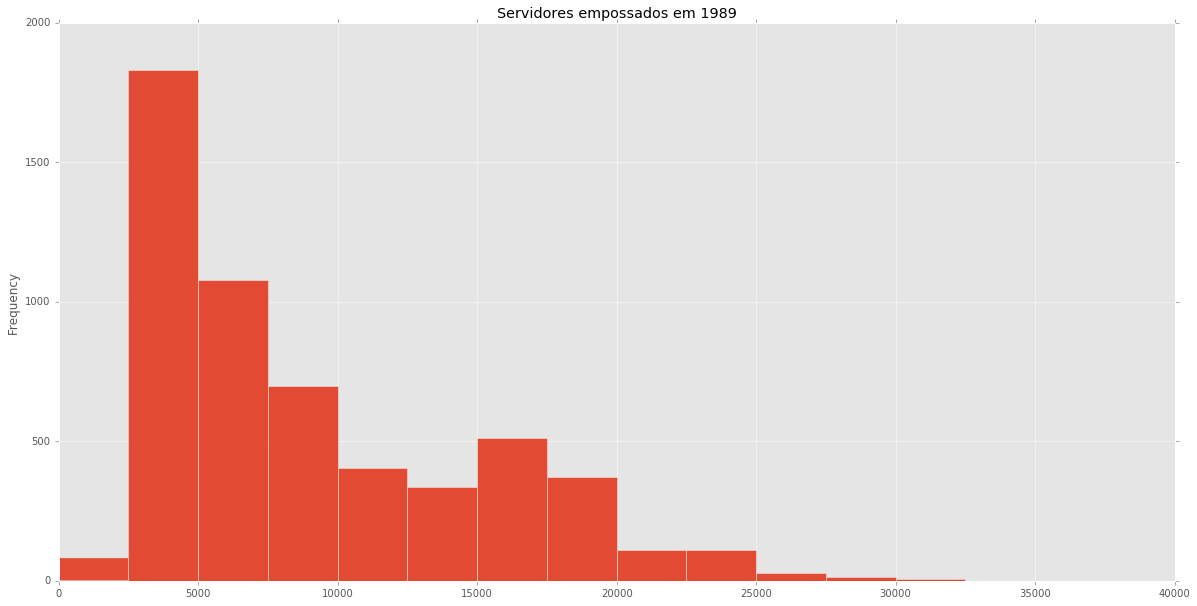

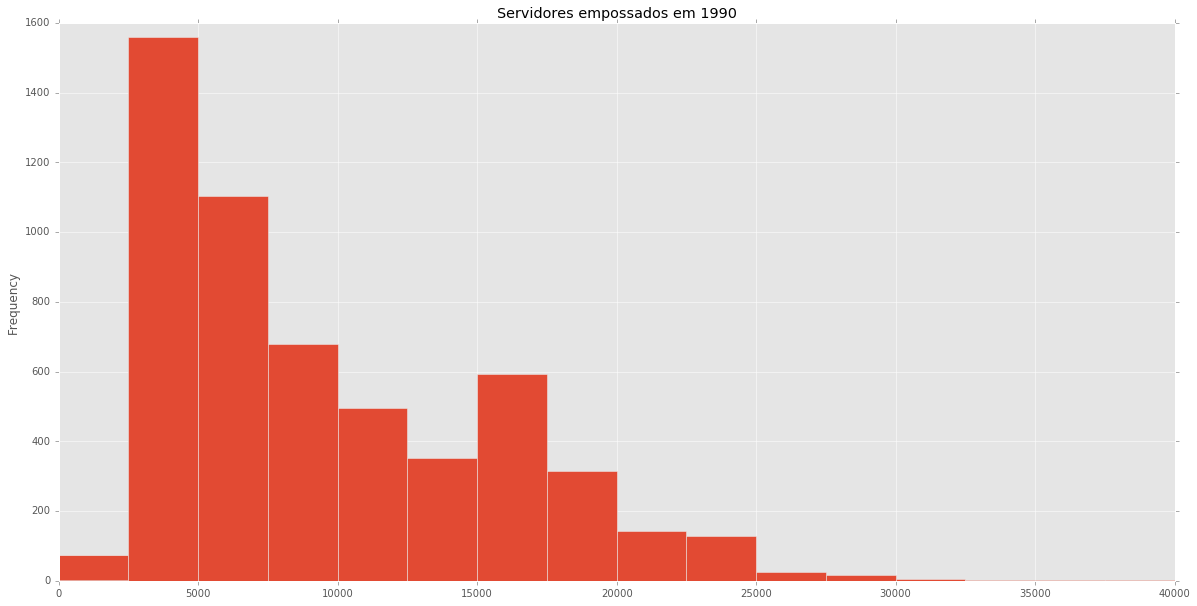

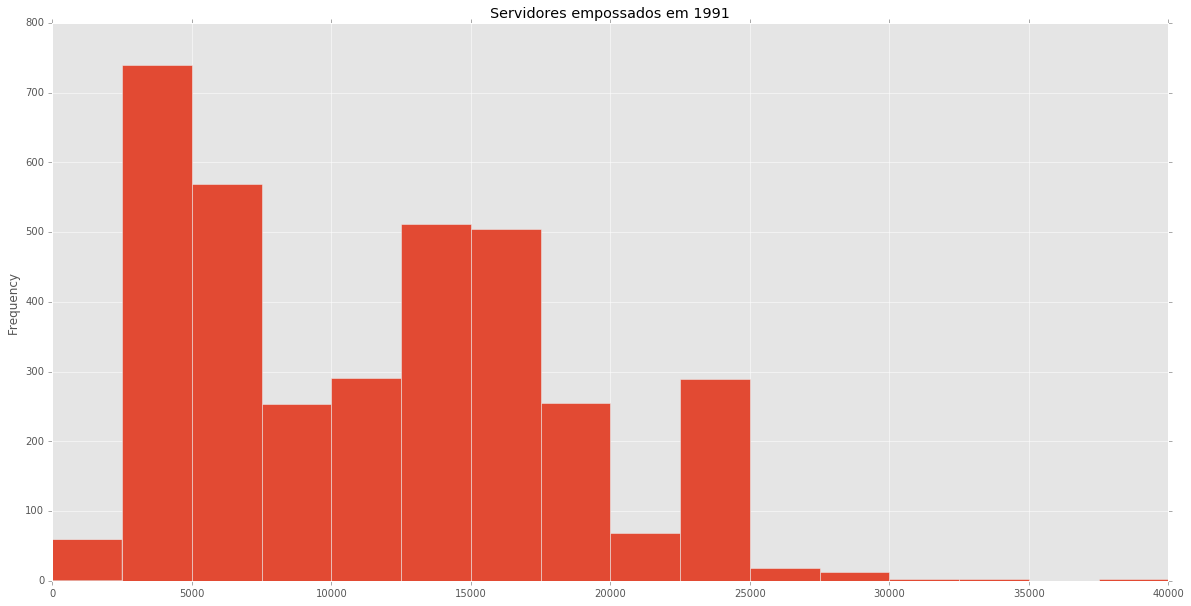

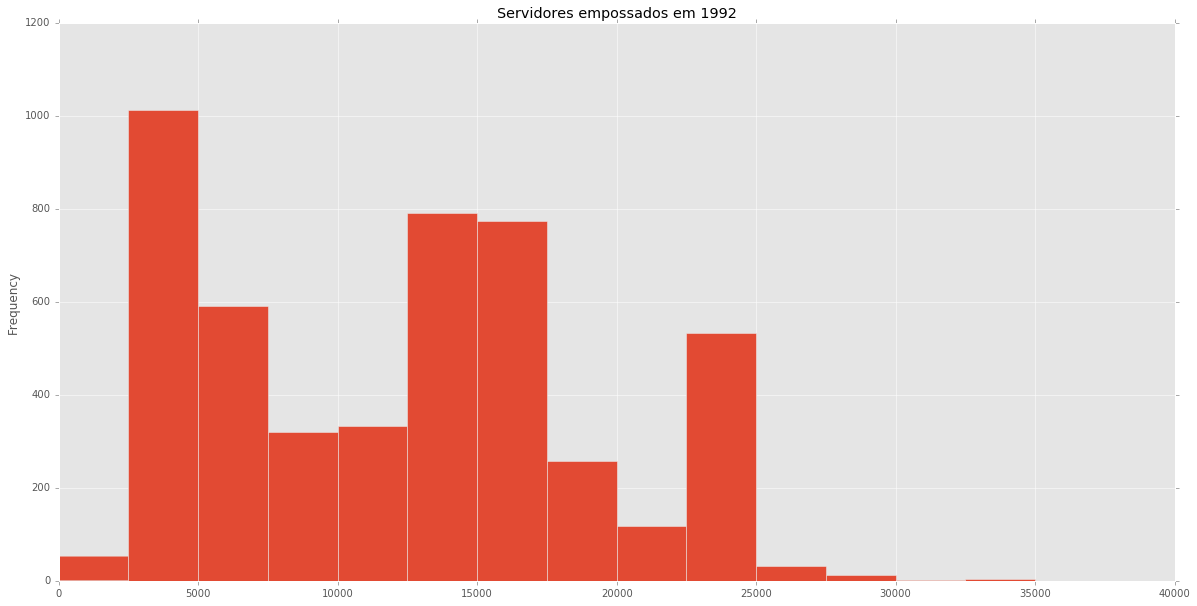

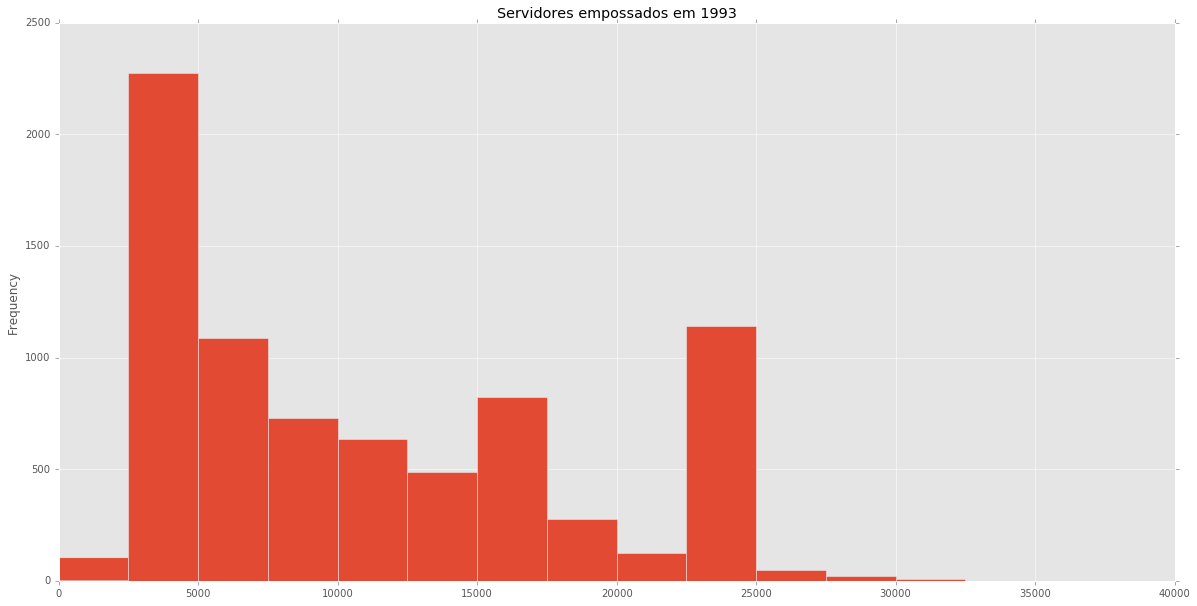

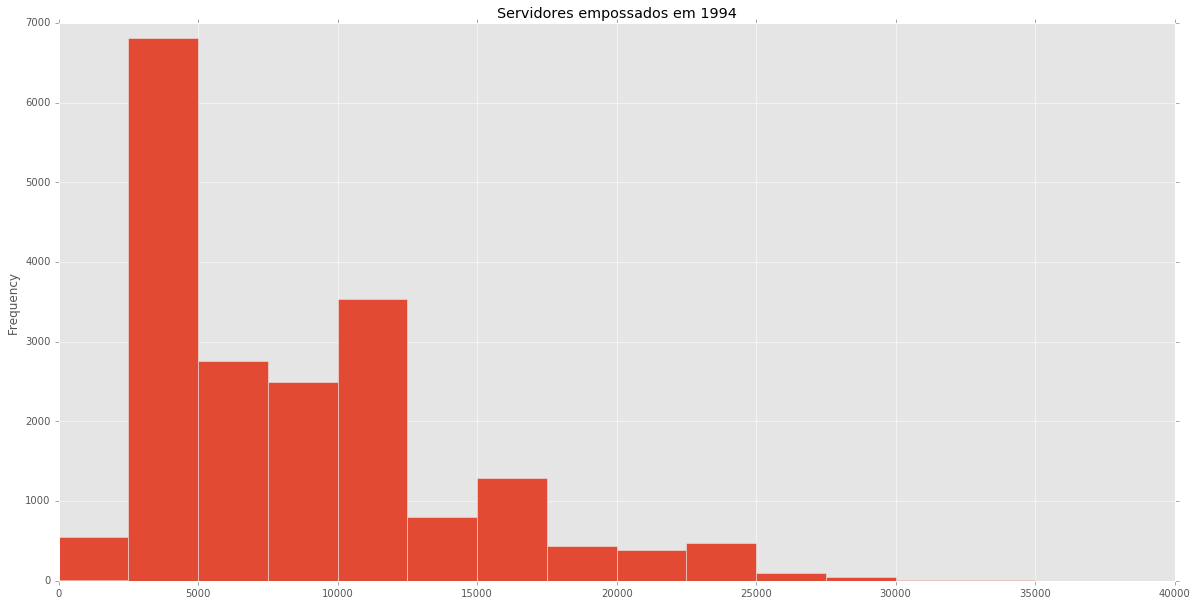

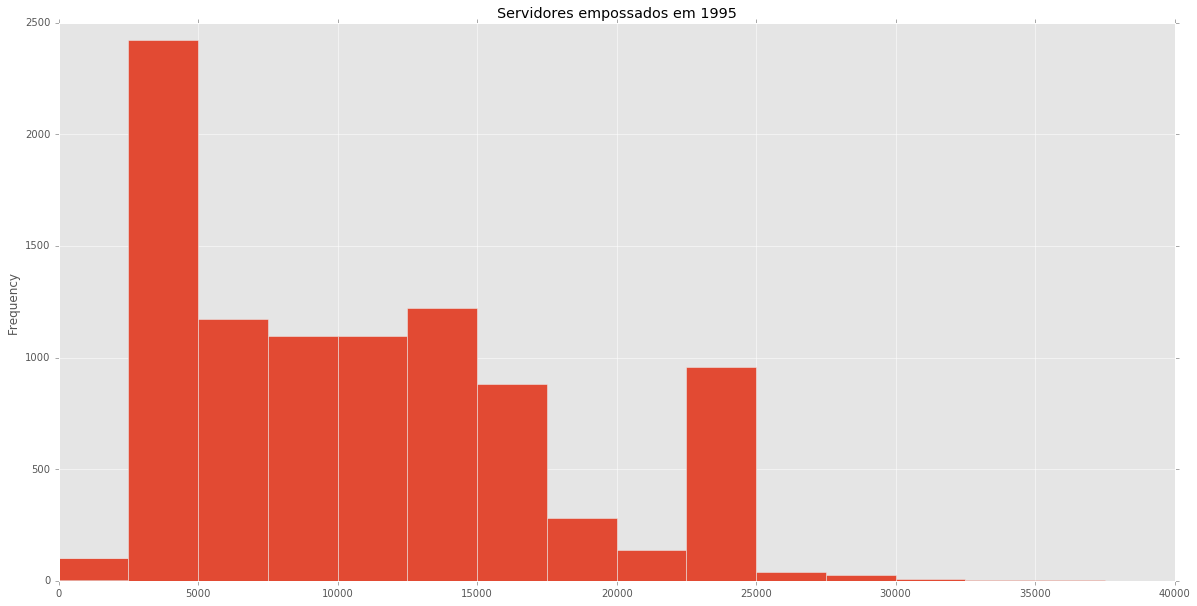

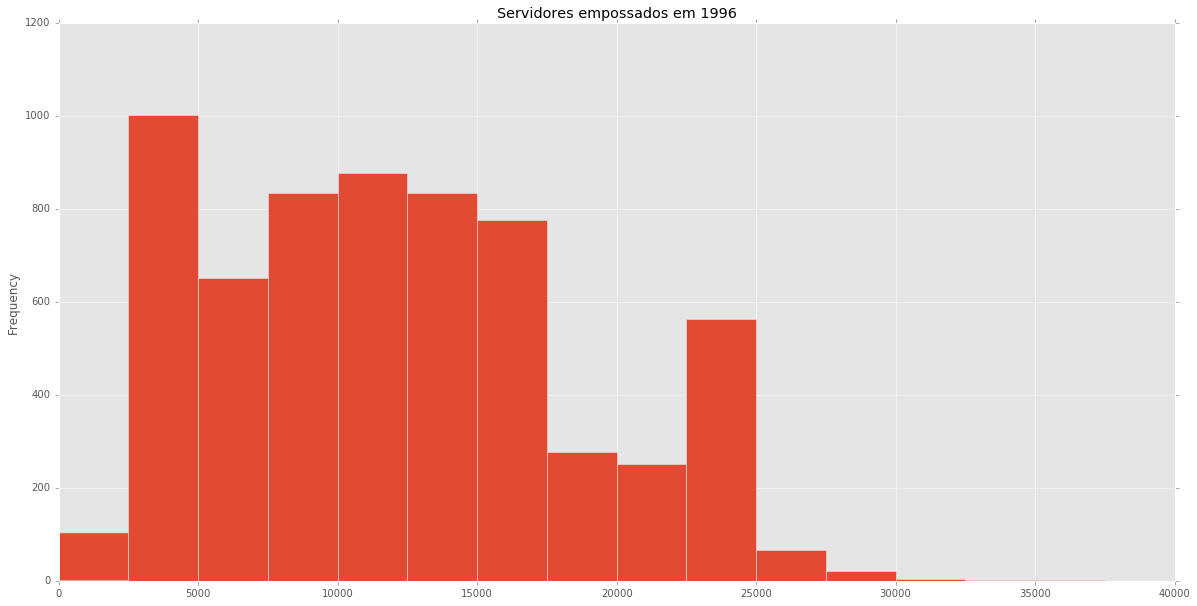

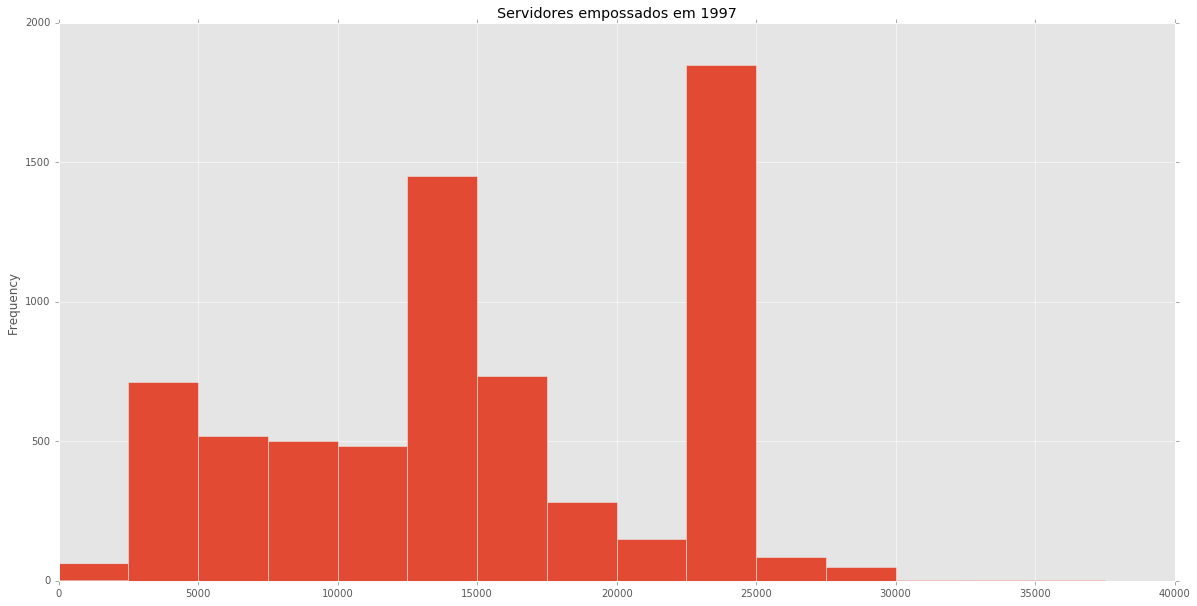

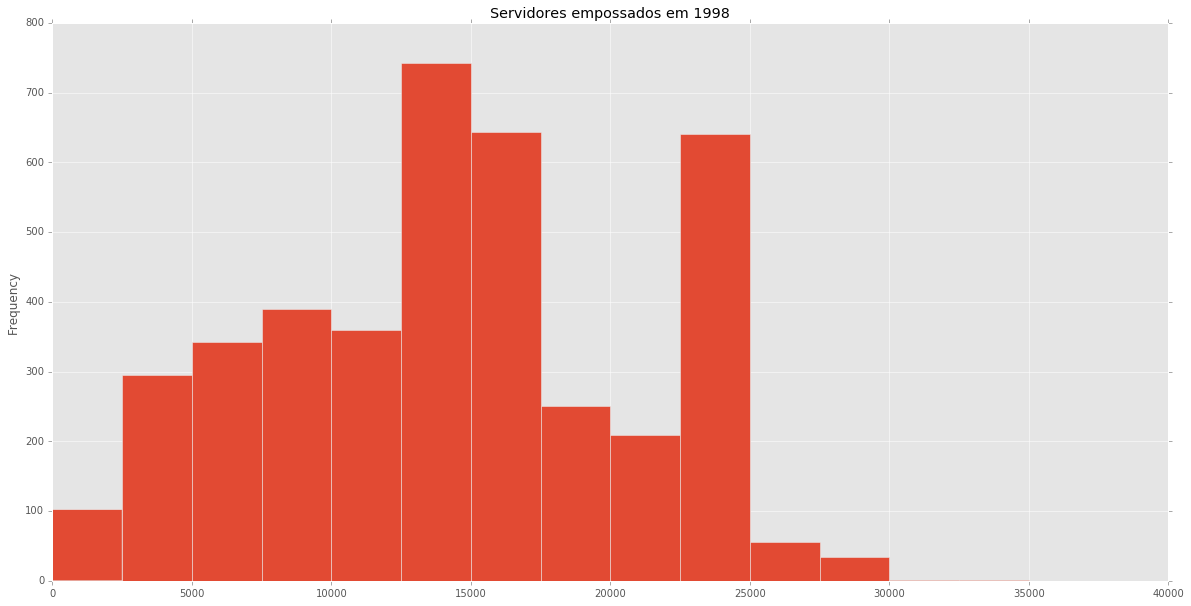

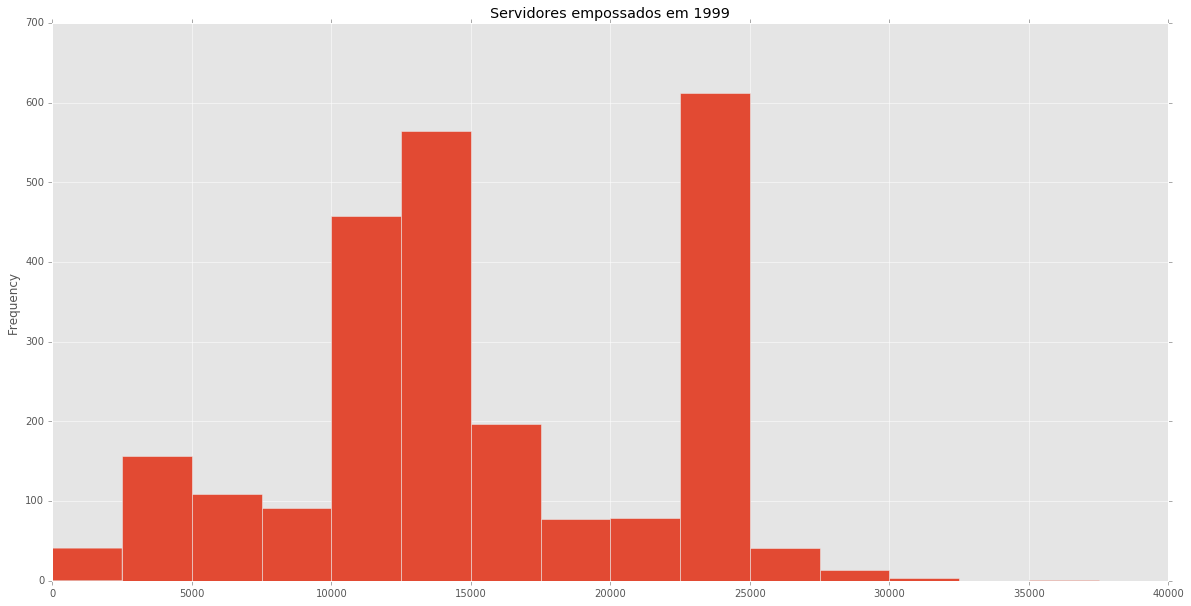

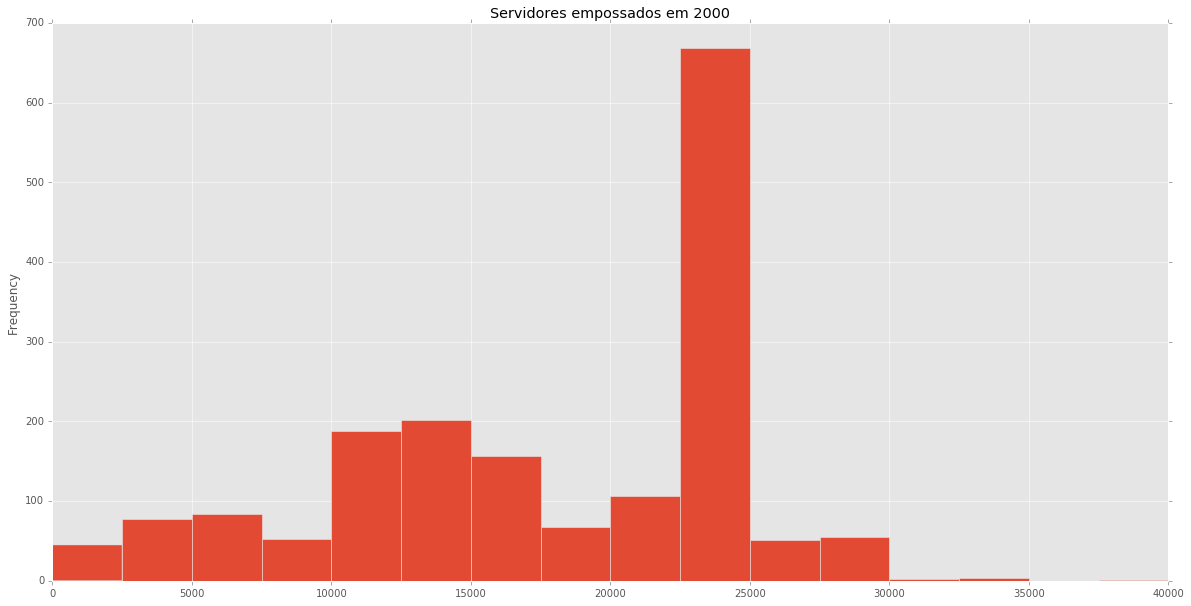

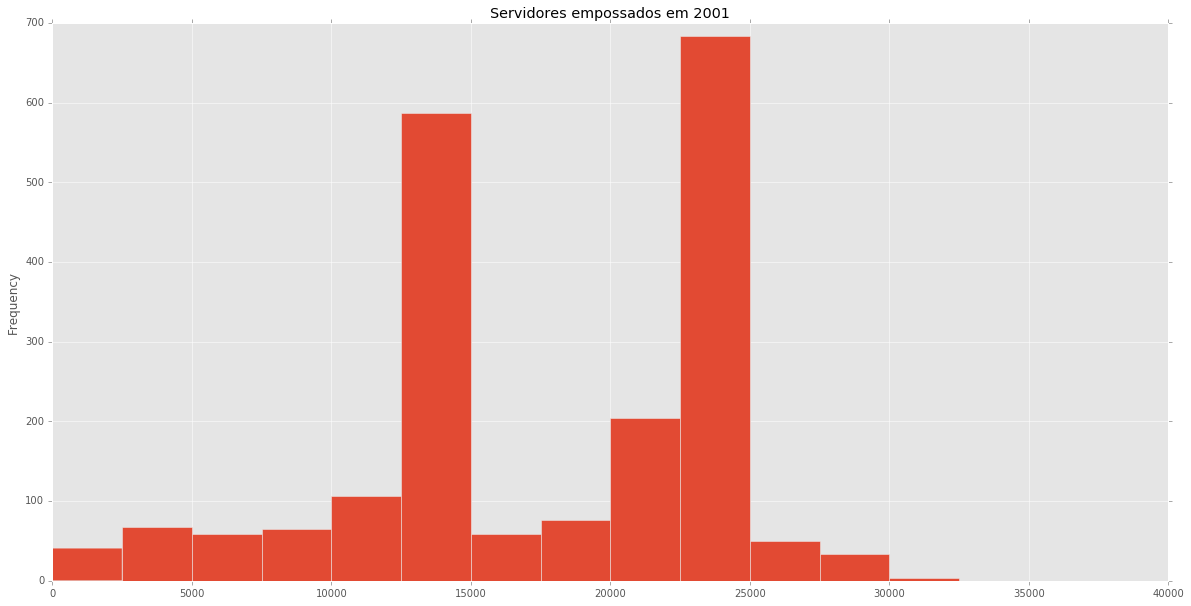

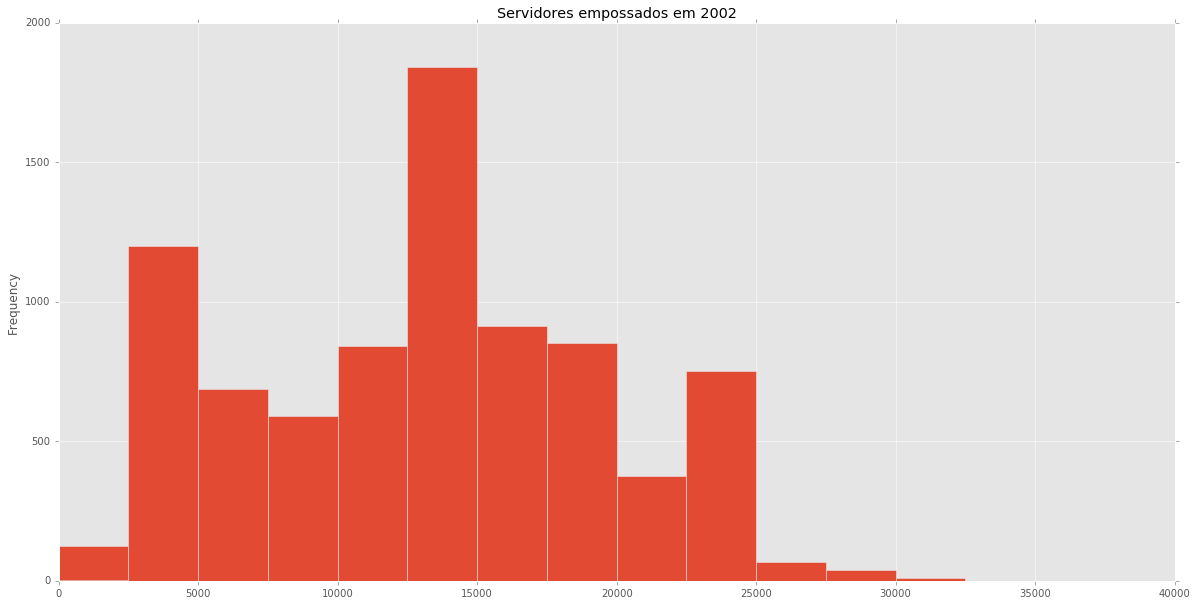

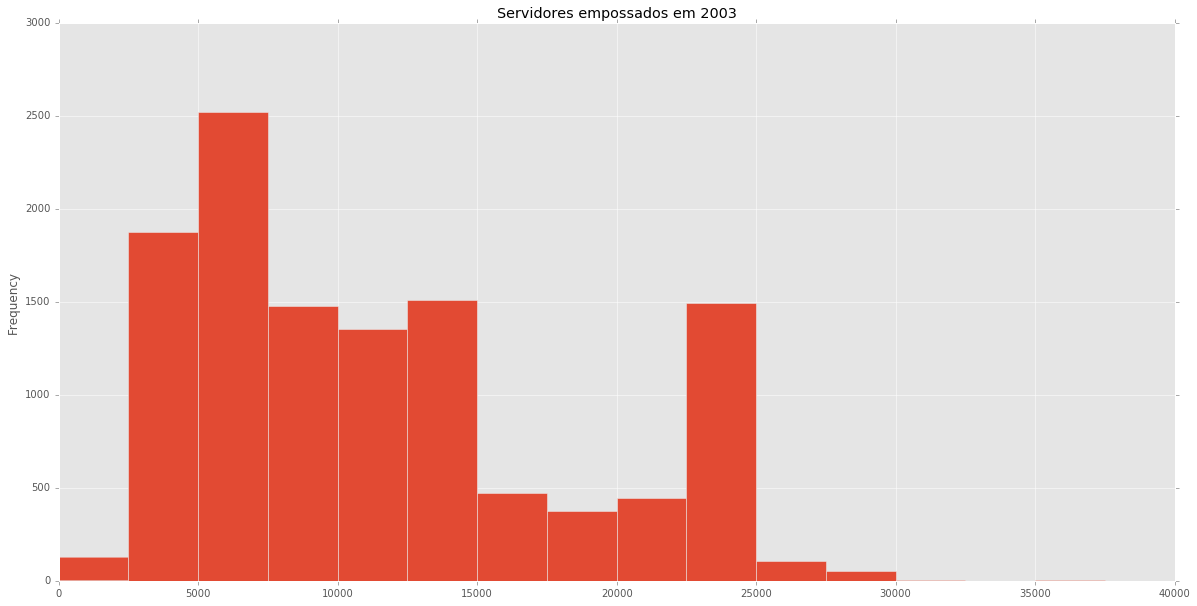

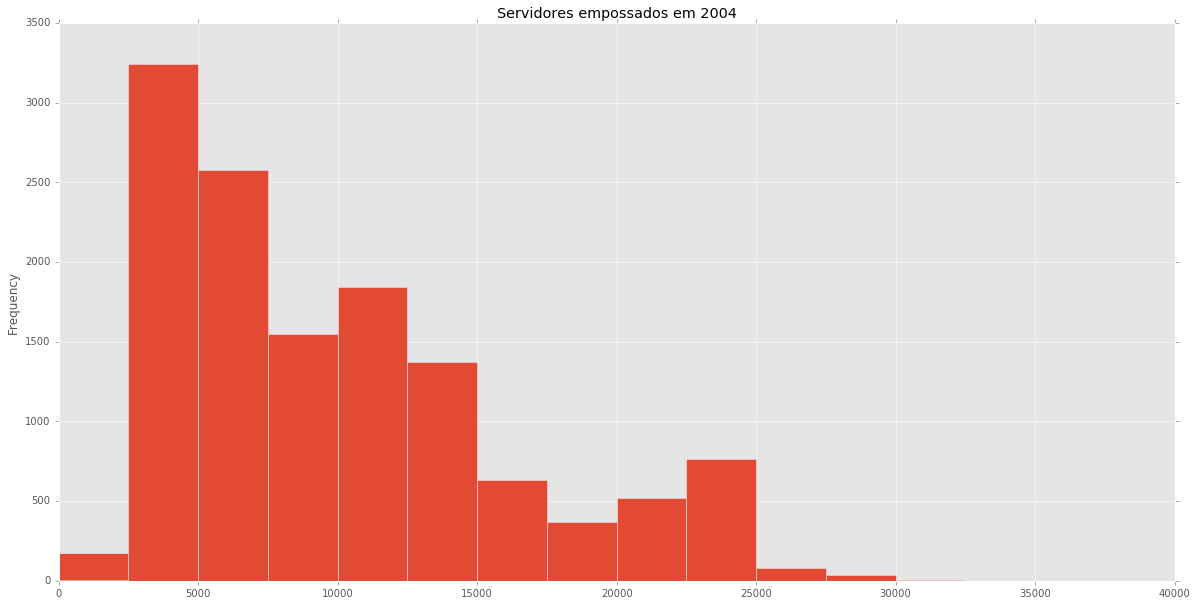

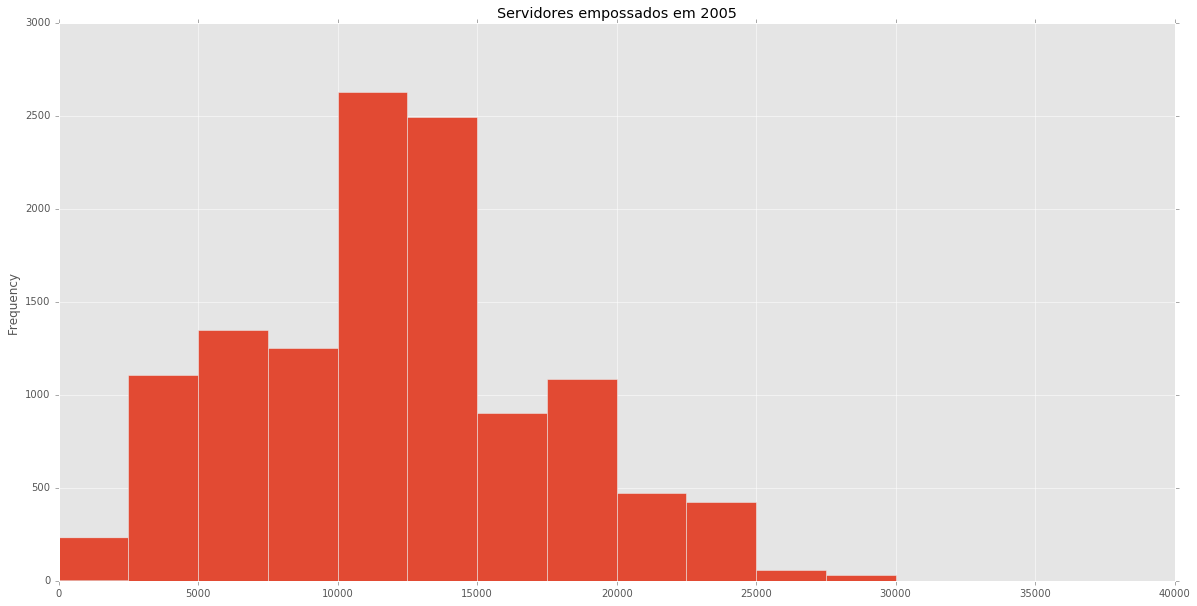

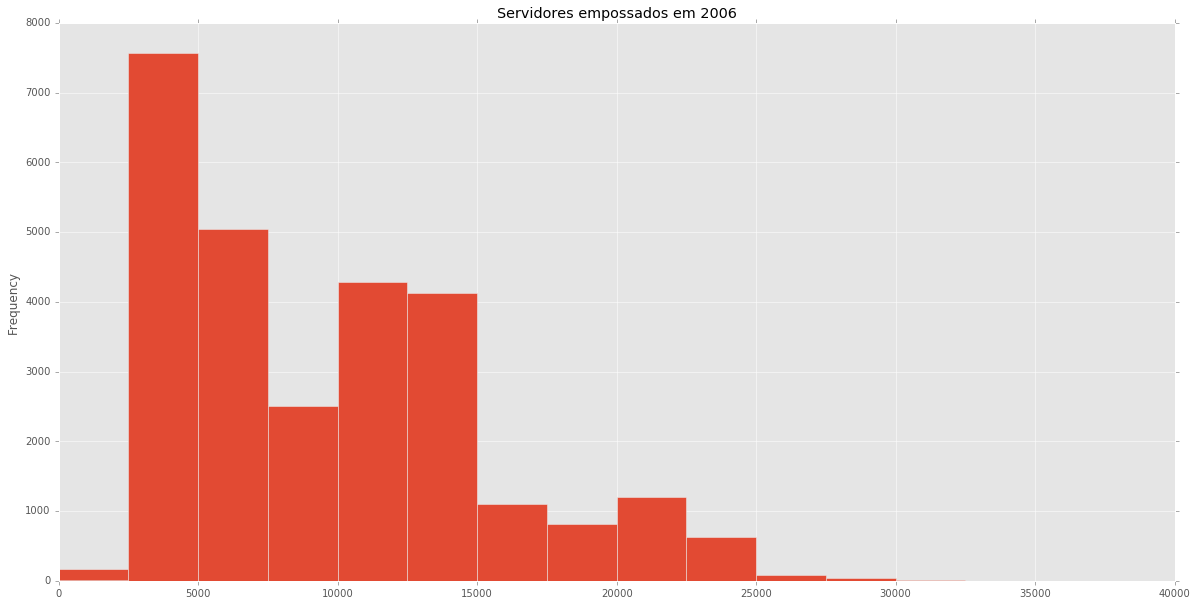

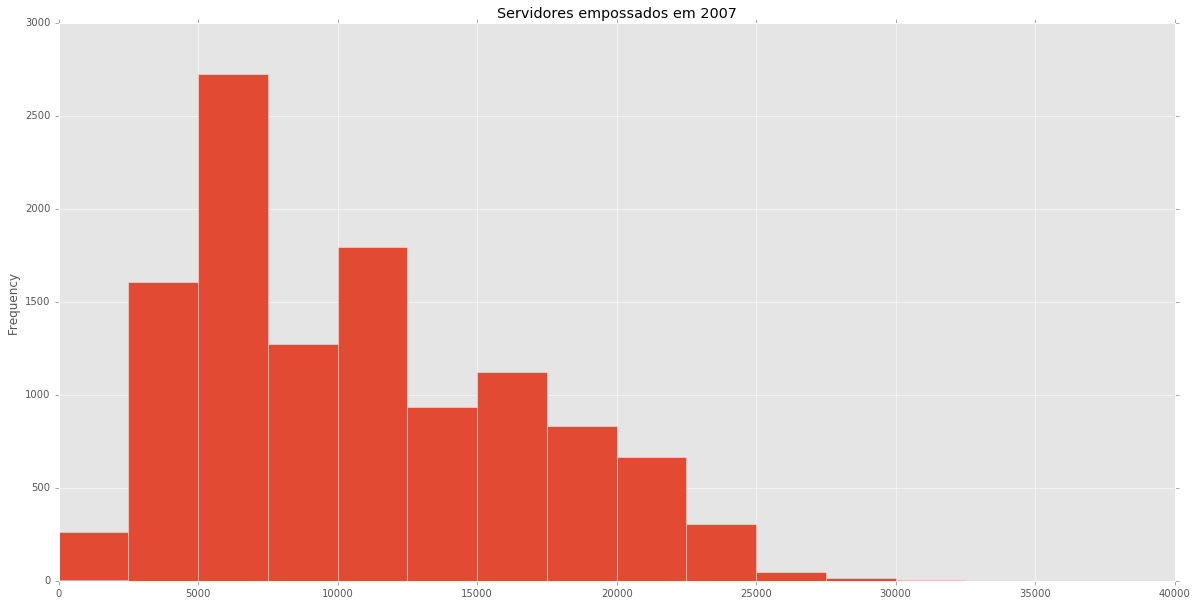

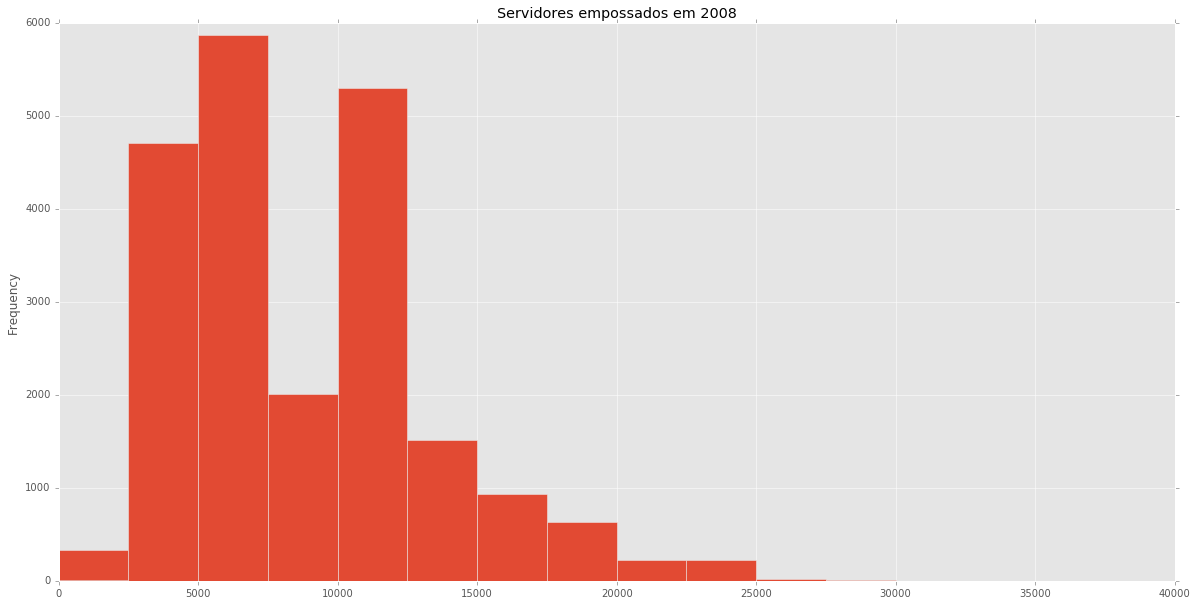

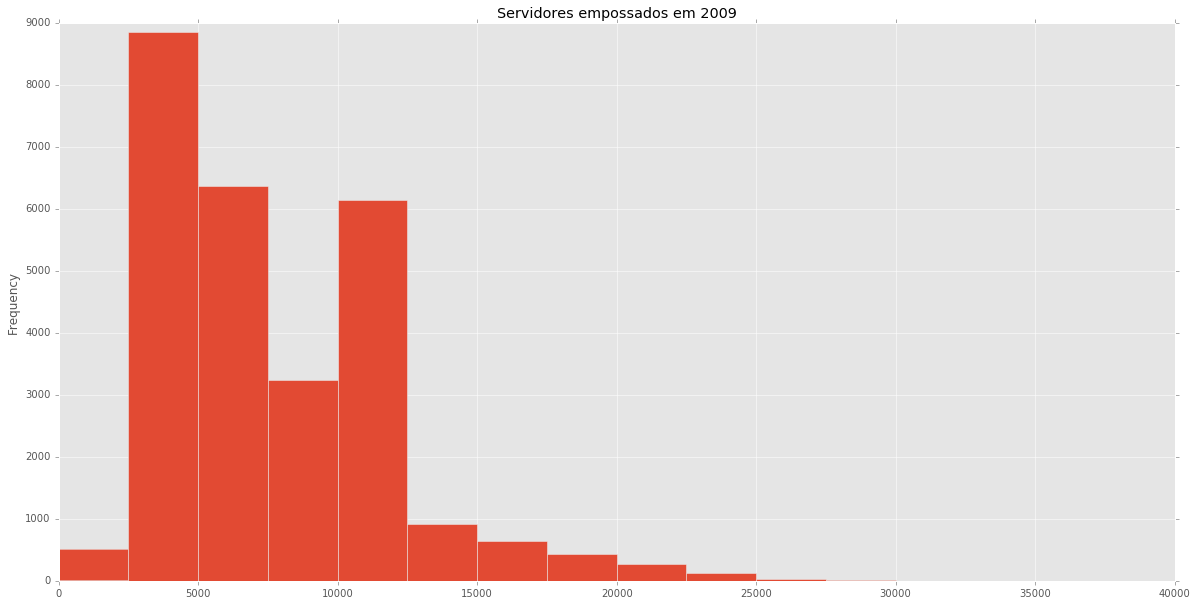

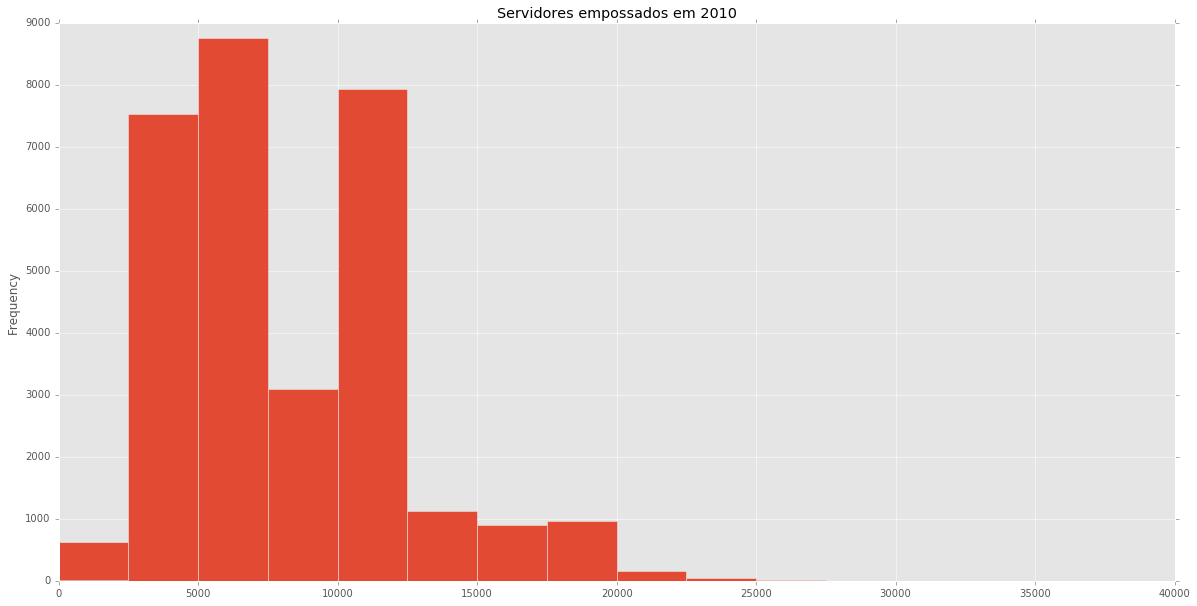

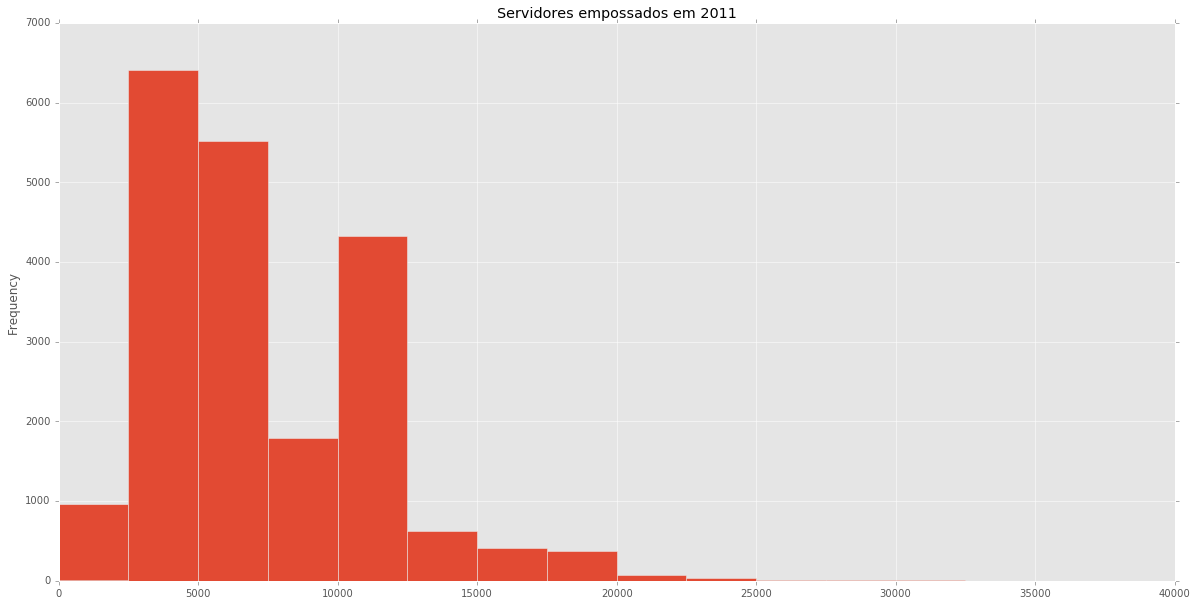

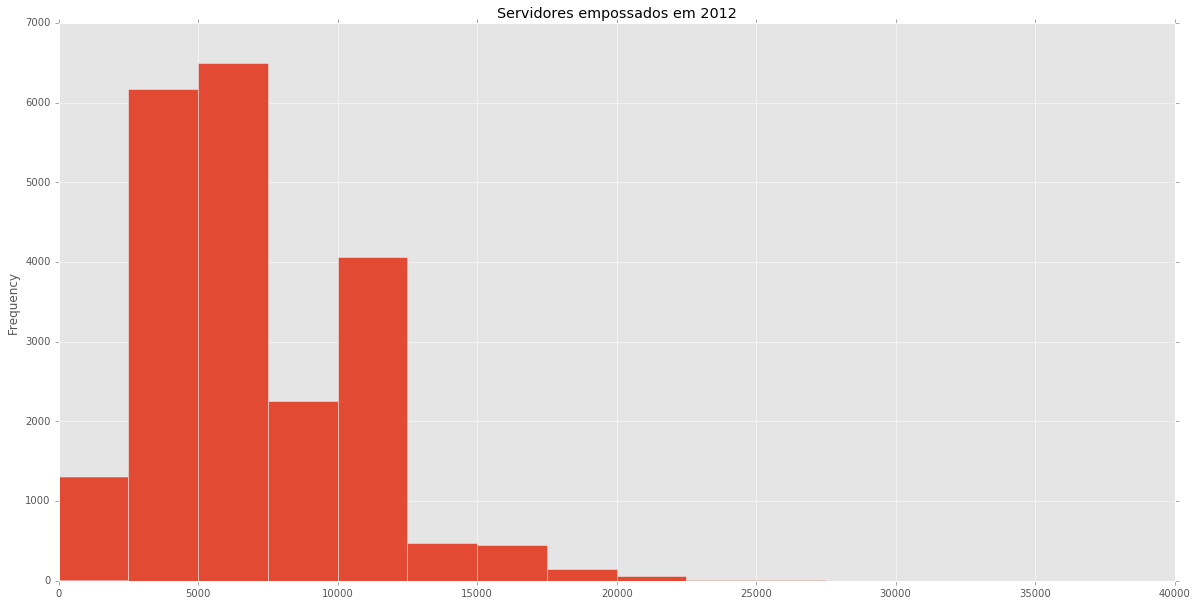

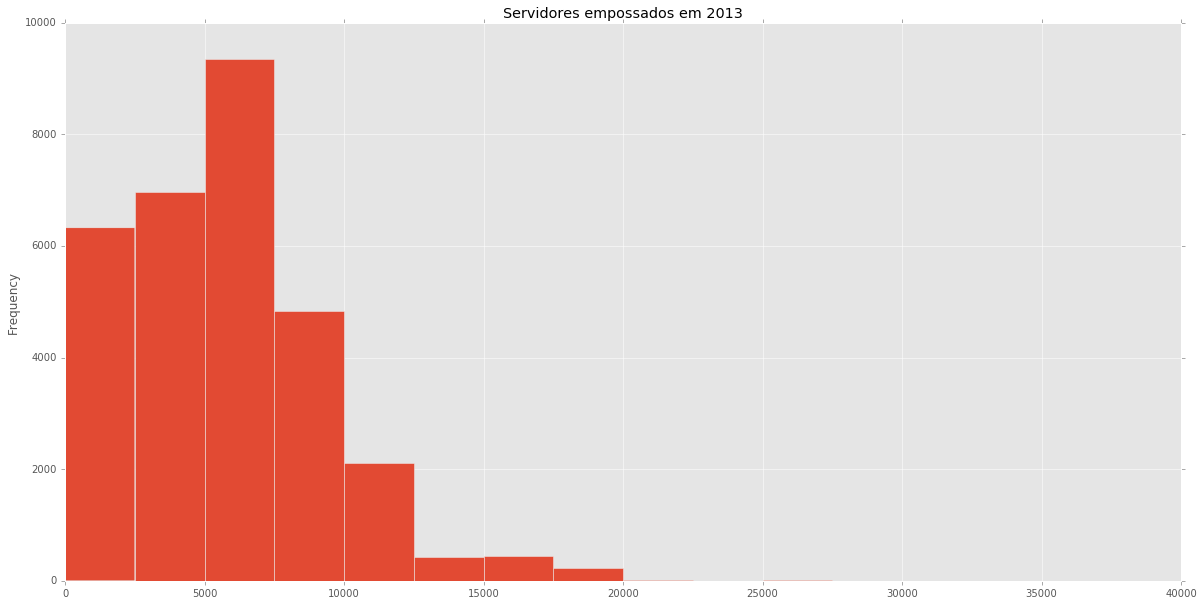

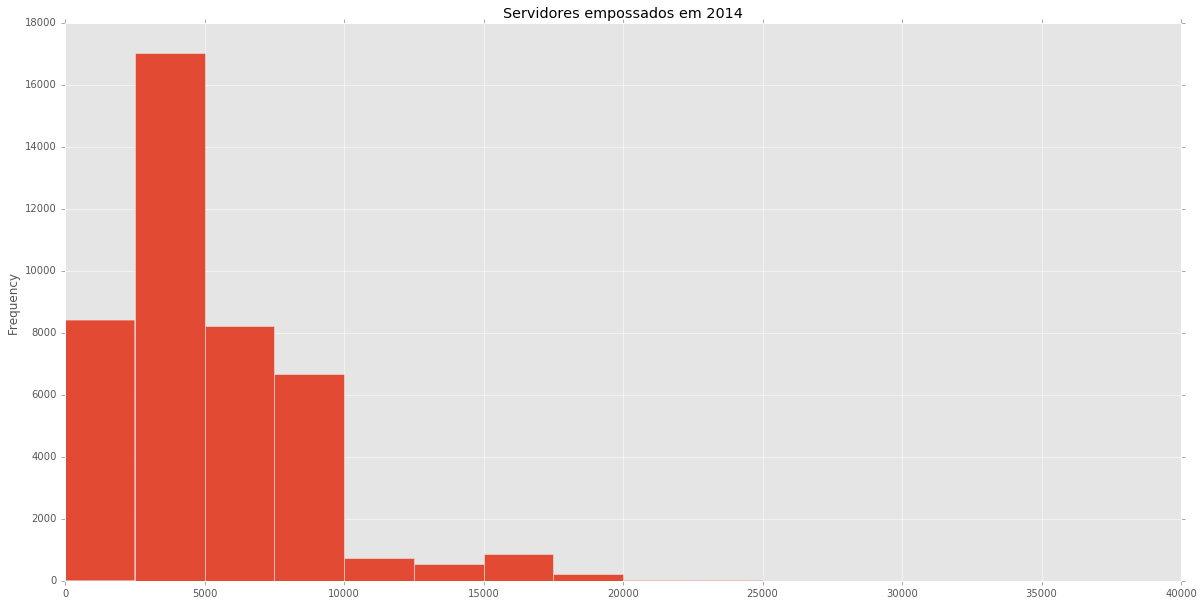

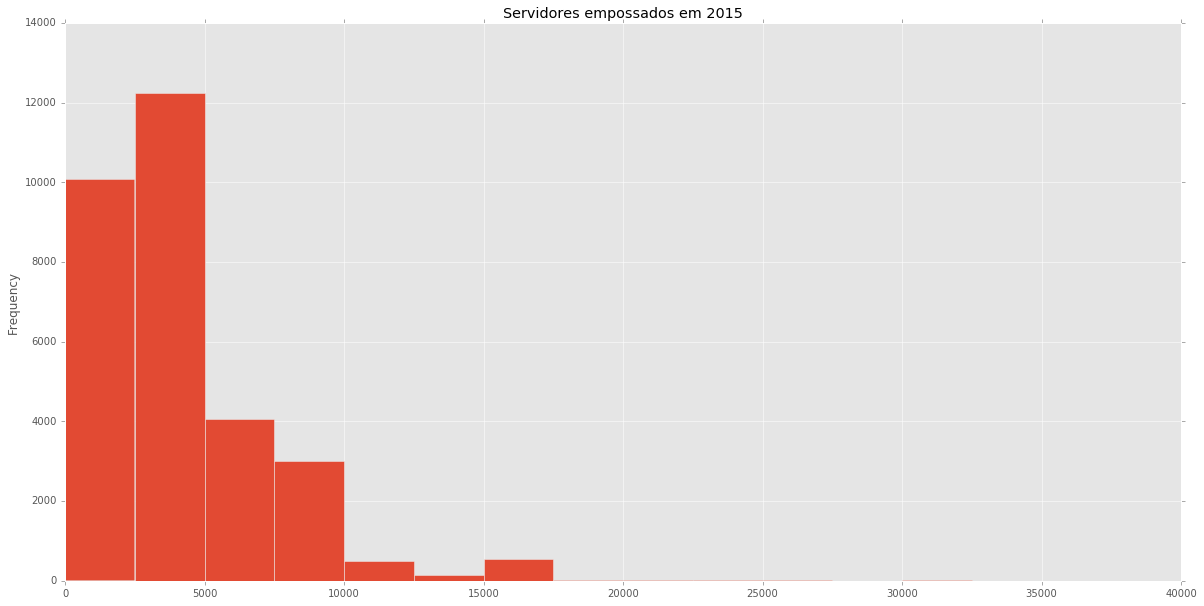

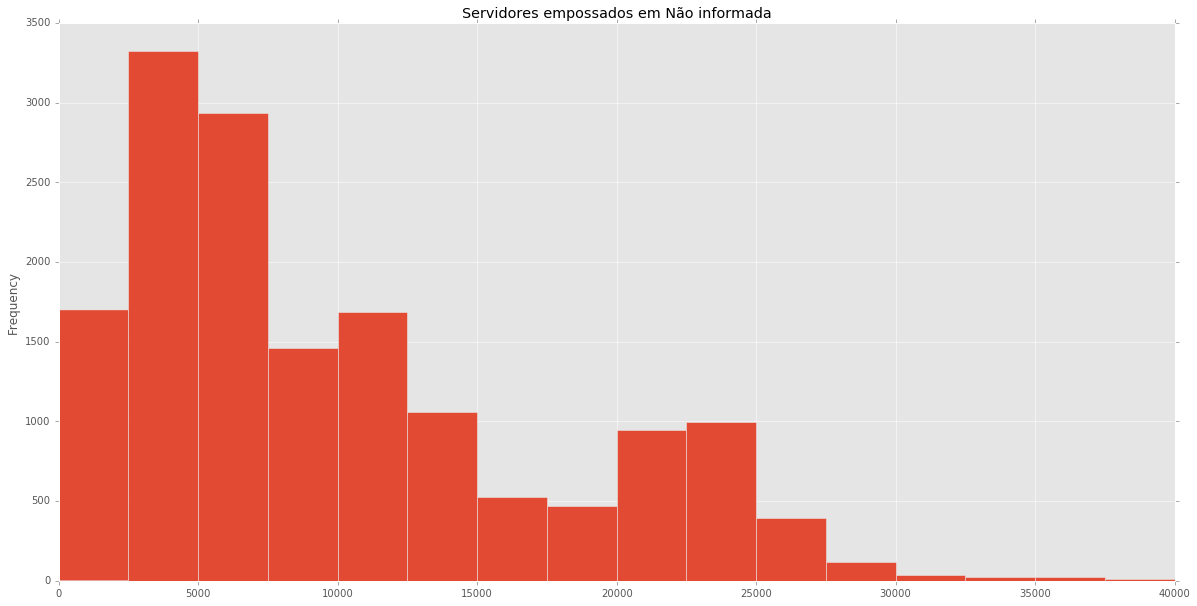

In [112]:
#ploting a histogram for each year

for i, group in x:
    plt.figure()
    group[u'REMUNERAÇÃO BÁSICA BRUTA (R$)'].plot(kind='hist', title=u"Servidores empossados em %s" % i.decode("iso8859-1"), figsize=(20,10), bins=range(0,40001,2500))

É possível observar que um grande percentual de servidores ingressantes nos anos de **1997, 1998, 1999 e 2000** tem salários superiores a **R$20.000** por mês. Essa frequência não é encontrada em nenhuma outro período de tempo

Isso se deu devido ao baixo número de contratações no serviço público durante esse período, em comparação com o número de contratações durante o governo subsequente.


Também é póssivel notar, que a partir de **2003**, a maior parte dos salários fica na casa dos **RS5.000**, com exceção de 2005, cuja frequência maior é entre **RS10.000 e RS15.000**.

### Média por Órgão de Exercício
Embora os salários do executivo sejam relativamente altos, eles variam fortemente de órgão para órgão.

Vamos agrupar os dados por órgão de exercício e filtrar os órgãos com menos de 100 funcionários.

Depois disso vamos calcular a quantidade de funcionários, a mediana e o desvio padrão dos salários desse orgão. Utilizaremos o método **agg** de um dataseries no Pandas.

In [113]:
x = merge_left.drop_duplicates(['NOME','CPF']).groupby(merge_left['ORGSUP_EXERCICIO']).filter(lambda k: len(k) > 100)
x = x.groupby(merge_left['ORGSUP_EXERCICIO'])


x[u'REMUNERAÇÃO BÁSICA BRUTA (R$)'].agg( [np.count_nonzero, np.mean, np.std, np.sum] ).sort_values('mean', ascending=False)


count_nonzero          mean  \
ORGSUP_EXERCICIO                                                        
BANCO CENTRAL DO BRASIL                            4154  19283.845735   
MINISTERIO DA FAZENDA                             31836  14181.373906   
PRESIDENCIA DA REPUBLICA                          15397  13058.078779   
MINISTERIO DE MINAS E ENERGIA                      3290  11752.479605   
MINISTERIO DAS COMUNICACOES                        2242  11640.307827   
MINIST.DA CIENCIA, TECNOLOGIA E INOVACAO           6634  11170.862145   
MINISTERIO DA JUSTICA                             31874  10678.498420   
MINIST.DO DESENV.INDUST.E COMER.EXTERIOR           3261  10471.762581   
MINISTERIO DO TRABALHO E EMPREGO                   7961  10252.451664   
MINIST.DA AGRICULTURA,PECUARIA E ABAST.           10377   9695.853568   
MINISTERIO DO ESPORTE                               412   9489.414217   
MINISTERIO DOS TRANSPORTES                         5608   9271.555744   
MINISTERIO DAS CIDADES                              578   9064.040017   
CAMARA DOS DEPUTADOS                                175   8873.006800   
MINISTERIO DA PREVIDENCIA SOCIAL                  37890   8804.202455   
MINISTERIO DO DESENV SOCIAL E COMB FOME             887   8600.685101   
MINISTERIO DA EDUCACAO                           263368   7641.021206   
MINISTERIO DO MEIO AMBIENTE                        9474   7562.048751   
ESTADOS/MUNICIPIOS/ADM.DIR-AUT/FUNDACOES            135   7509.248815   
MINISTERIO DA INTEGRACAO NACIONAL                  2789   7503.640576   
MINISTERIO DA CULTURA                              3888   7369.943727   
GOVERNO DO DISTRITO FEDERAL                         361   6856.735263   
MINISTERIO DO TURISMO                               476   6709.193096   
MINISTERIO DO DESENVOLVIMENTO AGRARIO              5658   6629.888415   
MINISTERIO DA SAUDE                               44562   6504.136832   
GOVERNO DO ESTADO DO MARANHAO                       247   6304.240729   
MINISTERIO DA DEFESA                              20533   6288.797668   
MINISTERIO DO PLANEJ.,ORCAMENTO E GESTAO          27262   6025.968037   
ESTADOS / MUNICIPIOS / EMPRESAS                   38420   5706.970232   
MINISTERIO DE PESCA E AQUICULTURA                   437   5192.530467   
MINISTERIO DAS RELACOES EXTERIORES                 1265   5018.305920   
TRIBUNAL REGIONAL ELEITORAL - CE                    118   5011.210847   
TRIBUNAL REGIONAL ELEITORAL - DF                    173   4955.090289   
MINIST. PUBLICO DO DF E TERRITORIOS                 104   4758.982500   

                                                  std           sum  
ORGSUP_EXERCICIO                                                     
BANCO CENTRAL DO BRASIL                   5712.317804  8.016295e+07  
MINISTERIO DA FAZENDA                     7486.288156  4.517193e+08  
PRESIDENCIA DA REPUBLICA                  7710.289160  2.015906e+08  
MINISTERIO DE MINAS E ENERGIA             5919.405801  3.868916e+07  
MINISTERIO DAS COMUNICACOES               6141.067077  2.619069e+07  
MINIST.DA CIENCIA, TECNOLOGIA E INOVACAO  4870.840645  7.416335e+07  
MINISTERIO DA JUSTICA                     4937.428960  3.411033e+08  
MINIST.DO DESENV.INDUST.E COMER.EXTERIOR  5454.751781  3.420078e+07  
MINISTERIO DO TRABALHO E EMPREGO          8188.872774  8.168128e+07  
MINIST.DA AGRICULTURA,PECUARIA E ABAST.   5874.051400  1.007399e+08  
MINISTERIO DO ESPORTE                     6738.827813  3.938107e+06  
MINISTERIO DOS TRANSPORTES                4866.594525  5.205979e+07  
MINISTERIO DAS CIDADES                    5737.712225  5.239015e+06  
CAMARA DOS DEPUTADOS                      6267.455103  1.552776e+06  
MINISTERIO DA PREVIDENCIA SOCIAL          3301.287047  3.338201e+08  
MINISTERIO DO DESENV SOCIAL E COMB FOME   6616.177275  7.637408e+06  
MINISTERIO DA EDUCACAO                    4805.202439  2.016381e+09  
MINISTERIO DO MEIO AMBIENTE               5563.678031  7.269397e+07  
ESTADOS/MUNIC

Para ter uma ideia melhor da distribuição salarial por órgão, vamos plotar um gráfico de barras, ordenado da menor para a maior mediana salarial.

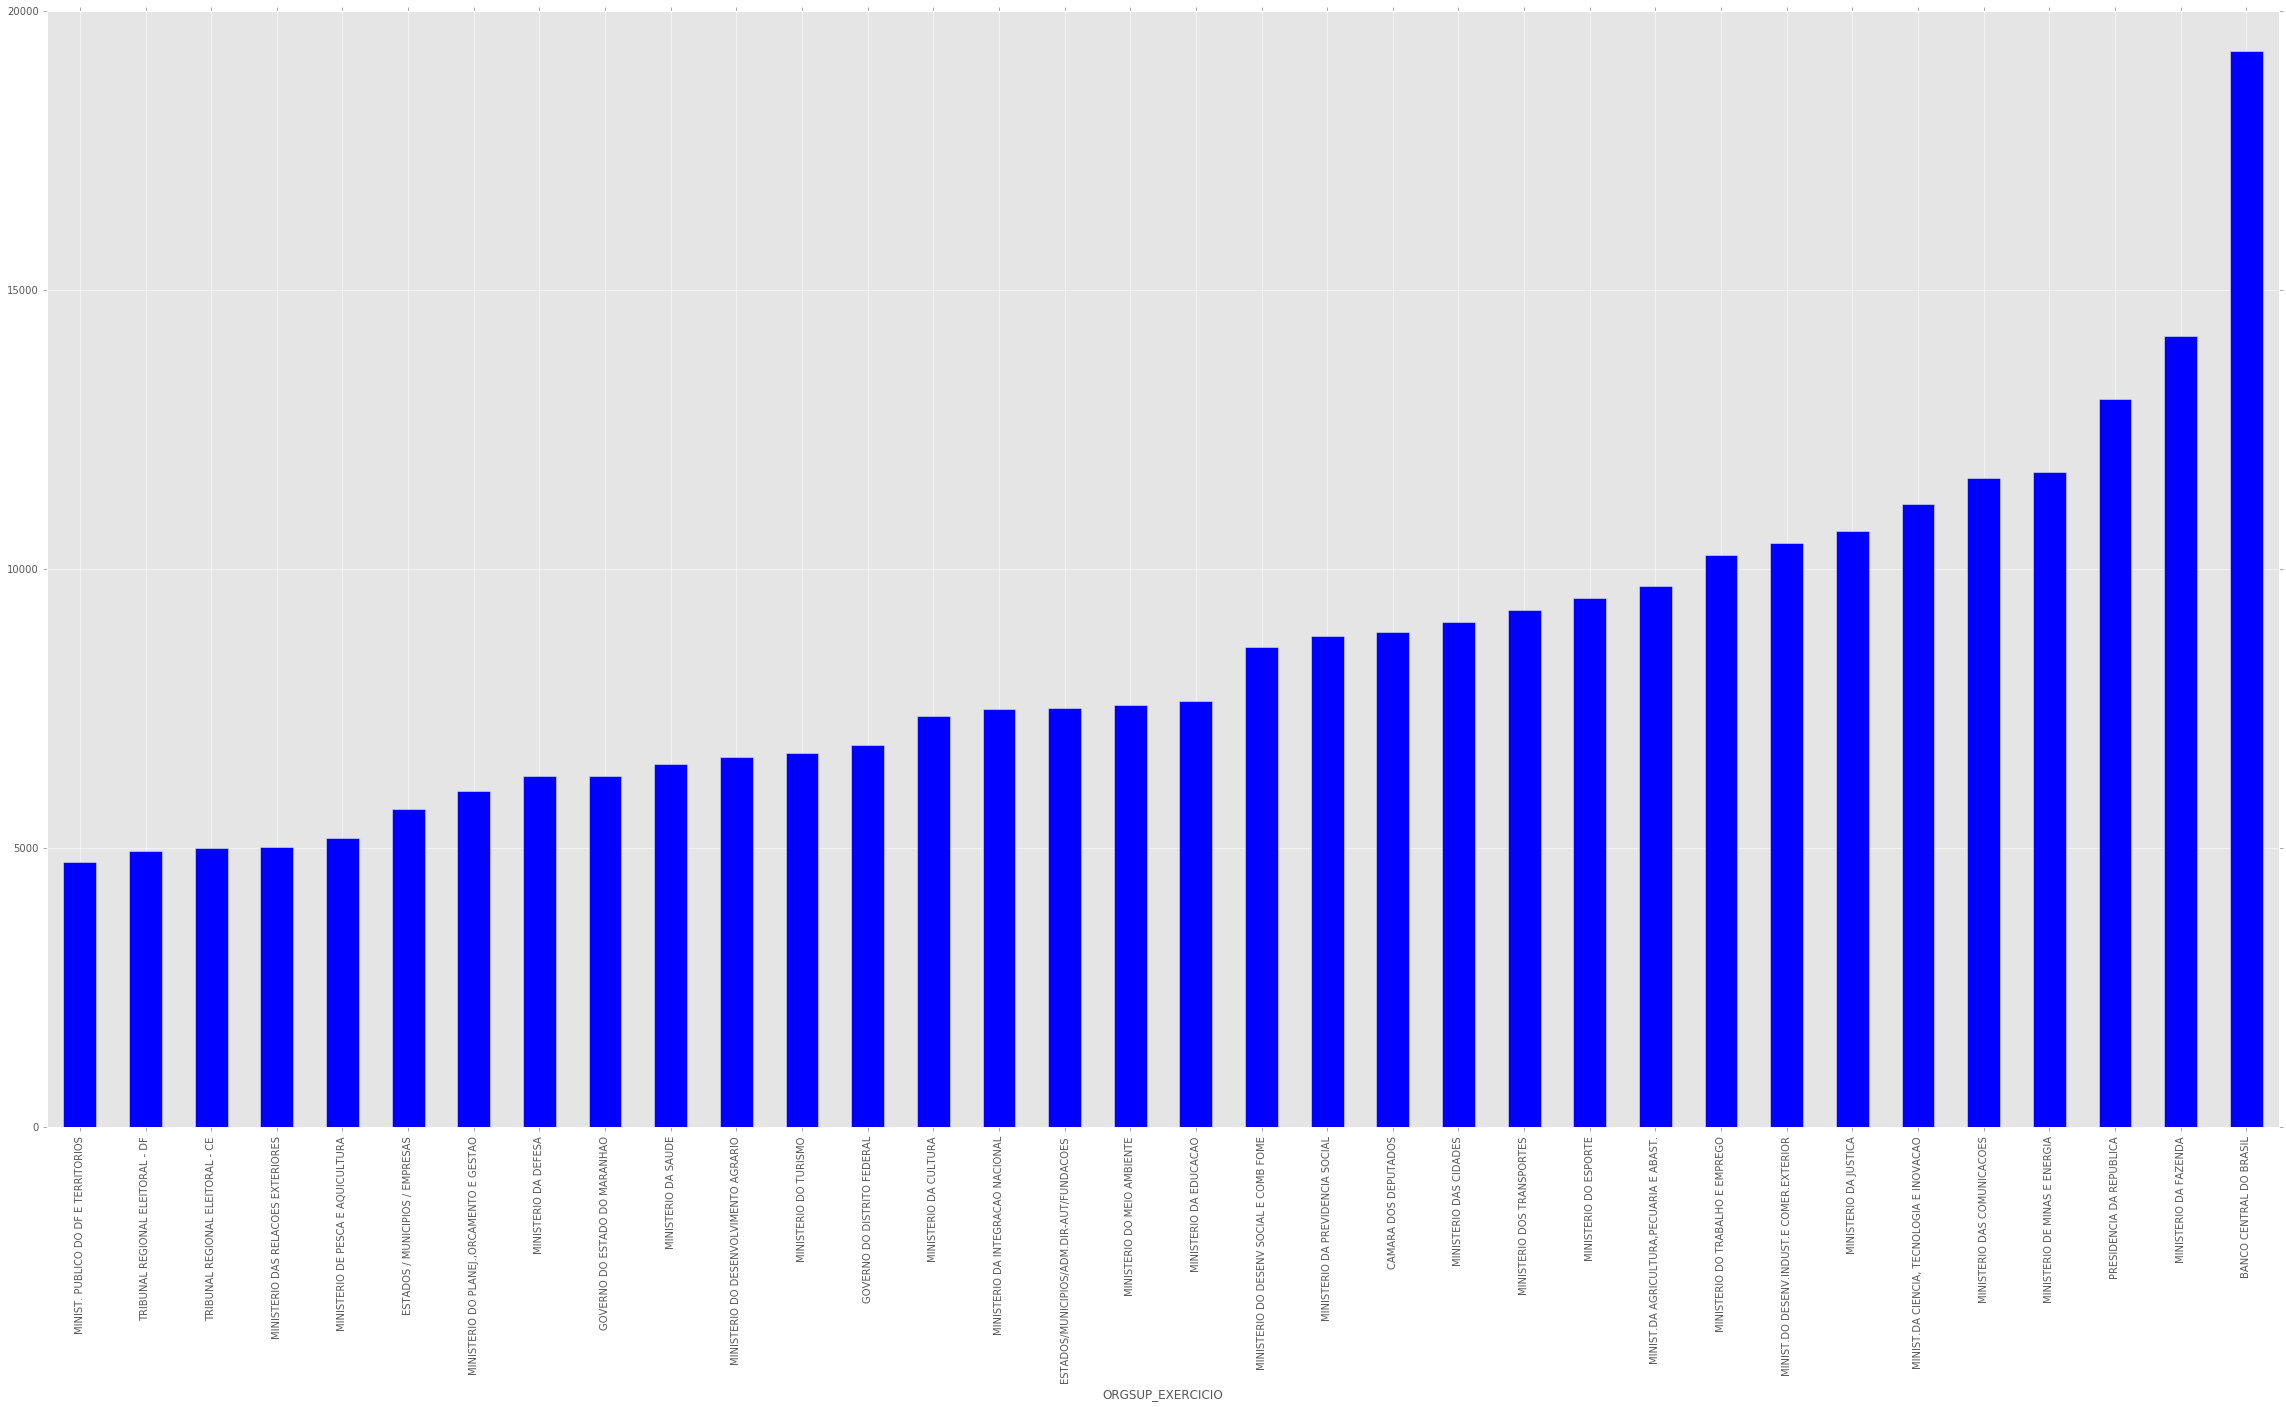

In [114]:
x[u'REMUNERAÇÃO BÁSICA BRUTA (R$)'].mean().sort_values().plot(kind='bar', figsize=(40,20))


Com base no gráfico acima, pode-se perceber que o Banco Centra, o Ministério da Fazenda e a Presidência da República tem as maiores medianas salariais do executivo federal. Contudo, isso não se reflete no total da folha. Se utilizarmos a soma dos salários para plotar um gráfico, é fácil observar que o Ministério da Educação, com seus mais de **350 mil** servidores, é responsável por quase 40% da folha salarial. Isso pode ser visto no gráfico abaixo.

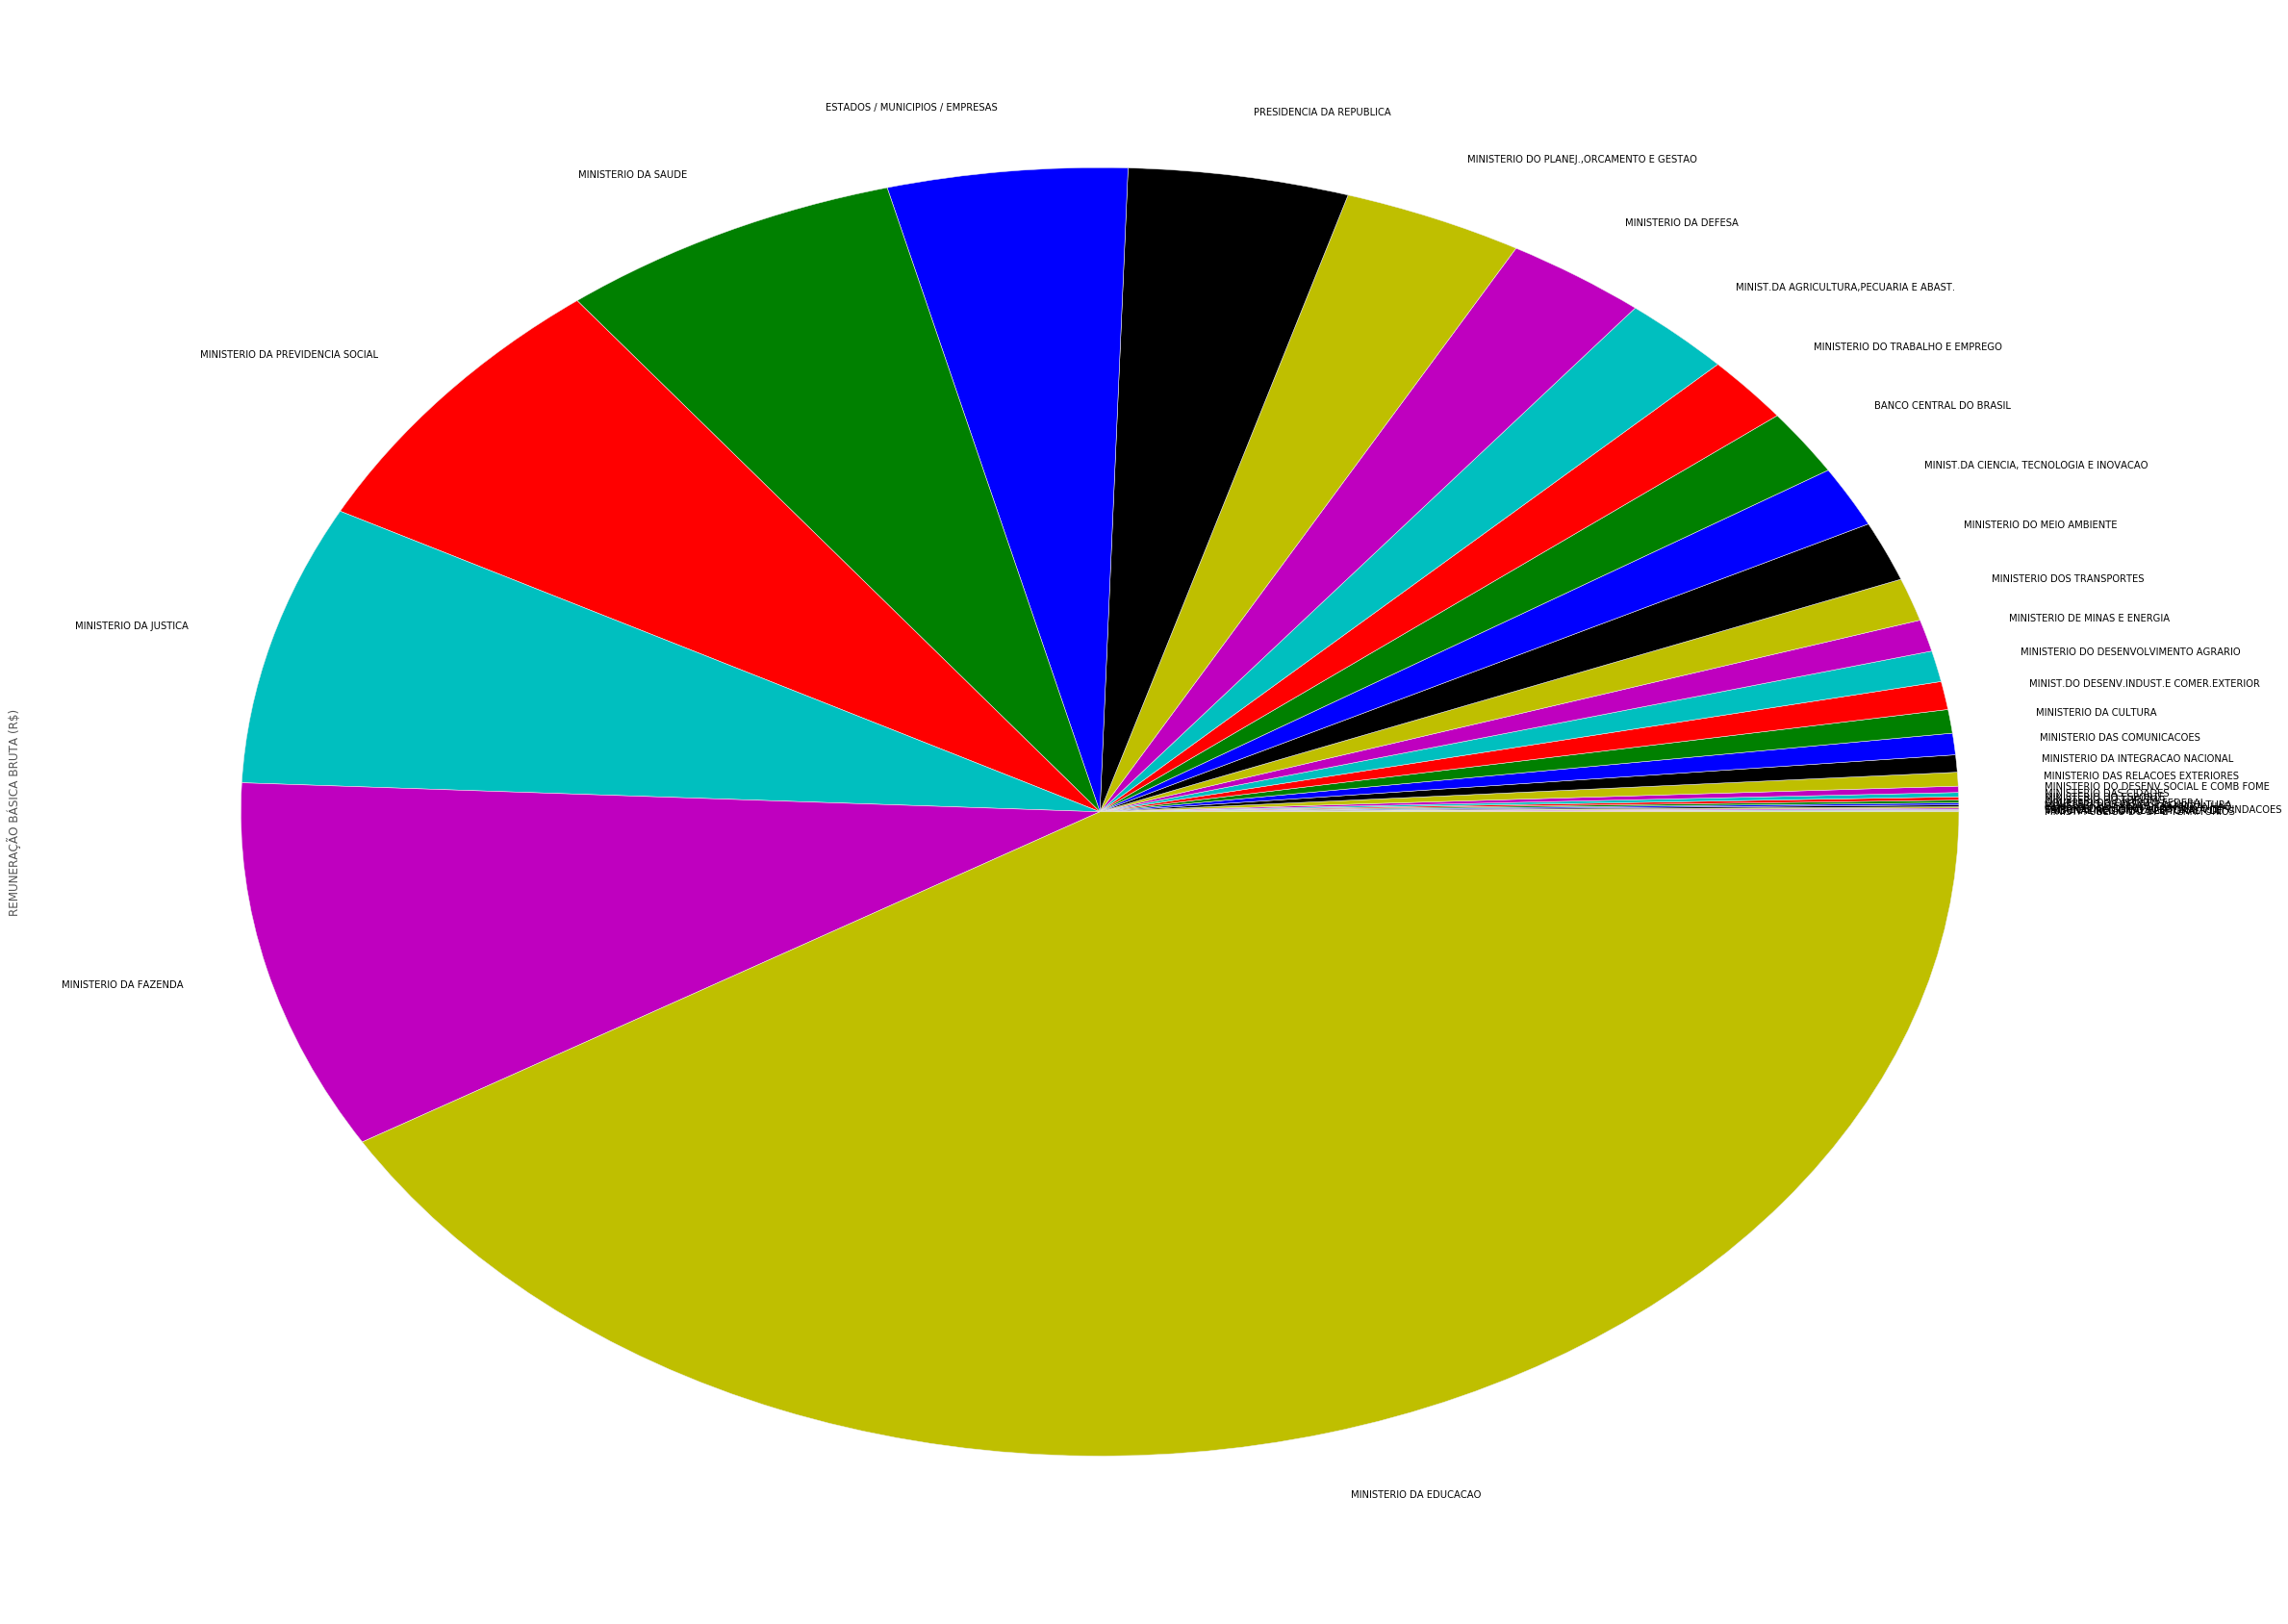

In [115]:
x[u'REMUNERAÇÃO BÁSICA BRUTA (R$)'].sum().sort_values().plot(kind='pie', figsize=(40,30))

**UPDATE**: Vamos realizar os mesmo cálculos por cargo e descobrir quais os cargos com os maiores salários médios, bem como o total desses cargos. Caso o cargo esteja vazio, ele corresponde a uma Função Gratificada ou Cargo de Direção ou Cargo em Comissão.

In [116]:
x = merge_left.drop_duplicates(['NOME','CPF']).groupby(merge_left['DESCRICAO_CARGO']).filter(lambda k: len(k) > 5)
x = x.groupby(merge_left['DESCRICAO_CARGO'])


x[u'REMUNERAÇÃO BÁSICA BRUTA (R$)'].agg( [np.count_nonzero, np.mean, np.std, np.sum] ).sort_values('mean', ascending=False)


count_nonzero          mean  \
DESCRICAO_CARGO                                                         
MINISTRO DE ESTADO                                   20  28411.480455   
TNS - TECNICO DE PLANEJAMENTO                         6  25909.308333   
PESQUISADOR-A                                         5  23382.418333   
FISCAL                                               23  22861.217391   
DELEGADO DE POLICIA CIVIL ESPECIAL                    7  22804.980000   
PERITO CRIMINAL FEDERAL CLASSE ESPECIAL             369  22681.165565   
DELEGADO DE POL FEDERAL CLASSE ESPECIAL             468  22209.570000   
ESP POL PUBL GESTAO GOVERNAMENTAL                   454  22054.681762   
PROCURADOR DA FAZENDA                              1831  21920.440568   
PROCURADOR FEDERAL                                 3230  21866.141752   
ADVOGADO DA UNIAO                                  1376  21839.372246   
AUDITOR-FISCAL DA RECEITA FEDERAL BRASIL           7876  21822.859419   
PROFESSOR 3 GRAU                                     13  21744.794615   
AUDITOR FISCAL DO TRABALHO                         2246  21538.210748   
PROCURADOR DO BANCO CENTRAL                         143  21310.321678   
TECNICO DE PLANEJAMENTO E PESQUISA                  146  21182.579521   
ANALISTA-A                                            9  21048.135556   
ASSISTENTE JURIDICO                                  12  20925.605000   
ANALISTA DE PLANEJAMENTO E ORCAMENTO                218  20521.825596   
JUIZ DO TRIBUNAL MARITIMO                             6  20409.576667   
TECNICO DE PLANEJAMENTO                              37  20312.889189   
PERITO CRIMINAL FEDERAL 1A CLASSE                   594  20293.167323   
DELEGADO DE POLICIA FEDERAL 1A  CLASSE              502  20235.621392   
TECNICO DE DESENVOL E ADMINISTRACAO                  19  20205.085789   
ANALISTA DO BANCO CENTRAL                          2303  19734.519137   
INSPETOR CVM                                         85  19474.332471   
ANALISTA DE FINANCAS E CONTROLE                    1789  18962.877350   
ESPEC SENIOR EM PROPRIED INDUSTRIAL                   7  18858.935714   
ANALISTA TECNICO SUSEP                              226  18789.877389   
ANALISTA CVM                                        207  18762.468261   
...                                                 ...           ...   
CABISTA                                              10   2767.190000   
SECRETARIA II                                         6   2761.720000   
VESTIARISTA                                          68   2753.909275   
AUXILIAR RURAL                                       44   2724.174545   
CARGO CLT EM EXTINCAO BACEN                          24   2698.327083   
AUXILIAR DE SERVICOS                                 20   2685.450500   
OPERADOR DE MAQ DE LAVANDERIA                       274   2680.751314   
TRADUTOR INTERPRETE DE LINGUAGEM SINAIS             560   2677.991804   
ADMINISTRADOR DE EDIFICIOS                          166   2666.337108   
OPERADOR DE LUZ                                      10   2664.997000   
LAVADEIRA O PASSADEIRA O                              6   2645.610000   
ARTIFICE DE VIA PERMANENTE                           27   2619.633333   
AUXILIAR OPERACIONAL SERVI�OS DIVERSOS               15   2614.430000   
AUX EXEC EM METROLOGIA E QUALIDADE                    9   2598.902222   
ARTIFICE DE MANUTENCAO                               61   2580.840492   
MESTRE DE EMBARCACOES DE PEQUENO PORTE                6   2578.870000   
ELETRICISTA TECNICO                                   7   2560.031429   
ASSISTENTE DE ALUNO                                1466   2493.145280   
AUXILIAR DE LIMPEZA                                  11   2488.737273   
MANOBRADOR                                            8   2474.655000   
OFICIAL DE CHANCELARIA                              181   2421.780282   
AUXILIAR DESENV TECNOL NUCLEAR E DEFESA             224   2360.006964   
PRIMEIRO SECRETARIO        

Como é possível perceber, os cargos comissionados são responsáveis por quase 20% do orçamento para o pagamento de salários, sendo seguidos pelos Professores de Ensino Superior, Professores de Ensino Técnico e Auditores da Receita Fiscal.

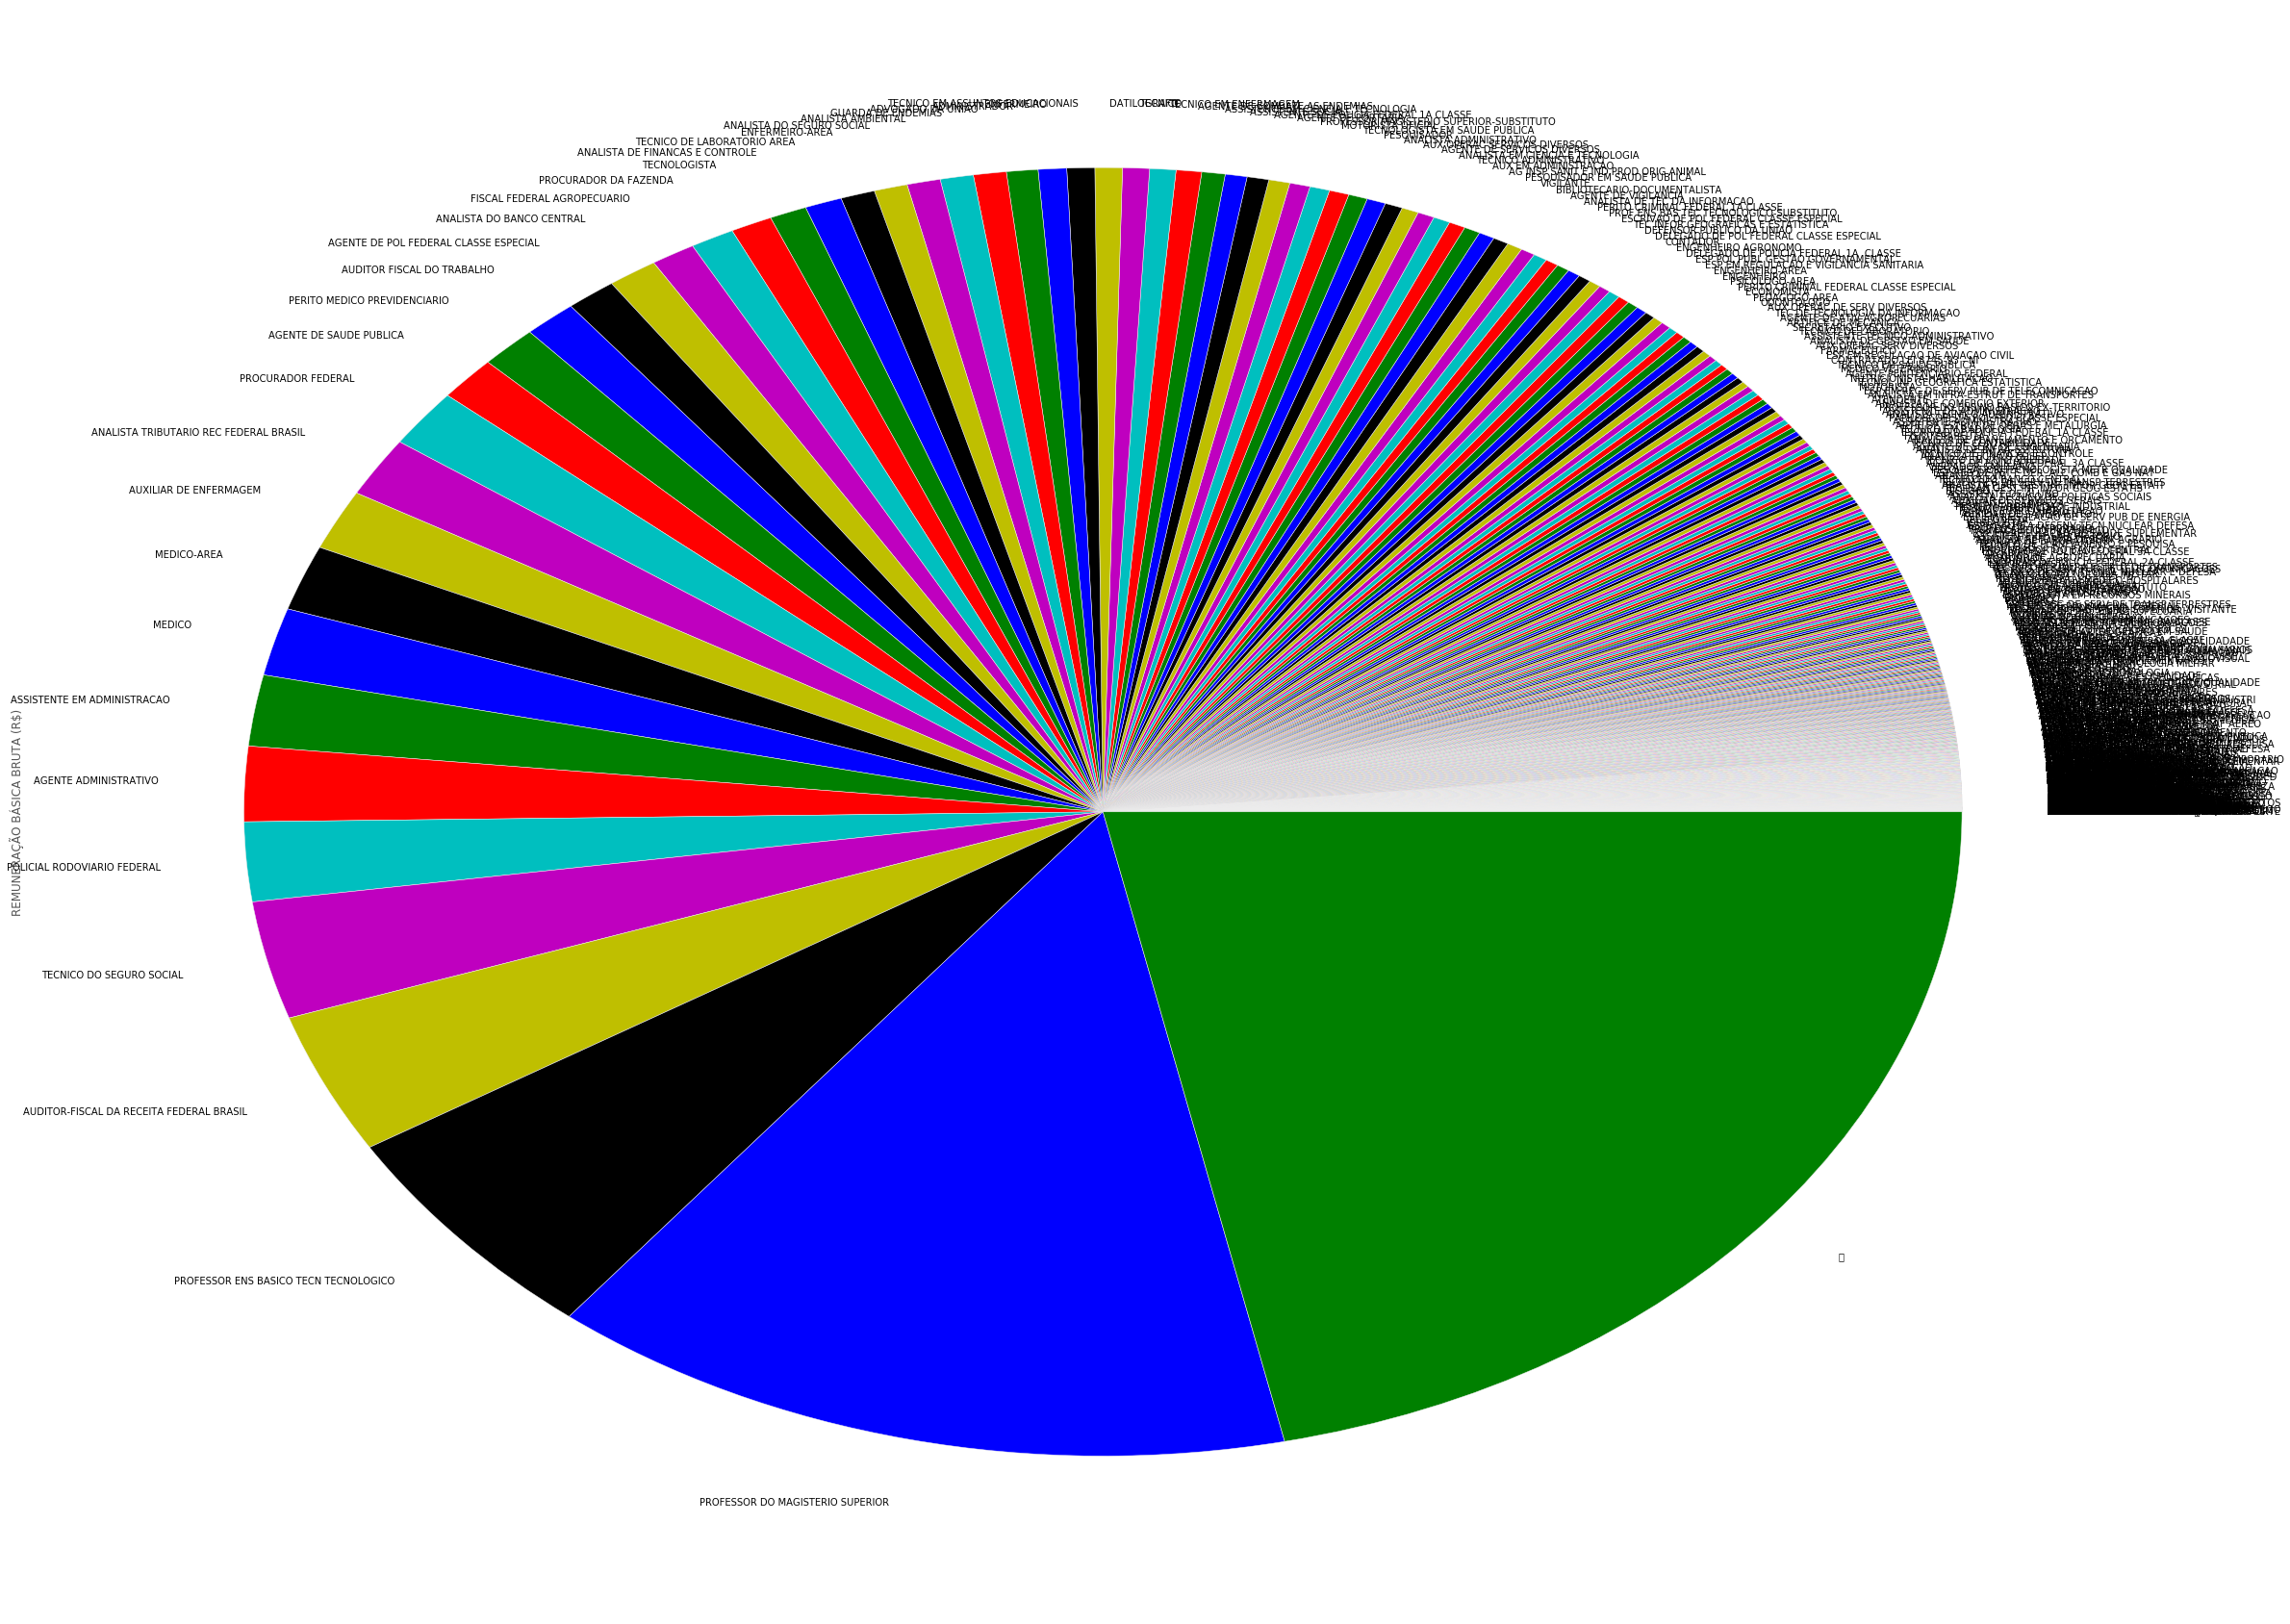

In [117]:
x[u'REMUNERAÇÃO BÁSICA BRUTA (R$)'].sum().sort_values().plot(kind='pie', figsize=(40,30))

Espero que tenham gostado da leitura. Os dados estão disponíveis no Portal da Transparência. Se você tiver alguma crítica, ou sugestão, ou quiser entrar em contato comigo, mande um email para contato@henrique.email.

**Publicado em Janeiro/2016**

**Alterado em 13/01/2016**

